# Deep Convolutional GAN (DCGAN) with NPY files

In [1]:
# GPU使用時の設定
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

## 環境変数を設定

In [2]:
# 引き継ぐ学習回数の指定
train_iterates = 0
# 画像サイズの設定
image_size = 64

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, array_to_img
#モデルの可視化
from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils.vis_utils import plot_model
from keras.models import load_model	
import glob

Using TensorFlow backend.
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [4]:
# 入力画像サイズを変更できる様にする
img_rows = 64
img_cols = 64
channels = 3

# 入力画像の形状（64 x 64 x 3) //カラー画像
img_shape = (img_rows, img_cols, channels)

# noiseベクトルサイズ（生成器へのINPUT)
z_dim = 100

## Generator

In [5]:
def build_generator(z_dim):

    model = Sequential()

    # 全結合層によってnoiseベクトル(200次元）をReshapeして7x7x256 tensorに変換する
    model.add(Dense(256 * 8 * 8, input_dim=z_dim))
    model.add(Reshape((8, 8, 256)))

    # 転置畳み込みにより8x8x256 から 16x16x128テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより16x16x128 から 32x32x64テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより32x32x64 から32x32x32 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    # 転置畳み込みにより32x32x32 から64x64x64 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 32x32x32 to 64x64x3 tensor
    #入力画像サイズを変更できる様にする 64*strides→出力サイズ
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same'))

    # tanh活性化を適用して出力（最終層だけはバッチ正規化はしない）
    model.add(Activation('tanh'))

    return model

Instructions for updating:
Colocations handled automatically by placer.


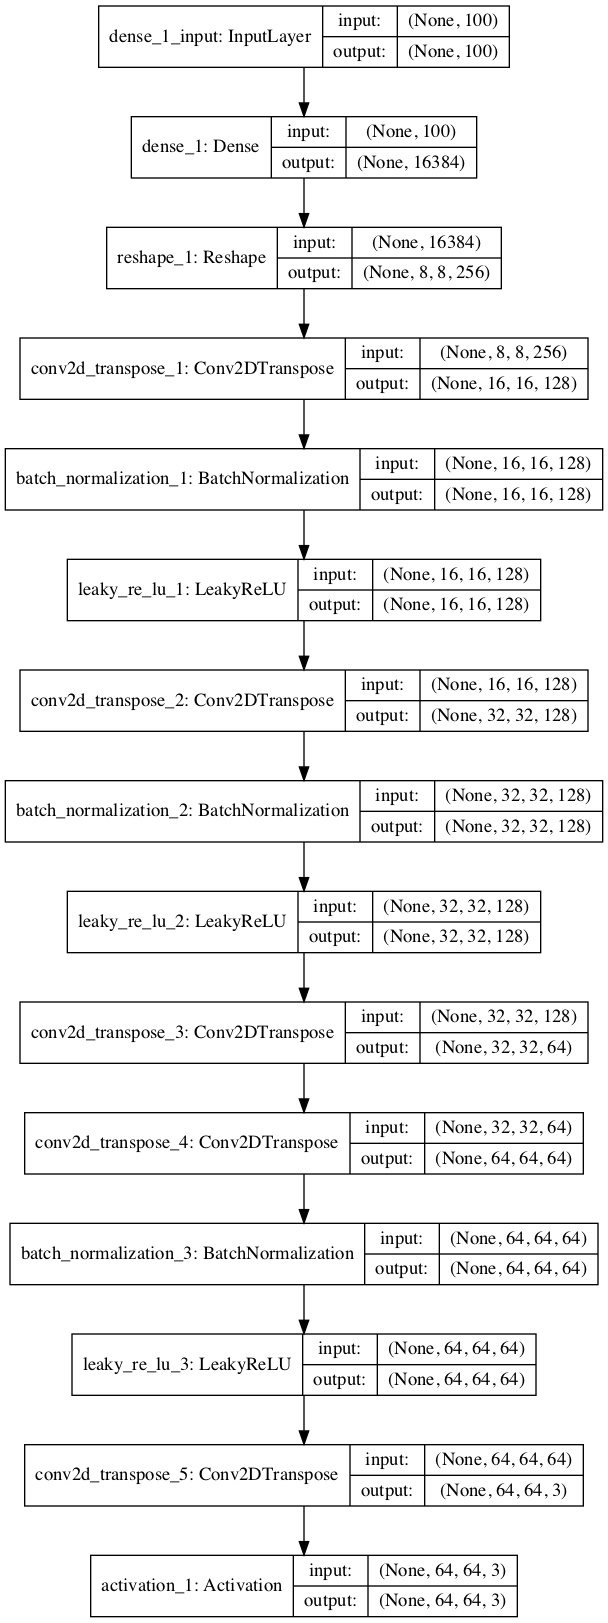

In [6]:
build_model = build_generator(z_dim)

plot_model(build_model, to_file="DCGAB_build_model.png", show_shapes=True)

## Discriminator

In [7]:
def build_discriminator(img_shape):

    model = Sequential()

    # 64x64x3(入力画像) を32x32x32のテンソルにする畳み込み層
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same')) #padding=sameにすると、入力の大きさをstridesの大きさで単純に割ったもの(28/2=14)が出力の大きさになる

    # Leaky ReLUによる活性化(最初の層にはバッチ正規化は適用しない)
    model.add(LeakyReLU(alpha=0.01))

    # 32x32x32 を16x16x64のテンソルにする畳み込み層
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLUによる活性化
    model.add(LeakyReLU(alpha=0.01))

    # 16x16x64 を8x8x128のテンソルにする畳み込み層
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # シグモイド関数で出力（０～１）
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

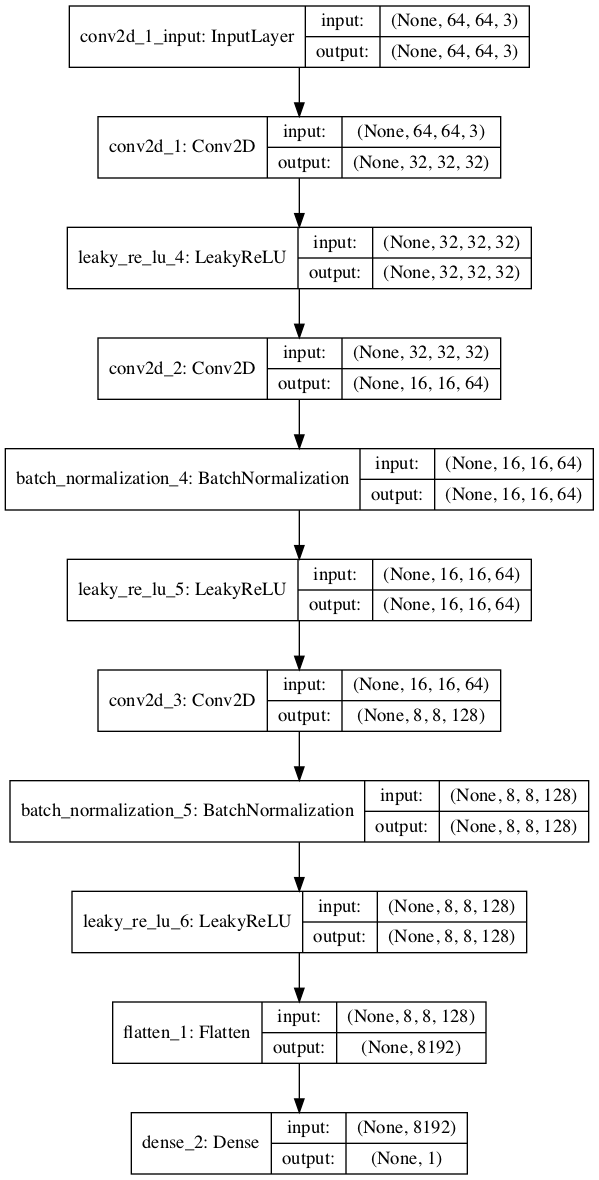

In [8]:
discriminator_model = build_discriminator(img_shape)

plot_model(discriminator_model, to_file="DCGAB_discriminator_model.png", show_shapes=True)

In [9]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別機を結合
    model.add(generator)
    model.add(discriminator)

    return model

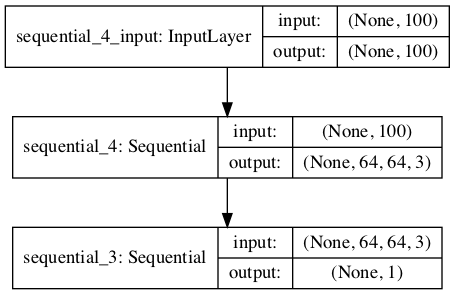

In [10]:
discriminator = build_discriminator(img_shape)
generator = build_generator(z_dim)
gan_model = build_gan(generator, discriminator)

plot_model(gan_model, to_file="DCGAB_gan_model.png", show_shapes=True)

In [11]:
# 識別機の生成とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#前回学習の重みをロード
if train_iterates > 0:
    weights_path_1 = 'dcgan/models/D/d_model-' + str(train_iterates) + '.h5'
    discriminator.load_weights(weights_path_1)

# 生成器の生成
generator = build_generator(z_dim)

# 生成器の訓練時は識別機のパラメータを固定する
discriminator.trainable = False

# 識別機は固定のまま生成器を訓練するGANモデルの生成とコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
#途中までの学習済みモデルのロード
from keras.models import load_model

model_g_dir = "dcgan/models/G"
model_d_dir = "dcgan/models/D"
if train_iterates > 0:
    models_path_1 = model_g_dir + '/g_param-' + str(train_iterates) + '.hdf5'
    generator.load_weights(models_path_1)

if train_iterates > 0:
    models_path_2 = model_g_dir + '/gan_param-' + str(train_iterates) + '.hdf5'
    gan.load_weights(models_path_2)

## Training

In [13]:
losses = []
accuracies = []
iteration_checkpoints = []
output_dir = "/Users/murakamikei/Desktop/GanPractice/dcgan/data"
model_g_dir = "/Users/murakamikei/Desktop/GanPractice/dcgan/models/G"
model_d_dir = "/Users/murakamikei/Desktop/GanPractice/dcgan/models/D"
num_of_trials = train_iterates

def train(iterations, batch_size, sample_interval):
  # 学習するデータセットを読み込む
  datasets = np.load("/Users/murakamikei/Desktop/GanPractice/dcgan/data/result.npy")

  # ndary型に変換
  X_train = datasets # (2000, 64, 64, 3)

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
    
  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))
  print("check-001")

  for iteration in range(iterations):

      # -------------------------
      #  Train the Discriminator
      # -------------------------
      print("iteration=", iteration)
      # Get a random batch of real images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
       # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)
       # Train Discriminator
      d_loss_real = discriminator.train_on_batch(imgs, real)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
      d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
     
      
      # ---------------------
      #  Train the Generator
      # ---------------------

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)

      # Train Generator
      g_loss = gan.train_on_batch(z, real)

      # if (iteration + 1) % sample_interval == 0:
      if iteration % sample_interval == 0:
          # Save losses and accuracies so they can be plotted after training
          losses.append((d_loss, g_loss))
          accuracies.append(100.0 * accuracy)
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

          # Output a sample of generated image
          sample_images(generator, iteration)
          #識別器のモデル保存
          d_model_file=os.path.join(model_d_dir, "d_model-" + str(iteration + num_of_trials) +  ".h5")
          d_param_file=os.path.join(model_d_dir, "d_param-" + str(iteration + num_of_trials) +  ".hdf5")
          discriminator.save(d_model_file)	
          discriminator.save_weights(d_param_file)
          
          #生成器のモデル保存
          g_model_file=os.path.join(model_g_dir, "g_model-" + str(iteration + num_of_trials) +  ".h5")
          g_param_file=os.path.join(model_g_dir, "g_param-" + str(iteration + num_of_trials) +  ".hdf5")
          generator.save(g_model_file)	
          generator.save_weights(g_param_file)
          gan_model_file=os.path.join(model_g_dir, "gan_model-" + str(iteration + num_of_trials) +  ".h5")
          gan_param_file=os.path.join(model_g_dir, "gan_param-" + str(iteration + num_of_trials) +  ".hdf5")

          gan.save(gan_model_file)	
          gan.save_weights(gan_param_file)
          
          



In [14]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)  # (16, 64, 64, 3)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    print("生成されている画像の枚数とサイズ", gen_imgs.shape)
    # print("gen_imgs_type=", type(gen_imgs.shape))
    print("生成されている一枚一枚の画像サイズ=", gen_imgs[0,:,:,:].shape)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            print("shape=",gen_imgs[cnt, :, :, :].shape)
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    #file保存
    output_file = os.path.join(output_dir, 'result_' + str(iteration + num_of_trials) +'.png')
    plt.savefig(output_file)


In [ ]:
# Set hyperparameters

batch_size = 64

iterations =  50000
sample_interval = 100

if train_iterates > 0:
    iterations = 20000
    sample_interval = 100


# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

check-001
iteration= 0
Instructions for updating:
Use tf.cast instead.


/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 1.339406, acc.: 37.50%] [G loss: 0.039335]
生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1
iteration= 2
iteration= 3
iteration= 4
iteration= 5
iteration= 6
iteration= 7
iteration= 8
iteration= 9
iteration= 10
iteration= 11
iteration= 12
iteration= 13
iteration= 14
iteration= 15
iteration= 16
iteration= 17
iteration= 18
iteration= 19
iteration= 20
iteration= 21
iteration= 22
iteration= 23
iteration= 24
iteration= 25
iteration= 26
iteration= 27
iteration= 28
iteration= 29
iteration= 30
iteration= 31
iteration= 32
iteration= 33
iteration= 34
iteration= 35
iteration= 36
iteration= 37
iteration= 38
iteration= 39
iteration= 40
iteration= 41
iteration= 42

iteration= 413
iteration= 414
iteration= 415
iteration= 416
iteration= 417
iteration= 418
iteration= 419
iteration= 420
iteration= 421
iteration= 422
iteration= 423
iteration= 424
iteration= 425
iteration= 426
iteration= 427
iteration= 428
iteration= 429
iteration= 430
iteration= 431
iteration= 432
iteration= 433
iteration= 434
iteration= 435
iteration= 436
iteration= 437
iteration= 438
iteration= 439
iteration= 440
iteration= 441
iteration= 442
iteration= 443
iteration= 444
iteration= 445
iteration= 446
iteration= 447
iteration= 448
iteration= 449
iteration= 450
iteration= 451
iteration= 452
iteration= 453
iteration= 454
iteration= 455
iteration= 456
iteration= 457
iteration= 458
iteration= 459
iteration= 460
iteration= 461
iteration= 462
iteration= 463
iteration= 464
iteration= 465
iteration= 466
iteration= 467
iteration= 468
iteration= 469
iteration= 470
iteration= 471
iteration= 472
iteration= 473
iteration= 474
iteration= 475
iteration= 476
iteration= 477
iteration= 478
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 501
iteration= 502
iteration= 503
iteration= 504
iteration= 505
iteration= 506
iteration= 507
iteration= 508
iteration= 509
iteration= 510
iteration= 511
iteration= 512
iteration= 513
iteration= 514
iteration= 515
iteration= 516
iteration= 517
iteration= 518
iteration= 519
iteration= 520
iteration= 521
iteration= 522
iteration= 523
iteration= 524
iteration= 525
iteration= 526
iteration= 527
iteration= 528
iteration= 529
iteration= 530
iteration= 531
iteration= 532
iteration= 533
iteration= 534
iteration= 535
iteration= 536
iteration= 537
iteration= 538
iteration= 539
iteration= 540
iteration= 541
iteration= 542
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 601
iteration= 602
iteration= 603
iteration= 604
iteration= 605
iteration= 606
iteration= 607
iteration= 608
iteration= 609
iteration= 610
iteration= 611
iteration= 612
iteration= 613
iteration= 614
iteration= 615
iteration= 616
iteration= 617
iteration= 618
iteration= 619
iteration= 620
iteration= 621
iteration= 622
iteration= 623
iteration= 624
iteration= 625
iteration= 626
iteration= 627
iteration= 628
iteration= 629
iteration= 630
iteration= 631
iteration= 632
iteration= 633
iteration= 634
iteration= 635
iteration= 636
iteration= 637
iteration= 638
iteration= 639
iteration= 640
iteration= 641
iteration= 642
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 701
iteration= 702
iteration= 703
iteration= 704
iteration= 705
iteration= 706
iteration= 707
iteration= 708
iteration= 709
iteration= 710
iteration= 711
iteration= 712
iteration= 713
iteration= 714
iteration= 715
iteration= 716
iteration= 717
iteration= 718
iteration= 719
iteration= 720
iteration= 721
iteration= 722
iteration= 723
iteration= 724
iteration= 725
iteration= 726
iteration= 727
iteration= 728
iteration= 729
iteration= 730
iteration= 731
iteration= 732
iteration= 733
iteration= 734
iteration= 735
iteration= 736
iteration= 737
iteration= 738
iteration= 739
iteration= 740
iteration= 741
iteration= 742
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 801
iteration= 802
iteration= 803
iteration= 804
iteration= 805
iteration= 806
iteration= 807
iteration= 808
iteration= 809
iteration= 810
iteration= 811
iteration= 812
iteration= 813
iteration= 814
iteration= 815
iteration= 816
iteration= 817
iteration= 818
iteration= 819
iteration= 820
iteration= 821
iteration= 822
iteration= 823
iteration= 824
iteration= 825
iteration= 826
iteration= 827
iteration= 828
iteration= 829
iteration= 830
iteration= 831
iteration= 832
iteration= 833
iteration= 834
iteration= 835
iteration= 836
iteration= 837
iteration= 838
iteration= 839
iteration= 840
iteration= 841
iteration= 842
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 901
iteration= 902
iteration= 903
iteration= 904
iteration= 905
iteration= 906
iteration= 907
iteration= 908
iteration= 909
iteration= 910
iteration= 911
iteration= 912
iteration= 913
iteration= 914
iteration= 915
iteration= 916
iteration= 917
iteration= 918
iteration= 919
iteration= 920
iteration= 921
iteration= 922
iteration= 923
iteration= 924
iteration= 925
iteration= 926
iteration= 927
iteration= 928
iteration= 929
iteration= 930
iteration= 931
iteration= 932
iteration= 933
iteration= 934
iteration= 935
iteration= 936
iteration= 937
iteration= 938
iteration= 939
iteration= 940
iteration= 941
iteration= 942
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1001
iteration= 1002
iteration= 1003
iteration= 1004
iteration= 1005
iteration= 1006
iteration= 1007
iteration= 1008
iteration= 1009
iteration= 1010
iteration= 1011
iteration= 1012
iteration= 1013
iteration= 1014
iteration= 1015
iteration= 1016
iteration= 1017
iteration= 1018
iteration= 1019
iteration= 1020
iteration= 1021
iteration= 1022
iteration= 1023
iteration= 1024
iteration= 1025
iteration= 1026
iteration= 1027
iteration= 1028
iteration= 1029
iteration= 1030
iteration= 1031
iteration= 1032
iteration= 1033
iteration= 1034
iteration= 1035
iteration= 1036
iteration= 1037
iteration= 1038
iteration= 1039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1101
iteration= 1102
iteration= 1103
iteration= 1104
iteration= 1105
iteration= 1106
iteration= 1107
iteration= 1108
iteration= 1109
iteration= 1110
iteration= 1111
iteration= 1112
iteration= 1113
iteration= 1114
iteration= 1115
iteration= 1116
iteration= 1117
iteration= 1118
iteration= 1119
iteration= 1120
iteration= 1121
iteration= 1122
iteration= 1123
iteration= 1124
iteration= 1125
iteration= 1126
iteration= 1127
iteration= 1128
iteration= 1129
iteration= 1130
iteration= 1131
iteration= 1132
iteration= 1133
iteration= 1134
iteration= 1135
iteration= 1136
iteration= 1137
iteration= 1138
iteration= 1139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1301
iteration= 1302
iteration= 1303
iteration= 1304
iteration= 1305
iteration= 1306
iteration= 1307
iteration= 1308
iteration= 1309
iteration= 1310
iteration= 1311
iteration= 1312
iteration= 1313
iteration= 1314
iteration= 1315
iteration= 1316
iteration= 1317
iteration= 1318
iteration= 1319
iteration= 1320
iteration= 1321
iteration= 1322
iteration= 1323
iteration= 1324
iteration= 1325
iteration= 1326
iteration= 1327
iteration= 1328
iteration= 1329
iteration= 1330
iteration= 1331
iteration= 1332
iteration= 1333
iteration= 1334
iteration= 1335
iteration= 1336
iteration= 1337
iteration= 1338
iteration= 1339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1701
iteration= 1702
iteration= 1703
iteration= 1704
iteration= 1705
iteration= 1706
iteration= 1707
iteration= 1708
iteration= 1709
iteration= 1710
iteration= 1711
iteration= 1712
iteration= 1713
iteration= 1714
iteration= 1715
iteration= 1716
iteration= 1717
iteration= 1718
iteration= 1719
iteration= 1720
iteration= 1721
iteration= 1722
iteration= 1723
iteration= 1724
iteration= 1725
iteration= 1726
iteration= 1727
iteration= 1728
iteration= 1729
iteration= 1730
iteration= 1731
iteration= 1732
iteration= 1733
iteration= 1734
iteration= 1735
iteration= 1736
iteration= 1737
iteration= 1738
iteration= 1739
iteratio

/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2001
iteration= 2002
iteration= 2003
iteration= 2004
iteration= 2005
iteration= 2006
iteration= 2007
iteration= 2008
iteration= 2009
iteration= 2010
iteration= 2011
iteration= 2012
iteration= 2013
iteration= 2014
iteration= 2015
iteration= 2016
iteration= 2017
iteration= 2018
iteration= 2019
iteration= 2020
iteration= 2021
iteration= 2022
iteration= 2023
iteration= 2024
iteration= 2025
iteration= 2026
iteration= 2027
iteration= 2028
iteration= 2029
iteration= 2030
iteration= 2031
iteration= 2032
iteration= 2033
iteration= 2034
iteration= 2035
iteration= 2036
iteration= 2037
iteration= 2038
iteration= 2039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2401
iteration= 2402
iteration= 2403
iteration= 2404
iteration= 2405
iteration= 2406
iteration= 2407
iteration= 2408
iteration= 2409
iteration= 2410
iteration= 2411
iteration= 2412
iteration= 2413
iteration= 2414
iteration= 2415
iteration= 2416
iteration= 2417
iteration= 2418
iteration= 2419
iteration= 2420
iteration= 2421
iteration= 2422
iteration= 2423
iteration= 2424
iteration= 2425
iteration= 2426
iteration= 2427
iteration= 2428
iteration= 2429
iteration= 2430
iteration= 2431
iteration= 2432
iteration= 2433
iteration= 2434
iteration= 2435
iteration= 2436
iteration= 2437
iteration= 2438
iteration= 2439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2501
iteration= 2502
iteration= 2503
iteration= 2504
iteration= 2505
iteration= 2506
iteration= 2507
iteration= 2508
iteration= 2509
iteration= 2510
iteration= 2511
iteration= 2512
iteration= 2513
iteration= 2514
iteration= 2515
iteration= 2516
iteration= 2517
iteration= 2518
iteration= 2519
iteration= 2520
iteration= 2521
iteration= 2522
iteration= 2523
iteration= 2524
iteration= 2525
iteration= 2526
iteration= 2527
iteration= 2528
iteration= 2529
iteration= 2530
iteration= 2531
iteration= 2532
iteration= 2533
iteration= 2534
iteration= 2535
iteration= 2536
iteration= 2537
iteration= 2538
iteration= 2539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2601
iteration= 2602
iteration= 2603
iteration= 2604
iteration= 2605
iteration= 2606
iteration= 2607
iteration= 2608
iteration= 2609
iteration= 2610
iteration= 2611
iteration= 2612
iteration= 2613
iteration= 2614
iteration= 2615
iteration= 2616
iteration= 2617
iteration= 2618
iteration= 2619
iteration= 2620
iteration= 2621
iteration= 2622
iteration= 2623
iteration= 2624
iteration= 2625
iteration= 2626
iteration= 2627
iteration= 2628
iteration= 2629
iteration= 2630
iteration= 2631
iteration= 2632
iteration= 2633
iteration= 2634
iteration= 2635
iteration= 2636
iteration= 2637
iteration= 2638
iteration= 2639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2701
iteration= 2702
iteration= 2703
iteration= 2704
iteration= 2705
iteration= 2706
iteration= 2707
iteration= 2708
iteration= 2709
iteration= 2710
iteration= 2711
iteration= 2712
iteration= 2713
iteration= 2714
iteration= 2715
iteration= 2716
iteration= 2717
iteration= 2718
iteration= 2719
iteration= 2720
iteration= 2721
iteration= 2722
iteration= 2723
iteration= 2724
iteration= 2725
iteration= 2726
iteration= 2727
iteration= 2728
iteration= 2729
iteration= 2730
iteration= 2731
iteration= 2732
iteration= 2733
iteration= 2734
iteration= 2735
iteration= 2736
iteration= 2737
iteration= 2738
iteration= 2739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2801
iteration= 2802
iteration= 2803
iteration= 2804
iteration= 2805
iteration= 2806
iteration= 2807
iteration= 2808
iteration= 2809
iteration= 2810
iteration= 2811
iteration= 2812
iteration= 2813
iteration= 2814
iteration= 2815
iteration= 2816
iteration= 2817
iteration= 2818
iteration= 2819
iteration= 2820
iteration= 2821
iteration= 2822
iteration= 2823
iteration= 2824
iteration= 2825
iteration= 2826
iteration= 2827
iteration= 2828
iteration= 2829
iteration= 2830
iteration= 2831
iteration= 2832
iteration= 2833
iteration= 2834
iteration= 2835
iteration= 2836
iteration= 2837
iteration= 2838
iteration= 2839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2901
iteration= 2902
iteration= 2903
iteration= 2904
iteration= 2905
iteration= 2906
iteration= 2907
iteration= 2908
iteration= 2909
iteration= 2910
iteration= 2911
iteration= 2912
iteration= 2913
iteration= 2914
iteration= 2915
iteration= 2916
iteration= 2917
iteration= 2918
iteration= 2919
iteration= 2920
iteration= 2921
iteration= 2922
iteration= 2923
iteration= 2924
iteration= 2925
iteration= 2926
iteration= 2927
iteration= 2928
iteration= 2929
iteration= 2930
iteration= 2931
iteration= 2932
iteration= 2933
iteration= 2934
iteration= 2935
iteration= 2936
iteration= 2937
iteration= 2938
iteration= 2939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3001
iteration= 3002
iteration= 3003
iteration= 3004
iteration= 3005
iteration= 3006
iteration= 3007
iteration= 3008
iteration= 3009
iteration= 3010
iteration= 3011
iteration= 3012
iteration= 3013
iteration= 3014
iteration= 3015
iteration= 3016
iteration= 3017
iteration= 3018
iteration= 3019
iteration= 3020
iteration= 3021
iteration= 3022
iteration= 3023
iteration= 3024
iteration= 3025
iteration= 3026
iteration= 3027
iteration= 3028
iteration= 3029
iteration= 3030
iteration= 3031
iteration= 3032
iteration= 3033
iteration= 3034
iteration= 3035
iteration= 3036
iteration= 3037
iteration= 3038
iteration= 3039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3101
iteration= 3102
iteration= 3103
iteration= 3104
iteration= 3105
iteration= 3106
iteration= 3107
iteration= 3108
iteration= 3109
iteration= 3110
iteration= 3111
iteration= 3112
iteration= 3113
iteration= 3114
iteration= 3115
iteration= 3116
iteration= 3117
iteration= 3118
iteration= 3119
iteration= 3120
iteration= 3121
iteration= 3122
iteration= 3123
iteration= 3124
iteration= 3125
iteration= 3126
iteration= 3127
iteration= 3128
iteration= 3129
iteration= 3130
iteration= 3131
iteration= 3132
iteration= 3133
iteration= 3134
iteration= 3135
iteration= 3136
iteration= 3137
iteration= 3138
iteration= 3139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3201
iteration= 3202
iteration= 3203
iteration= 3204
iteration= 3205
iteration= 3206
iteration= 3207
iteration= 3208
iteration= 3209
iteration= 3210
iteration= 3211
iteration= 3212
iteration= 3213
iteration= 3214
iteration= 3215
iteration= 3216
iteration= 3217
iteration= 3218
iteration= 3219
iteration= 3220
iteration= 3221
iteration= 3222
iteration= 3223
iteration= 3224
iteration= 3225
iteration= 3226
iteration= 3227
iteration= 3228
iteration= 3229
iteration= 3230
iteration= 3231
iteration= 3232
iteration= 3233
iteration= 3234
iteration= 3235
iteration= 3236
iteration= 3237
iteration= 3238
iteration= 3239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3301
iteration= 3302
iteration= 3303
iteration= 3304
iteration= 3305
iteration= 3306
iteration= 3307
iteration= 3308
iteration= 3309
iteration= 3310
iteration= 3311
iteration= 3312
iteration= 3313
iteration= 3314
iteration= 3315
iteration= 3316
iteration= 3317
iteration= 3318
iteration= 3319
iteration= 3320
iteration= 3321
iteration= 3322
iteration= 3323
iteration= 3324
iteration= 3325
iteration= 3326
iteration= 3327
iteration= 3328
iteration= 3329
iteration= 3330
iteration= 3331
iteration= 3332
iteration= 3333
iteration= 3334
iteration= 3335
iteration= 3336
iteration= 3337
iteration= 3338
iteration= 3339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3401
iteration= 3402
iteration= 3403
iteration= 3404
iteration= 3405
iteration= 3406
iteration= 3407
iteration= 3408
iteration= 3409
iteration= 3410
iteration= 3411
iteration= 3412
iteration= 3413
iteration= 3414
iteration= 3415
iteration= 3416
iteration= 3417
iteration= 3418
iteration= 3419
iteration= 3420
iteration= 3421
iteration= 3422
iteration= 3423
iteration= 3424
iteration= 3425
iteration= 3426
iteration= 3427
iteration= 3428
iteration= 3429
iteration= 3430
iteration= 3431
iteration= 3432
iteration= 3433
iteration= 3434
iteration= 3435
iteration= 3436
iteration= 3437
iteration= 3438
iteration= 3439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3501
iteration= 3502
iteration= 3503
iteration= 3504
iteration= 3505
iteration= 3506
iteration= 3507
iteration= 3508
iteration= 3509
iteration= 3510
iteration= 3511
iteration= 3512
iteration= 3513
iteration= 3514
iteration= 3515
iteration= 3516
iteration= 3517
iteration= 3518
iteration= 3519
iteration= 3520
iteration= 3521
iteration= 3522
iteration= 3523
iteration= 3524
iteration= 3525
iteration= 3526
iteration= 3527
iteration= 3528
iteration= 3529
iteration= 3530
iteration= 3531
iteration= 3532
iteration= 3533
iteration= 3534
iteration= 3535
iteration= 3536
iteration= 3537
iteration= 3538
iteration= 3539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3601
iteration= 3602
iteration= 3603
iteration= 3604
iteration= 3605
iteration= 3606
iteration= 3607
iteration= 3608
iteration= 3609
iteration= 3610
iteration= 3611
iteration= 3612
iteration= 3613
iteration= 3614
iteration= 3615
iteration= 3616
iteration= 3617
iteration= 3618
iteration= 3619
iteration= 3620
iteration= 3621
iteration= 3622
iteration= 3623
iteration= 3624
iteration= 3625
iteration= 3626
iteration= 3627
iteration= 3628
iteration= 3629
iteration= 3630
iteration= 3631
iteration= 3632
iteration= 3633
iteration= 3634
iteration= 3635
iteration= 3636
iteration= 3637
iteration= 3638
iteration= 3639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3701
iteration= 3702
iteration= 3703
iteration= 3704
iteration= 3705
iteration= 3706
iteration= 3707
iteration= 3708
iteration= 3709
iteration= 3710
iteration= 3711
iteration= 3712
iteration= 3713
iteration= 3714
iteration= 3715
iteration= 3716
iteration= 3717
iteration= 3718
iteration= 3719
iteration= 3720
iteration= 3721
iteration= 3722
iteration= 3723
iteration= 3724
iteration= 3725
iteration= 3726
iteration= 3727
iteration= 3728
iteration= 3729
iteration= 3730
iteration= 3731
iteration= 3732
iteration= 3733
iteration= 3734
iteration= 3735
iteration= 3736
iteration= 3737
iteration= 3738
iteration= 3739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3801
iteration= 3802
iteration= 3803
iteration= 3804
iteration= 3805
iteration= 3806
iteration= 3807
iteration= 3808
iteration= 3809
iteration= 3810
iteration= 3811
iteration= 3812
iteration= 3813
iteration= 3814
iteration= 3815
iteration= 3816
iteration= 3817
iteration= 3818
iteration= 3819
iteration= 3820
iteration= 3821
iteration= 3822
iteration= 3823
iteration= 3824
iteration= 3825
iteration= 3826
iteration= 3827
iteration= 3828
iteration= 3829
iteration= 3830
iteration= 3831
iteration= 3832
iteration= 3833
iteration= 3834
iteration= 3835
iteration= 3836
iteration= 3837
iteration= 3838
iteration= 3839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3901
iteration= 3902
iteration= 3903
iteration= 3904
iteration= 3905
iteration= 3906
iteration= 3907
iteration= 3908
iteration= 3909
iteration= 3910
iteration= 3911
iteration= 3912
iteration= 3913
iteration= 3914
iteration= 3915
iteration= 3916
iteration= 3917
iteration= 3918
iteration= 3919
iteration= 3920
iteration= 3921
iteration= 3922
iteration= 3923
iteration= 3924
iteration= 3925
iteration= 3926
iteration= 3927
iteration= 3928
iteration= 3929
iteration= 3930
iteration= 3931
iteration= 3932
iteration= 3933
iteration= 3934
iteration= 3935
iteration= 3936
iteration= 3937
iteration= 3938
iteration= 3939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4001
iteration= 4002
iteration= 4003
iteration= 4004
iteration= 4005
iteration= 4006
iteration= 4007
iteration= 4008
iteration= 4009
iteration= 4010
iteration= 4011
iteration= 4012
iteration= 4013
iteration= 4014
iteration= 4015
iteration= 4016
iteration= 4017
iteration= 4018
iteration= 4019
iteration= 4020
iteration= 4021
iteration= 4022
iteration= 4023
iteration= 4024
iteration= 4025
iteration= 4026
iteration= 4027
iteration= 4028
iteration= 4029
iteration= 4030
iteration= 4031
iteration= 4032
iteration= 4033
iteration= 4034
iteration= 4035
iteration= 4036
iteration= 4037
iteration= 4038
iteration= 4039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4101
iteration= 4102
iteration= 4103
iteration= 4104
iteration= 4105
iteration= 4106
iteration= 4107
iteration= 4108
iteration= 4109
iteration= 4110
iteration= 4111
iteration= 4112
iteration= 4113
iteration= 4114
iteration= 4115
iteration= 4116
iteration= 4117
iteration= 4118
iteration= 4119
iteration= 4120
iteration= 4121
iteration= 4122
iteration= 4123
iteration= 4124
iteration= 4125
iteration= 4126
iteration= 4127
iteration= 4128
iteration= 4129
iteration= 4130
iteration= 4131
iteration= 4132
iteration= 4133
iteration= 4134
iteration= 4135
iteration= 4136
iteration= 4137
iteration= 4138
iteration= 4139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4201
iteration= 4202
iteration= 4203
iteration= 4204
iteration= 4205
iteration= 4206
iteration= 4207
iteration= 4208
iteration= 4209
iteration= 4210
iteration= 4211
iteration= 4212
iteration= 4213
iteration= 4214
iteration= 4215
iteration= 4216
iteration= 4217
iteration= 4218
iteration= 4219
iteration= 4220
iteration= 4221
iteration= 4222
iteration= 4223
iteration= 4224
iteration= 4225
iteration= 4226
iteration= 4227
iteration= 4228
iteration= 4229
iteration= 4230
iteration= 4231
iteration= 4232
iteration= 4233
iteration= 4234
iteration= 4235
iteration= 4236
iteration= 4237
iteration= 4238
iteration= 4239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4301
iteration= 4302
iteration= 4303
iteration= 4304
iteration= 4305
iteration= 4306
iteration= 4307
iteration= 4308
iteration= 4309
iteration= 4310
iteration= 4311
iteration= 4312
iteration= 4313
iteration= 4314
iteration= 4315
iteration= 4316
iteration= 4317
iteration= 4318
iteration= 4319
iteration= 4320
iteration= 4321
iteration= 4322
iteration= 4323
iteration= 4324
iteration= 4325
iteration= 4326
iteration= 4327
iteration= 4328
iteration= 4329
iteration= 4330
iteration= 4331
iteration= 4332
iteration= 4333
iteration= 4334
iteration= 4335
iteration= 4336
iteration= 4337
iteration= 4338
iteration= 4339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4401
iteration= 4402
iteration= 4403
iteration= 4404
iteration= 4405
iteration= 4406
iteration= 4407
iteration= 4408
iteration= 4409
iteration= 4410
iteration= 4411
iteration= 4412
iteration= 4413
iteration= 4414
iteration= 4415
iteration= 4416
iteration= 4417
iteration= 4418
iteration= 4419
iteration= 4420
iteration= 4421
iteration= 4422
iteration= 4423
iteration= 4424
iteration= 4425
iteration= 4426
iteration= 4427
iteration= 4428
iteration= 4429
iteration= 4430
iteration= 4431
iteration= 4432
iteration= 4433
iteration= 4434
iteration= 4435
iteration= 4436
iteration= 4437
iteration= 4438
iteration= 4439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4501
iteration= 4502
iteration= 4503
iteration= 4504
iteration= 4505
iteration= 4506
iteration= 4507
iteration= 4508
iteration= 4509
iteration= 4510
iteration= 4511
iteration= 4512
iteration= 4513
iteration= 4514
iteration= 4515
iteration= 4516
iteration= 4517
iteration= 4518
iteration= 4519
iteration= 4520
iteration= 4521
iteration= 4522
iteration= 4523
iteration= 4524
iteration= 4525
iteration= 4526
iteration= 4527
iteration= 4528
iteration= 4529
iteration= 4530
iteration= 4531
iteration= 4532
iteration= 4533
iteration= 4534
iteration= 4535
iteration= 4536
iteration= 4537
iteration= 4538
iteration= 4539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4601
iteration= 4602
iteration= 4603
iteration= 4604
iteration= 4605
iteration= 4606
iteration= 4607
iteration= 4608
iteration= 4609
iteration= 4610
iteration= 4611
iteration= 4612
iteration= 4613
iteration= 4614
iteration= 4615
iteration= 4616
iteration= 4617
iteration= 4618
iteration= 4619
iteration= 4620
iteration= 4621
iteration= 4622
iteration= 4623
iteration= 4624
iteration= 4625
iteration= 4626
iteration= 4627
iteration= 4628
iteration= 4629
iteration= 4630
iteration= 4631
iteration= 4632
iteration= 4633
iteration= 4634
iteration= 4635
iteration= 4636
iteration= 4637
iteration= 4638
iteration= 4639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4701
iteration= 4702
iteration= 4703
iteration= 4704
iteration= 4705
iteration= 4706
iteration= 4707
iteration= 4708
iteration= 4709
iteration= 4710
iteration= 4711
iteration= 4712
iteration= 4713
iteration= 4714
iteration= 4715
iteration= 4716
iteration= 4717
iteration= 4718
iteration= 4719
iteration= 4720
iteration= 4721
iteration= 4722
iteration= 4723
iteration= 4724
iteration= 4725
iteration= 4726
iteration= 4727
iteration= 4728
iteration= 4729
iteration= 4730
iteration= 4731
iteration= 4732
iteration= 4733
iteration= 4734
iteration= 4735
iteration= 4736
iteration= 4737
iteration= 4738
iteration= 4739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4801
iteration= 4802
iteration= 4803
iteration= 4804
iteration= 4805
iteration= 4806
iteration= 4807
iteration= 4808
iteration= 4809
iteration= 4810
iteration= 4811
iteration= 4812
iteration= 4813
iteration= 4814
iteration= 4815
iteration= 4816
iteration= 4817
iteration= 4818
iteration= 4819
iteration= 4820
iteration= 4821
iteration= 4822
iteration= 4823
iteration= 4824
iteration= 4825
iteration= 4826
iteration= 4827
iteration= 4828
iteration= 4829
iteration= 4830
iteration= 4831
iteration= 4832
iteration= 4833
iteration= 4834
iteration= 4835
iteration= 4836
iteration= 4837
iteration= 4838
iteration= 4839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4901
iteration= 4902
iteration= 4903
iteration= 4904
iteration= 4905
iteration= 4906
iteration= 4907
iteration= 4908
iteration= 4909
iteration= 4910
iteration= 4911
iteration= 4912
iteration= 4913
iteration= 4914
iteration= 4915
iteration= 4916
iteration= 4917
iteration= 4918
iteration= 4919
iteration= 4920
iteration= 4921
iteration= 4922
iteration= 4923
iteration= 4924
iteration= 4925
iteration= 4926
iteration= 4927
iteration= 4928
iteration= 4929
iteration= 4930
iteration= 4931
iteration= 4932
iteration= 4933
iteration= 4934
iteration= 4935
iteration= 4936
iteration= 4937
iteration= 4938
iteration= 4939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5001
iteration= 5002
iteration= 5003
iteration= 5004
iteration= 5005
iteration= 5006
iteration= 5007
iteration= 5008
iteration= 5009
iteration= 5010
iteration= 5011
iteration= 5012
iteration= 5013
iteration= 5014
iteration= 5015
iteration= 5016
iteration= 5017
iteration= 5018
iteration= 5019
iteration= 5020
iteration= 5021
iteration= 5022
iteration= 5023
iteration= 5024
iteration= 5025
iteration= 5026
iteration= 5027
iteration= 5028
iteration= 5029
iteration= 5030
iteration= 5031
iteration= 5032
iteration= 5033
iteration= 5034
iteration= 5035
iteration= 5036
iteration= 5037
iteration= 5038
iteration= 5039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5101
iteration= 5102
iteration= 5103
iteration= 5104
iteration= 5105
iteration= 5106
iteration= 5107
iteration= 5108
iteration= 5109
iteration= 5110
iteration= 5111
iteration= 5112
iteration= 5113
iteration= 5114
iteration= 5115
iteration= 5116
iteration= 5117
iteration= 5118
iteration= 5119
iteration= 5120
iteration= 5121
iteration= 5122
iteration= 5123
iteration= 5124
iteration= 5125
iteration= 5126
iteration= 5127
iteration= 5128
iteration= 5129
iteration= 5130
iteration= 5131
iteration= 5132
iteration= 5133
iteration= 5134
iteration= 5135
iteration= 5136
iteration= 5137
iteration= 5138
iteration= 5139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5201
iteration= 5202
iteration= 5203
iteration= 5204
iteration= 5205
iteration= 5206
iteration= 5207
iteration= 5208
iteration= 5209
iteration= 5210
iteration= 5211
iteration= 5212
iteration= 5213
iteration= 5214
iteration= 5215
iteration= 5216
iteration= 5217
iteration= 5218
iteration= 5219
iteration= 5220
iteration= 5221
iteration= 5222
iteration= 5223
iteration= 5224
iteration= 5225
iteration= 5226
iteration= 5227
iteration= 5228
iteration= 5229
iteration= 5230
iteration= 5231
iteration= 5232
iteration= 5233
iteration= 5234
iteration= 5235
iteration= 5236
iteration= 5237
iteration= 5238
iteration= 5239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5301
iteration= 5302
iteration= 5303
iteration= 5304
iteration= 5305
iteration= 5306
iteration= 5307
iteration= 5308
iteration= 5309
iteration= 5310
iteration= 5311
iteration= 5312
iteration= 5313
iteration= 5314
iteration= 5315
iteration= 5316
iteration= 5317
iteration= 5318
iteration= 5319
iteration= 5320
iteration= 5321
iteration= 5322
iteration= 5323
iteration= 5324
iteration= 5325
iteration= 5326
iteration= 5327
iteration= 5328
iteration= 5329
iteration= 5330
iteration= 5331
iteration= 5332
iteration= 5333
iteration= 5334
iteration= 5335
iteration= 5336
iteration= 5337
iteration= 5338
iteration= 5339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5401
iteration= 5402
iteration= 5403
iteration= 5404
iteration= 5405
iteration= 5406
iteration= 5407
iteration= 5408
iteration= 5409
iteration= 5410
iteration= 5411
iteration= 5412
iteration= 5413
iteration= 5414
iteration= 5415
iteration= 5416
iteration= 5417
iteration= 5418
iteration= 5419
iteration= 5420
iteration= 5421
iteration= 5422
iteration= 5423
iteration= 5424
iteration= 5425
iteration= 5426
iteration= 5427
iteration= 5428
iteration= 5429
iteration= 5430
iteration= 5431
iteration= 5432
iteration= 5433
iteration= 5434
iteration= 5435
iteration= 5436
iteration= 5437
iteration= 5438
iteration= 5439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5501
iteration= 5502
iteration= 5503
iteration= 5504
iteration= 5505
iteration= 5506
iteration= 5507
iteration= 5508
iteration= 5509
iteration= 5510
iteration= 5511
iteration= 5512
iteration= 5513
iteration= 5514
iteration= 5515
iteration= 5516
iteration= 5517
iteration= 5518
iteration= 5519
iteration= 5520
iteration= 5521
iteration= 5522
iteration= 5523
iteration= 5524
iteration= 5525
iteration= 5526
iteration= 5527
iteration= 5528
iteration= 5529
iteration= 5530
iteration= 5531
iteration= 5532
iteration= 5533
iteration= 5534
iteration= 5535
iteration= 5536
iteration= 5537
iteration= 5538
iteration= 5539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5601
iteration= 5602
iteration= 5603
iteration= 5604
iteration= 5605
iteration= 5606
iteration= 5607
iteration= 5608
iteration= 5609
iteration= 5610
iteration= 5611
iteration= 5612
iteration= 5613
iteration= 5614
iteration= 5615
iteration= 5616
iteration= 5617
iteration= 5618
iteration= 5619
iteration= 5620
iteration= 5621
iteration= 5622
iteration= 5623
iteration= 5624
iteration= 5625
iteration= 5626
iteration= 5627
iteration= 5628
iteration= 5629
iteration= 5630
iteration= 5631
iteration= 5632
iteration= 5633
iteration= 5634
iteration= 5635
iteration= 5636
iteration= 5637
iteration= 5638
iteration= 5639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5701
iteration= 5702
iteration= 5703
iteration= 5704
iteration= 5705
iteration= 5706
iteration= 5707
iteration= 5708
iteration= 5709
iteration= 5710
iteration= 5711
iteration= 5712
iteration= 5713
iteration= 5714
iteration= 5715
iteration= 5716
iteration= 5717
iteration= 5718
iteration= 5719
iteration= 5720
iteration= 5721
iteration= 5722
iteration= 5723
iteration= 5724
iteration= 5725
iteration= 5726
iteration= 5727
iteration= 5728
iteration= 5729
iteration= 5730
iteration= 5731
iteration= 5732
iteration= 5733
iteration= 5734
iteration= 5735
iteration= 5736
iteration= 5737
iteration= 5738
iteration= 5739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5801
iteration= 5802
iteration= 5803
iteration= 5804
iteration= 5805
iteration= 5806
iteration= 5807
iteration= 5808
iteration= 5809
iteration= 5810
iteration= 5811
iteration= 5812
iteration= 5813
iteration= 5814
iteration= 5815
iteration= 5816
iteration= 5817
iteration= 5818
iteration= 5819
iteration= 5820
iteration= 5821
iteration= 5822
iteration= 5823
iteration= 5824
iteration= 5825
iteration= 5826
iteration= 5827
iteration= 5828
iteration= 5829
iteration= 5830
iteration= 5831
iteration= 5832
iteration= 5833
iteration= 5834
iteration= 5835
iteration= 5836
iteration= 5837
iteration= 5838
iteration= 5839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5901
iteration= 5902
iteration= 5903
iteration= 5904
iteration= 5905
iteration= 5906
iteration= 5907
iteration= 5908
iteration= 5909
iteration= 5910
iteration= 5911
iteration= 5912
iteration= 5913
iteration= 5914
iteration= 5915
iteration= 5916
iteration= 5917
iteration= 5918
iteration= 5919
iteration= 5920
iteration= 5921
iteration= 5922
iteration= 5923
iteration= 5924
iteration= 5925
iteration= 5926
iteration= 5927
iteration= 5928
iteration= 5929
iteration= 5930
iteration= 5931
iteration= 5932
iteration= 5933
iteration= 5934
iteration= 5935
iteration= 5936
iteration= 5937
iteration= 5938
iteration= 5939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6001
iteration= 6002
iteration= 6003
iteration= 6004
iteration= 6005
iteration= 6006
iteration= 6007
iteration= 6008
iteration= 6009
iteration= 6010
iteration= 6011
iteration= 6012
iteration= 6013
iteration= 6014
iteration= 6015
iteration= 6016
iteration= 6017
iteration= 6018
iteration= 6019
iteration= 6020
iteration= 6021
iteration= 6022
iteration= 6023
iteration= 6024
iteration= 6025
iteration= 6026
iteration= 6027
iteration= 6028
iteration= 6029
iteration= 6030
iteration= 6031
iteration= 6032
iteration= 6033
iteration= 6034
iteration= 6035
iteration= 6036
iteration= 6037
iteration= 6038
iteration= 6039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6101
iteration= 6102
iteration= 6103
iteration= 6104
iteration= 6105
iteration= 6106
iteration= 6107
iteration= 6108
iteration= 6109
iteration= 6110
iteration= 6111
iteration= 6112
iteration= 6113
iteration= 6114
iteration= 6115
iteration= 6116
iteration= 6117
iteration= 6118
iteration= 6119
iteration= 6120
iteration= 6121
iteration= 6122
iteration= 6123
iteration= 6124
iteration= 6125
iteration= 6126
iteration= 6127
iteration= 6128
iteration= 6129
iteration= 6130
iteration= 6131
iteration= 6132
iteration= 6133
iteration= 6134
iteration= 6135
iteration= 6136
iteration= 6137
iteration= 6138
iteration= 6139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6201
iteration= 6202
iteration= 6203
iteration= 6204
iteration= 6205
iteration= 6206
iteration= 6207
iteration= 6208
iteration= 6209
iteration= 6210
iteration= 6211
iteration= 6212
iteration= 6213
iteration= 6214
iteration= 6215
iteration= 6216
iteration= 6217
iteration= 6218
iteration= 6219
iteration= 6220
iteration= 6221
iteration= 6222
iteration= 6223
iteration= 6224
iteration= 6225
iteration= 6226
iteration= 6227
iteration= 6228
iteration= 6229
iteration= 6230
iteration= 6231
iteration= 6232
iteration= 6233
iteration= 6234
iteration= 6235
iteration= 6236
iteration= 6237
iteration= 6238
iteration= 6239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6301
iteration= 6302
iteration= 6303
iteration= 6304
iteration= 6305
iteration= 6306
iteration= 6307
iteration= 6308
iteration= 6309
iteration= 6310
iteration= 6311
iteration= 6312
iteration= 6313
iteration= 6314
iteration= 6315
iteration= 6316
iteration= 6317
iteration= 6318
iteration= 6319
iteration= 6320
iteration= 6321
iteration= 6322
iteration= 6323
iteration= 6324
iteration= 6325
iteration= 6326
iteration= 6327
iteration= 6328
iteration= 6329
iteration= 6330
iteration= 6331
iteration= 6332
iteration= 6333
iteration= 6334
iteration= 6335
iteration= 6336
iteration= 6337
iteration= 6338
iteration= 6339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6401
iteration= 6402
iteration= 6403
iteration= 6404
iteration= 6405
iteration= 6406
iteration= 6407
iteration= 6408
iteration= 6409
iteration= 6410
iteration= 6411
iteration= 6412
iteration= 6413
iteration= 6414
iteration= 6415
iteration= 6416
iteration= 6417
iteration= 6418
iteration= 6419
iteration= 6420
iteration= 6421
iteration= 6422
iteration= 6423
iteration= 6424
iteration= 6425
iteration= 6426
iteration= 6427
iteration= 6428
iteration= 6429
iteration= 6430
iteration= 6431
iteration= 6432
iteration= 6433
iteration= 6434
iteration= 6435
iteration= 6436
iteration= 6437
iteration= 6438
iteration= 6439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6501
iteration= 6502
iteration= 6503
iteration= 6504
iteration= 6505
iteration= 6506
iteration= 6507
iteration= 6508
iteration= 6509
iteration= 6510
iteration= 6511
iteration= 6512
iteration= 6513
iteration= 6514
iteration= 6515
iteration= 6516
iteration= 6517
iteration= 6518
iteration= 6519
iteration= 6520
iteration= 6521
iteration= 6522
iteration= 6523
iteration= 6524
iteration= 6525
iteration= 6526
iteration= 6527
iteration= 6528
iteration= 6529
iteration= 6530
iteration= 6531
iteration= 6532
iteration= 6533
iteration= 6534
iteration= 6535
iteration= 6536
iteration= 6537
iteration= 6538
iteration= 6539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6601
iteration= 6602
iteration= 6603
iteration= 6604
iteration= 6605
iteration= 6606
iteration= 6607
iteration= 6608
iteration= 6609
iteration= 6610
iteration= 6611
iteration= 6612
iteration= 6613
iteration= 6614
iteration= 6615
iteration= 6616
iteration= 6617
iteration= 6618
iteration= 6619
iteration= 6620
iteration= 6621
iteration= 6622
iteration= 6623
iteration= 6624
iteration= 6625
iteration= 6626
iteration= 6627
iteration= 6628
iteration= 6629
iteration= 6630
iteration= 6631
iteration= 6632
iteration= 6633
iteration= 6634
iteration= 6635
iteration= 6636
iteration= 6637
iteration= 6638
iteration= 6639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6701
iteration= 6702
iteration= 6703
iteration= 6704
iteration= 6705
iteration= 6706
iteration= 6707
iteration= 6708
iteration= 6709
iteration= 6710
iteration= 6711
iteration= 6712
iteration= 6713
iteration= 6714
iteration= 6715
iteration= 6716
iteration= 6717
iteration= 6718
iteration= 6719
iteration= 6720
iteration= 6721
iteration= 6722
iteration= 6723
iteration= 6724
iteration= 6725
iteration= 6726
iteration= 6727
iteration= 6728
iteration= 6729
iteration= 6730
iteration= 6731
iteration= 6732
iteration= 6733
iteration= 6734
iteration= 6735
iteration= 6736
iteration= 6737
iteration= 6738
iteration= 6739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6801
iteration= 6802
iteration= 6803
iteration= 6804
iteration= 6805
iteration= 6806
iteration= 6807
iteration= 6808
iteration= 6809
iteration= 6810
iteration= 6811
iteration= 6812
iteration= 6813
iteration= 6814
iteration= 6815
iteration= 6816
iteration= 6817
iteration= 6818
iteration= 6819
iteration= 6820
iteration= 6821
iteration= 6822
iteration= 6823
iteration= 6824
iteration= 6825
iteration= 6826
iteration= 6827
iteration= 6828
iteration= 6829
iteration= 6830
iteration= 6831
iteration= 6832
iteration= 6833
iteration= 6834
iteration= 6835
iteration= 6836
iteration= 6837
iteration= 6838
iteration= 6839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6901
iteration= 6902
iteration= 6903
iteration= 6904
iteration= 6905
iteration= 6906
iteration= 6907
iteration= 6908
iteration= 6909
iteration= 6910
iteration= 6911
iteration= 6912
iteration= 6913
iteration= 6914
iteration= 6915
iteration= 6916
iteration= 6917
iteration= 6918
iteration= 6919
iteration= 6920
iteration= 6921
iteration= 6922
iteration= 6923
iteration= 6924
iteration= 6925
iteration= 6926
iteration= 6927
iteration= 6928
iteration= 6929
iteration= 6930
iteration= 6931
iteration= 6932
iteration= 6933
iteration= 6934
iteration= 6935
iteration= 6936
iteration= 6937
iteration= 6938
iteration= 6939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7001
iteration= 7002
iteration= 7003
iteration= 7004
iteration= 7005
iteration= 7006
iteration= 7007
iteration= 7008
iteration= 7009
iteration= 7010
iteration= 7011
iteration= 7012
iteration= 7013
iteration= 7014
iteration= 7015
iteration= 7016
iteration= 7017
iteration= 7018
iteration= 7019
iteration= 7020
iteration= 7021
iteration= 7022
iteration= 7023
iteration= 7024
iteration= 7025
iteration= 7026
iteration= 7027
iteration= 7028
iteration= 7029
iteration= 7030
iteration= 7031
iteration= 7032
iteration= 7033
iteration= 7034
iteration= 7035
iteration= 7036
iteration= 7037
iteration= 7038
iteration= 7039
iteration= 7040
iteration= 7041
iteration= 7042
iteration= 7043
iteration= 7044
iteration= 7045
iteration= 7046
iteration= 7047
iteration= 7048
iteration= 7049
iteration= 7050
iteration= 7051
iteration= 7052
iteration= 7053
iteration= 7054
iteration= 7055
iteration= 7056
iteration= 7057
iteration= 7058
iteration= 7059

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7101
iteration= 7102
iteration= 7103
iteration= 7104
iteration= 7105
iteration= 7106
iteration= 7107
iteration= 7108
iteration= 7109
iteration= 7110
iteration= 7111
iteration= 7112
iteration= 7113
iteration= 7114
iteration= 7115
iteration= 7116
iteration= 7117
iteration= 7118
iteration= 7119
iteration= 7120
iteration= 7121
iteration= 7122
iteration= 7123
iteration= 7124
iteration= 7125
iteration= 7126
iteration= 7127
iteration= 7128
iteration= 7129
iteration= 7130
iteration= 7131
iteration= 7132
iteration= 7133
iteration= 7134
iteration= 7135
iteration= 7136
iteration= 7137
iteration= 7138
iteration= 7139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7201
iteration= 7202
iteration= 7203
iteration= 7204
iteration= 7205
iteration= 7206
iteration= 7207
iteration= 7208
iteration= 7209
iteration= 7210
iteration= 7211
iteration= 7212
iteration= 7213
iteration= 7214
iteration= 7215
iteration= 7216
iteration= 7217
iteration= 7218
iteration= 7219
iteration= 7220
iteration= 7221
iteration= 7222
iteration= 7223
iteration= 7224
iteration= 7225
iteration= 7226
iteration= 7227
iteration= 7228
iteration= 7229
iteration= 7230
iteration= 7231
iteration= 7232
iteration= 7233
iteration= 7234
iteration= 7235
iteration= 7236
iteration= 7237
iteration= 7238
iteration= 7239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 7301
iteration= 7302
iteration= 7303
iteration= 7304
iteration= 7305
iteration= 7306
iteration= 7307
iteration= 7308
iteration= 7309
iteration= 7310
iteration= 7311
iteration= 7312
iteration= 7313
iteration= 7314
iteration= 7315
iteration= 7316
iteration= 7317
iteration= 7318
iteration= 7319
iteration= 7320
iteration= 7321
iteration= 7322
iteration= 7323
iteration= 7324
iteration= 7325
iteration= 7326
iteration= 7327
iteration= 7328
iteration= 7329
iteration= 7330
iteration= 7331
iteration= 7332
iteration= 7333
iteration= 7334
iteration= 7335
iteration= 7336
iteration= 7337
iteration= 7338
iteration= 7339
iteration= 7340
iteration= 7341
iteration= 7342
iteration= 7343
iteration= 7344
iteration= 7345
iteration= 7346
iteration= 7347
iteration= 7348
iteration= 7349
iteration= 7350
iteration= 7351
iteration= 7352
iteration= 7353
iteration= 7354
iteration= 7355
iteration= 7356
iteration= 7357
iteration= 7358
iteration= 7359
iteration= 7360
iteration= 7361
itera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7401
iteration= 7402
iteration= 7403
iteration= 7404
iteration= 7405
iteration= 7406
iteration= 7407
iteration= 7408
iteration= 7409
iteration= 7410
iteration= 7411
iteration= 7412
iteration= 7413
iteration= 7414
iteration= 7415
iteration= 7416
iteration= 7417
iteration= 7418
iteration= 7419
iteration= 7420
iteration= 7421
iteration= 7422
iteration= 7423
iteration= 7424
iteration= 7425
iteration= 7426
iteration= 7427
iteration= 7428
iteration= 7429
iteration= 7430
iteration= 7431
iteration= 7432
iteration= 7433
iteration= 7434
iteration= 7435
iteration= 7436
iteration= 7437
iteration= 7438
iteration= 7439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7501
iteration= 7502
iteration= 7503
iteration= 7504
iteration= 7505
iteration= 7506
iteration= 7507
iteration= 7508
iteration= 7509
iteration= 7510
iteration= 7511
iteration= 7512
iteration= 7513
iteration= 7514
iteration= 7515
iteration= 7516
iteration= 7517
iteration= 7518
iteration= 7519
iteration= 7520
iteration= 7521
iteration= 7522
iteration= 7523
iteration= 7524
iteration= 7525
iteration= 7526
iteration= 7527
iteration= 7528
iteration= 7529
iteration= 7530
iteration= 7531
iteration= 7532
iteration= 7533
iteration= 7534
iteration= 7535
iteration= 7536
iteration= 7537
iteration= 7538
iteration= 7539
iteration= 7540
iteration= 7541
iteration= 7542
iteration= 7543
iteration= 7544
iteration= 7545
iteration= 7546
iteration= 7547
iteration= 7548
iteration= 7549
iteration= 7550
iteration= 7551
iteration= 7552
iteration= 7553
iteration= 7554
iteration= 7555
iteration= 7556
iteration= 7557
iteration= 7558
iteration= 7559
iteration= 7560
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7601
iteration= 7602
iteration= 7603
iteration= 7604
iteration= 7605
iteration= 7606
iteration= 7607
iteration= 7608
iteration= 7609
iteration= 7610
iteration= 7611
iteration= 7612
iteration= 7613
iteration= 7614
iteration= 7615
iteration= 7616
iteration= 7617
iteration= 7618
iteration= 7619
iteration= 7620
iteration= 7621
iteration= 7622
iteration= 7623
iteration= 7624
iteration= 7625
iteration= 7626
iteration= 7627
iteration= 7628
iteration= 7629
iteration= 7630
iteration= 7631
iteration= 7632
iteration= 7633
iteration= 7634
iteration= 7635
iteration= 7636
iteration= 7637
iteration= 7638
iteration= 7639
iteration= 7640
iteration= 7641
iteration= 7642
iteration= 7643
iteration= 7644
iteration= 7645
iteration= 7646
iteration= 7647
iteration= 7648
iteration= 7649
iteration= 7650
iteration= 7651
iteration= 7652
iteration= 7653
iteration= 7654
iteration= 7655
iteration= 7656
iteration= 7657
iteration= 7658
iteration= 7659
iteration= 7660
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7701
iteration= 7702
iteration= 7703
iteration= 7704
iteration= 7705
iteration= 7706
iteration= 7707
iteration= 7708
iteration= 7709
iteration= 7710
iteration= 7711
iteration= 7712
iteration= 7713
iteration= 7714
iteration= 7715
iteration= 7716
iteration= 7717
iteration= 7718
iteration= 7719
iteration= 7720
iteration= 7721
iteration= 7722
iteration= 7723
iteration= 7724
iteration= 7725
iteration= 7726
iteration= 7727
iteration= 7728
iteration= 7729
iteration= 7730
iteration= 7731
iteration= 7732
iteration= 7733
iteration= 7734
iteration= 7735
iteration= 7736
iteration= 7737
iteration= 7738
iteration= 7739
iteration= 7740
iteration= 7741
iteration= 7742
iteration= 7743
iteration= 7744
iteration= 7745
iteration= 7746
iteration= 7747
iteration= 7748
iteration= 7749
iteration= 7750
iteration= 7751
iteration= 7752
iteration= 7753
iteration= 7754
iteration= 7755
iteration= 7756
iteration= 7757
iteration= 7758
iteration= 7759
iteration= 7760
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7801
iteration= 7802
iteration= 7803
iteration= 7804
iteration= 7805
iteration= 7806
iteration= 7807
iteration= 7808
iteration= 7809
iteration= 7810
iteration= 7811
iteration= 7812
iteration= 7813
iteration= 7814
iteration= 7815
iteration= 7816
iteration= 7817
iteration= 7818
iteration= 7819
iteration= 7820
iteration= 7821
iteration= 7822
iteration= 7823
iteration= 7824
iteration= 7825
iteration= 7826
iteration= 7827
iteration= 7828
iteration= 7829
iteration= 7830
iteration= 7831
iteration= 7832
iteration= 7833
iteration= 7834
iteration= 7835
iteration= 7836
iteration= 7837
iteration= 7838
iteration= 7839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7901
iteration= 7902
iteration= 7903
iteration= 7904
iteration= 7905
iteration= 7906
iteration= 7907
iteration= 7908
iteration= 7909
iteration= 7910
iteration= 7911
iteration= 7912
iteration= 7913
iteration= 7914
iteration= 7915
iteration= 7916
iteration= 7917
iteration= 7918
iteration= 7919
iteration= 7920
iteration= 7921
iteration= 7922
iteration= 7923
iteration= 7924
iteration= 7925
iteration= 7926
iteration= 7927
iteration= 7928
iteration= 7929
iteration= 7930
iteration= 7931
iteration= 7932
iteration= 7933
iteration= 7934
iteration= 7935
iteration= 7936
iteration= 7937
iteration= 7938
iteration= 7939
iteration= 7940
iteration= 7941
iteration= 7942
iteration= 7943
iteration= 7944
iteration= 7945
iteration= 7946
iteration= 7947
iteration= 7948
iteration= 7949
iteration= 7950
iteration= 7951
iteration= 7952
iteration= 7953
iteration= 7954
iteration= 7955
iteration= 7956
iteration= 7957
iteration= 7958
iteration= 7959
itera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8001
iteration= 8002
iteration= 8003
iteration= 8004
iteration= 8005
iteration= 8006
iteration= 8007
iteration= 8008
iteration= 8009
iteration= 8010
iteration= 8011
iteration= 8012
iteration= 8013
iteration= 8014
iteration= 8015
iteration= 8016
iteration= 8017
iteration= 8018
iteration= 8019
iteration= 8020
iteration= 8021
iteration= 8022
iteration= 8023
iteration= 8024
iteration= 8025
iteration= 8026
iteration= 8027
iteration= 8028
iteration= 8029
iteration= 8030
iteration= 8031
iteration= 8032
iteration= 8033
iteration= 8034
iteration= 8035
iteration= 8036
iteration= 8037
iteration= 8038
iteration= 8039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8101
iteration= 8102
iteration= 8103
iteration= 8104
iteration= 8105
iteration= 8106
iteration= 8107
iteration= 8108
iteration= 8109
iteration= 8110
iteration= 8111
iteration= 8112
iteration= 8113
iteration= 8114
iteration= 8115
iteration= 8116
iteration= 8117
iteration= 8118
iteration= 8119
iteration= 8120
iteration= 8121
iteration= 8122
iteration= 8123
iteration= 8124
iteration= 8125
iteration= 8126
iteration= 8127
iteration= 8128
iteration= 8129
iteration= 8130
iteration= 8131
iteration= 8132
iteration= 8133
iteration= 8134
iteration= 8135
iteration= 8136
iteration= 8137
iteration= 8138
iteration= 8139
iteration= 8140
iteration= 8141
iteration= 8142
iteration= 8143
iteration= 8144
iteration= 8145
iteration= 8146
iteration= 8147
iteration= 8148
iteration= 8149
iteration= 8150
iteration= 8151
iteration= 8152
iteration= 8153
iteration= 8154
iteration= 8155
iteration= 8156
iteration= 8157
iteration= 8158
iteration= 8159
itera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8201
iteration= 8202
iteration= 8203
iteration= 8204
iteration= 8205
iteration= 8206
iteration= 8207
iteration= 8208
iteration= 8209
iteration= 8210
iteration= 8211
iteration= 8212
iteration= 8213
iteration= 8214
iteration= 8215
iteration= 8216
iteration= 8217
iteration= 8218
iteration= 8219
iteration= 8220
iteration= 8221
iteration= 8222
iteration= 8223
iteration= 8224
iteration= 8225
iteration= 8226
iteration= 8227
iteration= 8228
iteration= 8229
iteration= 8230
iteration= 8231
iteration= 8232
iteration= 8233
iteration= 8234
iteration= 8235
iteration= 8236
iteration= 8237
iteration= 8238
iteration= 8239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8301
iteration= 8302
iteration= 8303
iteration= 8304
iteration= 8305
iteration= 8306
iteration= 8307
iteration= 8308
iteration= 8309
iteration= 8310
iteration= 8311
iteration= 8312
iteration= 8313
iteration= 8314
iteration= 8315
iteration= 8316
iteration= 8317
iteration= 8318
iteration= 8319
iteration= 8320
iteration= 8321
iteration= 8322
iteration= 8323
iteration= 8324
iteration= 8325
iteration= 8326
iteration= 8327
iteration= 8328
iteration= 8329
iteration= 8330
iteration= 8331
iteration= 8332
iteration= 8333
iteration= 8334
iteration= 8335
iteration= 8336
iteration= 8337
iteration= 8338
iteration= 8339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8401
iteration= 8402
iteration= 8403
iteration= 8404
iteration= 8405
iteration= 8406
iteration= 8407
iteration= 8408
iteration= 8409
iteration= 8410
iteration= 8411
iteration= 8412
iteration= 8413
iteration= 8414
iteration= 8415
iteration= 8416
iteration= 8417
iteration= 8418
iteration= 8419
iteration= 8420
iteration= 8421
iteration= 8422
iteration= 8423
iteration= 8424
iteration= 8425
iteration= 8426
iteration= 8427
iteration= 8428
iteration= 8429
iteration= 8430
iteration= 8431
iteration= 8432
iteration= 8433
iteration= 8434
iteration= 8435
iteration= 8436
iteration= 8437
iteration= 8438
iteration= 8439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8501
iteration= 8502
iteration= 8503
iteration= 8504
iteration= 8505
iteration= 8506
iteration= 8507
iteration= 8508
iteration= 8509
iteration= 8510
iteration= 8511
iteration= 8512
iteration= 8513
iteration= 8514
iteration= 8515
iteration= 8516
iteration= 8517
iteration= 8518
iteration= 8519
iteration= 8520
iteration= 8521
iteration= 8522
iteration= 8523
iteration= 8524
iteration= 8525
iteration= 8526
iteration= 8527
iteration= 8528
iteration= 8529
iteration= 8530
iteration= 8531
iteration= 8532
iteration= 8533
iteration= 8534
iteration= 8535
iteration= 8536
iteration= 8537
iteration= 8538
iteration= 8539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8601
iteration= 8602
iteration= 8603
iteration= 8604
iteration= 8605
iteration= 8606
iteration= 8607
iteration= 8608
iteration= 8609
iteration= 8610
iteration= 8611
iteration= 8612
iteration= 8613
iteration= 8614
iteration= 8615
iteration= 8616
iteration= 8617
iteration= 8618
iteration= 8619
iteration= 8620
iteration= 8621
iteration= 8622
iteration= 8623
iteration= 8624
iteration= 8625
iteration= 8626
iteration= 8627
iteration= 8628
iteration= 8629
iteration= 8630
iteration= 8631
iteration= 8632
iteration= 8633
iteration= 8634
iteration= 8635
iteration= 8636
iteration= 8637
iteration= 8638
iteration= 8639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8701
iteration= 8702
iteration= 8703
iteration= 8704
iteration= 8705
iteration= 8706
iteration= 8707
iteration= 8708
iteration= 8709
iteration= 8710
iteration= 8711
iteration= 8712
iteration= 8713
iteration= 8714
iteration= 8715
iteration= 8716
iteration= 8717
iteration= 8718
iteration= 8719
iteration= 8720
iteration= 8721
iteration= 8722
iteration= 8723
iteration= 8724
iteration= 8725
iteration= 8726
iteration= 8727
iteration= 8728
iteration= 8729
iteration= 8730
iteration= 8731
iteration= 8732
iteration= 8733
iteration= 8734
iteration= 8735
iteration= 8736
iteration= 8737
iteration= 8738
iteration= 8739
iteration= 8740
iteration= 8741
iteration= 8742
iteration= 8743
iteration= 8744
iteration= 8745
iteration= 8746
iteration= 8747
iteration= 8748
iteration= 8749
iteration= 8750
iteration= 8751
iteration= 8752
iteration= 8753
iteration= 8754
iteration= 8755
iteration= 8756
iteration= 8757
iteration= 8758
iteration= 8759

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8801
iteration= 8802
iteration= 8803
iteration= 8804
iteration= 8805
iteration= 8806
iteration= 8807
iteration= 8808
iteration= 8809
iteration= 8810
iteration= 8811
iteration= 8812
iteration= 8813
iteration= 8814
iteration= 8815
iteration= 8816
iteration= 8817
iteration= 8818
iteration= 8819
iteration= 8820
iteration= 8821
iteration= 8822
iteration= 8823
iteration= 8824
iteration= 8825
iteration= 8826
iteration= 8827
iteration= 8828
iteration= 8829
iteration= 8830
iteration= 8831
iteration= 8832
iteration= 8833
iteration= 8834
iteration= 8835
iteration= 8836
iteration= 8837
iteration= 8838
iteration= 8839
iteration= 8840
iteration= 8841
iteration= 8842
iteration= 8843
iteration= 8844
iteration= 8845
iteration= 8846
iteration= 8847
iteration= 8848
iteration= 8849
iteration= 8850
iteration= 8851
iteration= 8852
iteration= 8853
iteration= 8854
iteration= 8855
iteration= 8856
iteration= 8857
iteration= 8858
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 8901
iteration= 8902
iteration= 8903
iteration= 8904
iteration= 8905
iteration= 8906
iteration= 8907
iteration= 8908
iteration= 8909
iteration= 8910
iteration= 8911
iteration= 8912
iteration= 8913
iteration= 8914
iteration= 8915
iteration= 8916
iteration= 8917
iteration= 8918
iteration= 8919
iteration= 8920
iteration= 8921
iteration= 8922
iteration= 8923
iteration= 8924
iteration= 8925
iteration= 8926
iteration= 8927
iteration= 8928
iteration= 8929
iteration= 8930
iteration= 8931
iteration= 8932
iteration= 8933
iteration= 8934
iteration= 8935
iteration= 8936
iteration= 8937
iteration= 8938
iteration= 8939
iteration= 8940
iteration= 8941
iteration= 8942
iteration= 8943
iteration= 8944
iteration= 8945
iteration= 8946
iteration= 8947
iteration= 8948
iteration= 8949
iteration= 8950
iteration= 8951
iteration= 8952
iteration= 8953
iteration= 8954
iteration= 8955
iteration= 8956
iteration= 8957
iteration= 8958
iteration= 8959
iteration= 8960
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9001
iteration= 9002
iteration= 9003
iteration= 9004
iteration= 9005
iteration= 9006
iteration= 9007
iteration= 9008
iteration= 9009
iteration= 9010
iteration= 9011
iteration= 9012
iteration= 9013
iteration= 9014
iteration= 9015
iteration= 9016
iteration= 9017
iteration= 9018
iteration= 9019
iteration= 9020
iteration= 9021
iteration= 9022
iteration= 9023
iteration= 9024
iteration= 9025
iteration= 9026
iteration= 9027
iteration= 9028
iteration= 9029
iteration= 9030
iteration= 9031
iteration= 9032
iteration= 9033
iteration= 9034
iteration= 9035
iteration= 9036
iteration= 9037
iteration= 9038
iteration= 9039
iteration= 9040
iteration= 9041
iteration= 9042
iteration= 9043
iteration= 9044
iteration= 9045
iteration= 9046
iteration= 9047
iteration= 9048
iteration= 9049
iteration= 9050
iteration= 9051
iteration= 9052
iteration= 9053
iteration= 9054
iteration= 9055
iteration= 9056
iteration= 9057
iteration= 9058
iteration= 9059

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9101
iteration= 9102
iteration= 9103
iteration= 9104
iteration= 9105
iteration= 9106
iteration= 9107
iteration= 9108
iteration= 9109
iteration= 9110
iteration= 9111
iteration= 9112
iteration= 9113
iteration= 9114
iteration= 9115
iteration= 9116
iteration= 9117
iteration= 9118
iteration= 9119
iteration= 9120
iteration= 9121
iteration= 9122
iteration= 9123
iteration= 9124
iteration= 9125
iteration= 9126
iteration= 9127
iteration= 9128
iteration= 9129
iteration= 9130
iteration= 9131
iteration= 9132
iteration= 9133
iteration= 9134
iteration= 9135
iteration= 9136
iteration= 9137
iteration= 9138
iteration= 9139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9201
iteration= 9202
iteration= 9203
iteration= 9204
iteration= 9205
iteration= 9206
iteration= 9207
iteration= 9208
iteration= 9209
iteration= 9210
iteration= 9211
iteration= 9212
iteration= 9213
iteration= 9214
iteration= 9215
iteration= 9216
iteration= 9217
iteration= 9218
iteration= 9219
iteration= 9220
iteration= 9221
iteration= 9222
iteration= 9223
iteration= 9224
iteration= 9225
iteration= 9226
iteration= 9227
iteration= 9228
iteration= 9229
iteration= 9230
iteration= 9231
iteration= 9232
iteration= 9233
iteration= 9234
iteration= 9235
iteration= 9236
iteration= 9237
iteration= 9238
iteration= 9239
iteration= 9240
iteration= 9241
iteration= 9242
iteration= 9243
iteration= 9244
iteration= 9245
iteration= 9246
iteration= 9247
iteration= 9248
iteration= 9249
iteration= 9250
iteration= 9251
iteration= 9252
iteration= 9253
iteration= 9254
iteration= 9255
iteration= 9256
iteration= 9257
iteration= 9258
iteration= 9259
itera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
iteration= 9301
iteration= 9302
iteration= 9303
iteration= 9304
iteration= 9305
iteration= 9306
iteration= 9307
iteration= 9308
iteration= 9309
iteration= 9310
iteration= 9311
iteration= 9312
iteration= 9313
iteration= 9314
iteration= 9315
iteration= 9316
iteration= 9317
iteration= 9318
iteration= 9319
iteration= 9320
iteration= 9321
iteration= 9322
iteration= 9323
iteration= 9324
iteration= 9325
iteration= 9326
iteration= 9327
iteration= 9328
iteration= 9329
iteration= 9330
iteration= 9331
iteration= 9332
iteration= 9333
iteration= 9334
iteration= 9335
iteration= 9336
iteration= 9337
iteration= 9338
iteration= 9339
iteration= 9340
iteration= 9341
iteration= 9342
iteration= 9343
iteration= 9344
iteration= 9345
iteration= 9346
iteration= 9347
iteration= 9348
iteration= 9349
iteration= 9350
iteration= 9351
iteration= 9352
iteration= 9353
iteration= 9354
iteration= 9355
iteration= 9356
iteration= 9357
iteration= 9358
iteration= 9359
iteration= 9360
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9401
iteration= 9402
iteration= 9403
iteration= 9404
iteration= 9405
iteration= 9406
iteration= 9407
iteration= 9408
iteration= 9409
iteration= 9410
iteration= 9411
iteration= 9412
iteration= 9413
iteration= 9414
iteration= 9415
iteration= 9416
iteration= 9417
iteration= 9418
iteration= 9419
iteration= 9420
iteration= 9421
iteration= 9422
iteration= 9423
iteration= 9424
iteration= 9425
iteration= 9426
iteration= 9427
iteration= 9428
iteration= 9429
iteration= 9430
iteration= 9431
iteration= 9432
iteration= 9433
iteration= 9434
iteration= 9435
iteration= 9436
iteration= 9437
iteration= 9438
iteration= 9439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9501
iteration= 9502
iteration= 9503
iteration= 9504
iteration= 9505
iteration= 9506
iteration= 9507
iteration= 9508
iteration= 9509
iteration= 9510
iteration= 9511
iteration= 9512
iteration= 9513
iteration= 9514
iteration= 9515
iteration= 9516
iteration= 9517
iteration= 9518
iteration= 9519
iteration= 9520
iteration= 9521
iteration= 9522
iteration= 9523
iteration= 9524
iteration= 9525
iteration= 9526
iteration= 9527
iteration= 9528
iteration= 9529
iteration= 9530
iteration= 9531
iteration= 9532
iteration= 9533
iteration= 9534
iteration= 9535
iteration= 9536
iteration= 9537
iteration= 9538
iteration= 9539
iteration= 9540
iteration= 9541
iteration= 9542
iteration= 9543
iteration= 9544
iteration= 9545
iteration= 9546
iteration= 9547
iteration= 9548
iteration= 9549
iteration= 9550
iteration= 9551
iteration= 9552
iteration= 9553
iteration= 9554
iteration= 9555
iteration= 9556
iteration= 9557
iteration= 9558
iteration= 9559

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9601
iteration= 9602
iteration= 9603
iteration= 9604
iteration= 9605
iteration= 9606
iteration= 9607
iteration= 9608
iteration= 9609
iteration= 9610
iteration= 9611
iteration= 9612
iteration= 9613
iteration= 9614
iteration= 9615
iteration= 9616
iteration= 9617
iteration= 9618
iteration= 9619
iteration= 9620
iteration= 9621
iteration= 9622
iteration= 9623
iteration= 9624
iteration= 9625
iteration= 9626
iteration= 9627
iteration= 9628
iteration= 9629
iteration= 9630
iteration= 9631
iteration= 9632
iteration= 9633
iteration= 9634
iteration= 9635
iteration= 9636
iteration= 9637
iteration= 9638
iteration= 9639
iteration= 9640
iteration= 9641
iteration= 9642
iteration= 9643
iteration= 9644
iteration= 9645
iteration= 9646
iteration= 9647
iteration= 9648
iteration= 9649
iteration= 9650
iteration= 9651
iteration= 9652
iteration= 9653
iteration= 9654
iteration= 9655
iteration= 9656
iteration= 9657
iteration= 9658
iteration= 9659

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9701
iteration= 9702
iteration= 9703
iteration= 9704
iteration= 9705
iteration= 9706
iteration= 9707
iteration= 9708
iteration= 9709
iteration= 9710
iteration= 9711
iteration= 9712
iteration= 9713
iteration= 9714
iteration= 9715
iteration= 9716
iteration= 9717
iteration= 9718
iteration= 9719
iteration= 9720
iteration= 9721
iteration= 9722
iteration= 9723
iteration= 9724
iteration= 9725
iteration= 9726
iteration= 9727
iteration= 9728
iteration= 9729
iteration= 9730
iteration= 9731
iteration= 9732
iteration= 9733
iteration= 9734
iteration= 9735
iteration= 9736
iteration= 9737
iteration= 9738
iteration= 9739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9801
iteration= 9802
iteration= 9803
iteration= 9804
iteration= 9805
iteration= 9806
iteration= 9807
iteration= 9808
iteration= 9809
iteration= 9810
iteration= 9811
iteration= 9812
iteration= 9813
iteration= 9814
iteration= 9815
iteration= 9816
iteration= 9817
iteration= 9818
iteration= 9819
iteration= 9820
iteration= 9821
iteration= 9822
iteration= 9823
iteration= 9824
iteration= 9825
iteration= 9826
iteration= 9827
iteration= 9828
iteration= 9829
iteration= 9830
iteration= 9831
iteration= 9832
iteration= 9833
iteration= 9834
iteration= 9835
iteration= 9836
iteration= 9837
iteration= 9838
iteration= 9839
iteration= 9840
iteration= 9841
iteration= 9842
iteration= 9843
iteration= 9844
iteration= 9845
iteration= 9846
iteration= 9847
iteration= 9848
iteration= 9849
iteration= 9850
iteration= 9851
iteration= 9852
iteration= 9853
iteration= 9854
iteration= 9855
iteration= 9856
iteration= 9857
iteration= 9858
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 9901
iteration= 9902
iteration= 9903
iteration= 9904
iteration= 9905
iteration= 9906
iteration= 9907
iteration= 9908
iteration= 9909
iteration= 9910
iteration= 9911
iteration= 9912
iteration= 9913
iteration= 9914
iteration= 9915
iteration= 9916
iteration= 9917
iteration= 9918
iteration= 9919
iteration= 9920
iteration= 9921
iteration= 9922
iteration= 9923
iteration= 9924
iteration= 9925
iteration= 9926
iteration= 9927
iteration= 9928
iteration= 9929
iteration= 9930
iteration= 9931
iteration= 9932
iteration= 9933
iteration= 9934
iteration= 9935
iteration= 9936
iteration= 9937
iteration= 9938
iteration= 9939
iteration= 9940
iteration= 9941
iteration= 9942
iteration= 9943
iteration= 9944
iteration= 9945
iteration= 9946
iteration= 9947
iteration= 9948
iteration= 9949
iteration= 9950
iteration= 9951
iteration= 9952
iteration= 9953
iteration= 9954
iteration= 9955
iteration= 9956
iteration= 9957
iteration= 9958
iteration= 9959

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10001
iteration= 10002
iteration= 10003
iteration= 10004
iteration= 10005
iteration= 10006
iteration= 10007
iteration= 10008
iteration= 10009
iteration= 10010
iteration= 10011
iteration= 10012
iteration= 10013
iteration= 10014
iteration= 10015
iteration= 10016
iteration= 10017
iteration= 10018
iteration= 10019
iteration= 10020
iteration= 10021
iteration= 10022
iteration= 10023
iteration= 10024
iteration= 10025
iteration= 10026
iteration= 10027
iteration= 10028
iteration= 10029
iteration= 10030
iteration= 10031
iteration= 10032
iteration= 10033
iteration= 10034
iteration= 10035
iteration= 10036
iteration= 10037
iteration= 10038
iteration= 10039
iteration= 10040
iteration= 10041
iteration= 10042
iteration= 10043
iteration= 10044
iteration= 10045
iteration= 10046
iteration= 10047
iteration= 10048
iteration= 10049
iteration= 10050
iteration= 10051
iteration= 10052
iteration= 10053
iteration= 10054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10101
iteration= 10102
iteration= 10103
iteration= 10104
iteration= 10105
iteration= 10106
iteration= 10107
iteration= 10108
iteration= 10109
iteration= 10110
iteration= 10111
iteration= 10112
iteration= 10113
iteration= 10114
iteration= 10115
iteration= 10116
iteration= 10117
iteration= 10118
iteration= 10119
iteration= 10120
iteration= 10121
iteration= 10122
iteration= 10123
iteration= 10124
iteration= 10125
iteration= 10126
iteration= 10127
iteration= 10128
iteration= 10129
iteration= 10130
iteration= 10131
iteration= 10132
iteration= 10133
iteration= 10134
iteration= 10135
iteration= 10136
iteration= 10137
iteration= 10138
iteration= 10139
iteration= 10140
iteration= 10141
iteration= 10142
iteration= 10143
iteration= 10144
iteration= 10145
iteration= 10146
iteration= 10147
iteration= 10148
iteration= 10149
iteration= 10150
iteration= 10151
iteration= 10152
iteration= 10153
iteration= 10154
iteration= 10155
iteration= 10156
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10201
iteration= 10202
iteration= 10203
iteration= 10204
iteration= 10205
iteration= 10206
iteration= 10207
iteration= 10208
iteration= 10209
iteration= 10210
iteration= 10211
iteration= 10212
iteration= 10213
iteration= 10214
iteration= 10215
iteration= 10216
iteration= 10217
iteration= 10218
iteration= 10219
iteration= 10220
iteration= 10221
iteration= 10222
iteration= 10223
iteration= 10224
iteration= 10225
iteration= 10226
iteration= 10227
iteration= 10228
iteration= 10229
iteration= 10230
iteration= 10231
iteration= 10232
iteration= 10233
iteration= 10234
iteration= 10235
iteration= 10236
iteration= 10237
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10301
iteration= 10302
iteration= 10303
iteration= 10304
iteration= 10305
iteration= 10306
iteration= 10307
iteration= 10308
iteration= 10309
iteration= 10310
iteration= 10311
iteration= 10312
iteration= 10313
iteration= 10314
iteration= 10315
iteration= 10316
iteration= 10317
iteration= 10318
iteration= 10319
iteration= 10320
iteration= 10321
iteration= 10322
iteration= 10323
iteration= 10324
iteration= 10325
iteration= 10326
iteration= 10327
iteration= 10328
iteration= 10329
iteration= 10330
iteration= 10331
iteration= 10332
iteration= 10333
iteration= 10334
iteration= 10335
iteration= 10336
iteration= 10337
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10401
iteration= 10402
iteration= 10403
iteration= 10404
iteration= 10405
iteration= 10406
iteration= 10407
iteration= 10408
iteration= 10409
iteration= 10410
iteration= 10411
iteration= 10412
iteration= 10413
iteration= 10414
iteration= 10415
iteration= 10416
iteration= 10417
iteration= 10418
iteration= 10419
iteration= 10420
iteration= 10421
iteration= 10422
iteration= 10423
iteration= 10424
iteration= 10425
iteration= 10426
iteration= 10427
iteration= 10428
iteration= 10429
iteration= 10430
iteration= 10431
iteration= 10432
iteration= 10433
iteration= 10434
iteration= 10435
iteration= 10436
iteration= 10437
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10501
iteration= 10502
iteration= 10503
iteration= 10504
iteration= 10505
iteration= 10506
iteration= 10507
iteration= 10508
iteration= 10509
iteration= 10510
iteration= 10511
iteration= 10512
iteration= 10513
iteration= 10514
iteration= 10515
iteration= 10516
iteration= 10517
iteration= 10518
iteration= 10519
iteration= 10520
iteration= 10521
iteration= 10522
iteration= 10523
iteration= 10524
iteration= 10525
iteration= 10526
iteration= 10527
iteration= 10528
iteration= 10529
iteration= 10530
iteration= 10531
iteration= 10532
iteration= 10533
iteration= 10534
iteration= 10535
iteration= 10536
iteration= 10537
iteration= 10538
iteration= 10539
iteration= 10540
iteration= 10541
iteration= 10542
iteration= 10543
iteration= 10544
iteration= 10545
iteration= 10546
iteration= 10547
iteration= 10548
iteration= 10549
iteration= 10550
iteration= 10551
iteration= 10552
iteration= 10553
iteration= 10554
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10601
iteration= 10602
iteration= 10603
iteration= 10604
iteration= 10605
iteration= 10606
iteration= 10607
iteration= 10608
iteration= 10609
iteration= 10610
iteration= 10611
iteration= 10612
iteration= 10613
iteration= 10614
iteration= 10615
iteration= 10616
iteration= 10617
iteration= 10618
iteration= 10619
iteration= 10620
iteration= 10621
iteration= 10622
iteration= 10623
iteration= 10624
iteration= 10625
iteration= 10626
iteration= 10627
iteration= 10628
iteration= 10629
iteration= 10630
iteration= 10631
iteration= 10632
iteration= 10633
iteration= 10634
iteration= 10635
iteration= 10636
iteration= 10637
iteration= 10638
iteration= 10639
iteration= 10640
iteration= 10641
iteration= 10642
iteration= 10643
iteration= 10644
iteration= 10645
iteration= 10646
iteration= 10647
iteration= 10648
iteration= 10649
iteration= 10650
iteration= 10651
iteration= 10652
iteration= 10653
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10701
iteration= 10702
iteration= 10703
iteration= 10704
iteration= 10705
iteration= 10706
iteration= 10707
iteration= 10708
iteration= 10709
iteration= 10710
iteration= 10711
iteration= 10712
iteration= 10713
iteration= 10714
iteration= 10715
iteration= 10716
iteration= 10717
iteration= 10718
iteration= 10719
iteration= 10720
iteration= 10721
iteration= 10722
iteration= 10723
iteration= 10724
iteration= 10725
iteration= 10726
iteration= 10727
iteration= 10728
iteration= 10729
iteration= 10730
iteration= 10731
iteration= 10732
iteration= 10733
iteration= 10734
iteration= 10735
iteration= 10736
iteration= 10737
iteration= 10738
iteration= 10739
iteration= 10740
iteration= 10741
iteration= 10742
iteration= 10743
iteration= 10744
iteration= 10745
iteration= 10746
iteration= 10747
iteration= 10748
iteration= 10749
iteration= 10750
iteration= 10751
iteration= 10752
iteration= 10753
iteration= 10754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10801
iteration= 10802
iteration= 10803
iteration= 10804
iteration= 10805
iteration= 10806
iteration= 10807
iteration= 10808
iteration= 10809
iteration= 10810
iteration= 10811
iteration= 10812
iteration= 10813
iteration= 10814
iteration= 10815
iteration= 10816
iteration= 10817
iteration= 10818
iteration= 10819
iteration= 10820
iteration= 10821
iteration= 10822
iteration= 10823
iteration= 10824
iteration= 10825
iteration= 10826
iteration= 10827
iteration= 10828
iteration= 10829
iteration= 10830
iteration= 10831
iteration= 10832
iteration= 10833
iteration= 10834
iteration= 10835
iteration= 10836
iteration= 10837
iteration= 10838
iteration= 10839
iteration= 10840
iteration= 10841
iteration= 10842
iteration= 10843
iteration= 10844
iteration= 10845
iteration= 10846
iteration= 10847
iteration= 10848
iteration= 10849
iteration= 10850
iteration= 10851
iteration= 10852
iteration= 10853
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 10901
iteration= 10902
iteration= 10903
iteration= 10904
iteration= 10905
iteration= 10906
iteration= 10907
iteration= 10908
iteration= 10909
iteration= 10910
iteration= 10911
iteration= 10912
iteration= 10913
iteration= 10914
iteration= 10915
iteration= 10916
iteration= 10917
iteration= 10918
iteration= 10919
iteration= 10920
iteration= 10921
iteration= 10922
iteration= 10923
iteration= 10924
iteration= 10925
iteration= 10926
iteration= 10927
iteration= 10928
iteration= 10929
iteration= 10930
iteration= 10931
iteration= 10932
iteration= 10933
iteration= 10934
iteration= 10935
iteration= 10936
iteration= 10937
iteration= 10938
iteration= 10939
iteration= 10940
iteration= 10941
iteration= 10942
iteration= 10943
iteration= 10944
iteration= 10945
iteration= 10946
iteration= 10947
iteration= 10948
iteration= 10949
iteration= 10950
iteration= 10951
iteration= 10952
iteration= 10953
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11001
iteration= 11002
iteration= 11003
iteration= 11004
iteration= 11005
iteration= 11006
iteration= 11007
iteration= 11008
iteration= 11009
iteration= 11010
iteration= 11011
iteration= 11012
iteration= 11013
iteration= 11014
iteration= 11015
iteration= 11016
iteration= 11017
iteration= 11018
iteration= 11019
iteration= 11020
iteration= 11021
iteration= 11022
iteration= 11023
iteration= 11024
iteration= 11025
iteration= 11026
iteration= 11027
iteration= 11028
iteration= 11029
iteration= 11030
iteration= 11031
iteration= 11032
iteration= 11033
iteration= 11034
iteration= 11035
iteration= 11036
iteration= 11037
iteration= 11038
iteration= 11039
iteration= 11040
iteration= 11041
iteration= 11042
iteration= 11043
iteration= 11044
iteration= 11045
iteration= 11046
iteration= 11047
iteration= 11048
iteration= 11049
iteration= 11050
iteration= 11051
iteration= 11052
iteration= 11053
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11101
iteration= 11102
iteration= 11103
iteration= 11104
iteration= 11105
iteration= 11106
iteration= 11107
iteration= 11108
iteration= 11109
iteration= 11110
iteration= 11111
iteration= 11112
iteration= 11113
iteration= 11114
iteration= 11115
iteration= 11116
iteration= 11117
iteration= 11118
iteration= 11119
iteration= 11120
iteration= 11121
iteration= 11122
iteration= 11123
iteration= 11124
iteration= 11125
iteration= 11126
iteration= 11127
iteration= 11128
iteration= 11129
iteration= 11130
iteration= 11131
iteration= 11132
iteration= 11133
iteration= 11134
iteration= 11135
iteration= 11136
iteration= 11137
iteration= 11138
iteration= 11139
iteration= 11140
iteration= 11141
iteration= 11142
iteration= 11143
iteration= 11144
iteration= 11145
iteration= 11146
iteration= 11147
iteration= 11148
iteration= 11149
iteration= 11150
iteration= 11151
iteration= 11152
iteration= 11153
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11201
iteration= 11202
iteration= 11203
iteration= 11204
iteration= 11205
iteration= 11206
iteration= 11207
iteration= 11208
iteration= 11209
iteration= 11210
iteration= 11211
iteration= 11212
iteration= 11213
iteration= 11214
iteration= 11215
iteration= 11216
iteration= 11217
iteration= 11218
iteration= 11219
iteration= 11220
iteration= 11221
iteration= 11222
iteration= 11223
iteration= 11224
iteration= 11225
iteration= 11226
iteration= 11227
iteration= 11228
iteration= 11229
iteration= 11230
iteration= 11231
iteration= 11232
iteration= 11233
iteration= 11234
iteration= 11235
iteration= 11236
iteration= 11237
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11301
iteration= 11302
iteration= 11303
iteration= 11304
iteration= 11305
iteration= 11306
iteration= 11307
iteration= 11308
iteration= 11309
iteration= 11310
iteration= 11311
iteration= 11312
iteration= 11313
iteration= 11314
iteration= 11315
iteration= 11316
iteration= 11317
iteration= 11318
iteration= 11319
iteration= 11320
iteration= 11321
iteration= 11322
iteration= 11323
iteration= 11324
iteration= 11325
iteration= 11326
iteration= 11327
iteration= 11328
iteration= 11329
iteration= 11330
iteration= 11331
iteration= 11332
iteration= 11333
iteration= 11334
iteration= 11335
iteration= 11336
iteration= 11337
iteration= 11338
iteration= 11339
iteration= 11340
iteration= 11341
iteration= 11342
iteration= 11343
iteration= 11344
iteration= 11345
iteration= 11346
iteration= 11347
iteration= 11348
iteration= 11349
iteration= 11350
iteration= 11351
iteration= 11352
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11401
iteration= 11402
iteration= 11403
iteration= 11404
iteration= 11405
iteration= 11406
iteration= 11407
iteration= 11408
iteration= 11409
iteration= 11410
iteration= 11411
iteration= 11412
iteration= 11413
iteration= 11414
iteration= 11415
iteration= 11416
iteration= 11417
iteration= 11418
iteration= 11419
iteration= 11420
iteration= 11421
iteration= 11422
iteration= 11423
iteration= 11424
iteration= 11425
iteration= 11426
iteration= 11427
iteration= 11428
iteration= 11429
iteration= 11430
iteration= 11431
iteration= 11432
iteration= 11433
iteration= 11434
iteration= 11435
iteration= 11436
iteration= 11437
iteration= 11438
iteration= 11439
iteration= 11440
iteration= 11441
iteration= 11442
iteration= 11443
iteration= 11444
iteration= 11445
iteration= 11446
iteration= 11447
iteration= 11448
iteration= 11449
iteration= 11450
iteration= 11451
iteration= 11452
iteration= 11453
iteration= 11454
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11501
iteration= 11502
iteration= 11503
iteration= 11504
iteration= 11505
iteration= 11506
iteration= 11507
iteration= 11508
iteration= 11509
iteration= 11510
iteration= 11511
iteration= 11512
iteration= 11513
iteration= 11514
iteration= 11515
iteration= 11516
iteration= 11517
iteration= 11518
iteration= 11519
iteration= 11520
iteration= 11521
iteration= 11522
iteration= 11523
iteration= 11524
iteration= 11525
iteration= 11526
iteration= 11527
iteration= 11528
iteration= 11529
iteration= 11530
iteration= 11531
iteration= 11532
iteration= 11533
iteration= 11534
iteration= 11535
iteration= 11536
iteration= 11537
iteration= 11538
iteration= 11539
iteration= 11540
iteration= 11541
iteration= 11542
iteration= 11543
iteration= 11544
iteration= 11545
iteration= 11546
iteration= 11547
iteration= 11548
iteration= 11549
iteration= 11550
iteration= 11551
iteration= 11552
iteration= 11553
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11601
iteration= 11602
iteration= 11603
iteration= 11604
iteration= 11605
iteration= 11606
iteration= 11607
iteration= 11608
iteration= 11609
iteration= 11610
iteration= 11611
iteration= 11612
iteration= 11613
iteration= 11614
iteration= 11615
iteration= 11616
iteration= 11617
iteration= 11618
iteration= 11619
iteration= 11620
iteration= 11621
iteration= 11622
iteration= 11623
iteration= 11624
iteration= 11625
iteration= 11626
iteration= 11627
iteration= 11628
iteration= 11629
iteration= 11630
iteration= 11631
iteration= 11632
iteration= 11633
iteration= 11634
iteration= 11635
iteration= 11636
iteration= 11637
iteration= 11638
iteration= 11639
iteration= 11640
iteration= 11641
iteration= 11642
iteration= 11643
iteration= 11644
iteration= 11645
iteration= 11646
iteration= 11647
iteration= 11648
iteration= 11649
iteration= 11650
iteration= 11651
iteration= 11652
iteration= 11653
iteration= 11654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11701
iteration= 11702
iteration= 11703
iteration= 11704
iteration= 11705
iteration= 11706
iteration= 11707
iteration= 11708
iteration= 11709
iteration= 11710
iteration= 11711
iteration= 11712
iteration= 11713
iteration= 11714
iteration= 11715
iteration= 11716
iteration= 11717
iteration= 11718
iteration= 11719
iteration= 11720
iteration= 11721
iteration= 11722
iteration= 11723
iteration= 11724
iteration= 11725
iteration= 11726
iteration= 11727
iteration= 11728
iteration= 11729
iteration= 11730
iteration= 11731
iteration= 11732
iteration= 11733
iteration= 11734
iteration= 11735
iteration= 11736
iteration= 11737
iteration= 11738
iteration= 11739
iteration= 11740
iteration= 11741
iteration= 11742
iteration= 11743
iteration= 11744
iteration= 11745
iteration= 11746
iteration= 11747
iteration= 11748
iteration= 11749
iteration= 11750
iteration= 11751
iteration= 11752
iteration= 11753
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11801
iteration= 11802
iteration= 11803
iteration= 11804
iteration= 11805
iteration= 11806
iteration= 11807
iteration= 11808
iteration= 11809
iteration= 11810
iteration= 11811
iteration= 11812
iteration= 11813
iteration= 11814
iteration= 11815
iteration= 11816
iteration= 11817
iteration= 11818
iteration= 11819
iteration= 11820
iteration= 11821
iteration= 11822
iteration= 11823
iteration= 11824
iteration= 11825
iteration= 11826
iteration= 11827
iteration= 11828
iteration= 11829
iteration= 11830
iteration= 11831
iteration= 11832
iteration= 11833
iteration= 11834
iteration= 11835
iteration= 11836
iteration= 11837
iteration= 11838
iteration= 11839
iteration= 11840
iteration= 11841
iteration= 11842
iteration= 11843
iteration= 11844
iteration= 11845
iteration= 11846
iteration= 11847
iteration= 11848
iteration= 11849
iteration= 11850
iteration= 11851
iteration= 11852
iteration= 11853
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 11901
iteration= 11902
iteration= 11903
iteration= 11904
iteration= 11905
iteration= 11906
iteration= 11907
iteration= 11908
iteration= 11909
iteration= 11910
iteration= 11911
iteration= 11912
iteration= 11913
iteration= 11914
iteration= 11915
iteration= 11916
iteration= 11917
iteration= 11918
iteration= 11919
iteration= 11920
iteration= 11921
iteration= 11922
iteration= 11923
iteration= 11924
iteration= 11925
iteration= 11926
iteration= 11927
iteration= 11928
iteration= 11929
iteration= 11930
iteration= 11931
iteration= 11932
iteration= 11933
iteration= 11934
iteration= 11935
iteration= 11936
iteration= 11937
iteration= 11938
iteration= 11939
iteration= 11940
iteration= 11941
iteration= 11942
iteration= 11943
iteration= 11944
iteration= 11945
iteration= 11946
iteration= 11947
iteration= 11948
iteration= 11949
iteration= 11950
iteration= 11951
iteration= 11952
iteration= 11953
iteration= 11954
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12001
iteration= 12002
iteration= 12003
iteration= 12004
iteration= 12005
iteration= 12006
iteration= 12007
iteration= 12008
iteration= 12009
iteration= 12010
iteration= 12011
iteration= 12012
iteration= 12013
iteration= 12014
iteration= 12015
iteration= 12016
iteration= 12017
iteration= 12018
iteration= 12019
iteration= 12020
iteration= 12021
iteration= 12022
iteration= 12023
iteration= 12024
iteration= 12025
iteration= 12026
iteration= 12027
iteration= 12028
iteration= 12029
iteration= 12030
iteration= 12031
iteration= 12032
iteration= 12033
iteration= 12034
iteration= 12035
iteration= 12036
iteration= 12037
iteration= 12038
iteration= 12039
iteration= 12040
iteration= 12041
iteration= 12042
iteration= 12043
iteration= 12044
iteration= 12045
iteration= 12046
iteration= 12047
iteration= 12048
iteration= 12049
iteration= 12050
iteration= 12051
iteration= 12052
iteration= 12053
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12101
iteration= 12102
iteration= 12103
iteration= 12104
iteration= 12105
iteration= 12106
iteration= 12107
iteration= 12108
iteration= 12109
iteration= 12110
iteration= 12111
iteration= 12112
iteration= 12113
iteration= 12114
iteration= 12115
iteration= 12116
iteration= 12117
iteration= 12118
iteration= 12119
iteration= 12120
iteration= 12121
iteration= 12122
iteration= 12123
iteration= 12124
iteration= 12125
iteration= 12126
iteration= 12127
iteration= 12128
iteration= 12129
iteration= 12130
iteration= 12131
iteration= 12132
iteration= 12133
iteration= 12134
iteration= 12135
iteration= 12136
iteration= 12137
iteration= 12138
iteration= 12139
iteration= 12140
iteration= 12141
iteration= 12142
iteration= 12143
iteration= 12144
iteration= 12145
iteration= 12146
iteration= 12147
iteration= 12148
iteration= 12149
iteration= 12150
iteration= 12151
iteration= 12152
iteration= 12153
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12201
iteration= 12202
iteration= 12203
iteration= 12204
iteration= 12205
iteration= 12206
iteration= 12207
iteration= 12208
iteration= 12209
iteration= 12210
iteration= 12211
iteration= 12212
iteration= 12213
iteration= 12214
iteration= 12215
iteration= 12216
iteration= 12217
iteration= 12218
iteration= 12219
iteration= 12220
iteration= 12221
iteration= 12222
iteration= 12223
iteration= 12224
iteration= 12225
iteration= 12226
iteration= 12227
iteration= 12228
iteration= 12229
iteration= 12230
iteration= 12231
iteration= 12232
iteration= 12233
iteration= 12234
iteration= 12235
iteration= 12236
iteration= 12237
iteration= 12238
iteration= 12239
iteration= 12240
iteration= 12241
iteration= 12242
iteration= 12243
iteration= 12244
iteration= 12245
iteration= 12246
iteration= 12247
iteration= 12248
iteration= 12249
iteration= 12250
iteration= 12251
iteration= 12252
iteration= 12253
iteration= 12254
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12301
iteration= 12302
iteration= 12303
iteration= 12304
iteration= 12305
iteration= 12306
iteration= 12307
iteration= 12308
iteration= 12309
iteration= 12310
iteration= 12311
iteration= 12312
iteration= 12313
iteration= 12314
iteration= 12315
iteration= 12316
iteration= 12317
iteration= 12318
iteration= 12319
iteration= 12320
iteration= 12321
iteration= 12322
iteration= 12323
iteration= 12324
iteration= 12325
iteration= 12326
iteration= 12327
iteration= 12328
iteration= 12329
iteration= 12330
iteration= 12331
iteration= 12332
iteration= 12333
iteration= 12334
iteration= 12335
iteration= 12336
iteration= 12337
iteration= 12338
iteration= 12339
iteration= 12340
iteration= 12341
iteration= 12342
iteration= 12343
iteration= 12344
iteration= 12345
iteration= 12346
iteration= 12347
iteration= 12348
iteration= 12349
iteration= 12350
iteration= 12351
iteration= 12352
iteration= 12353
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12401
iteration= 12402
iteration= 12403
iteration= 12404
iteration= 12405
iteration= 12406
iteration= 12407
iteration= 12408
iteration= 12409
iteration= 12410
iteration= 12411
iteration= 12412
iteration= 12413
iteration= 12414
iteration= 12415
iteration= 12416
iteration= 12417
iteration= 12418
iteration= 12419
iteration= 12420
iteration= 12421
iteration= 12422
iteration= 12423
iteration= 12424
iteration= 12425
iteration= 12426
iteration= 12427
iteration= 12428
iteration= 12429
iteration= 12430
iteration= 12431
iteration= 12432
iteration= 12433
iteration= 12434
iteration= 12435
iteration= 12436
iteration= 12437
iteration= 12438
iteration= 12439
iteration= 12440
iteration= 12441
iteration= 12442
iteration= 12443
iteration= 12444
iteration= 12445
iteration= 12446
iteration= 12447
iteration= 12448
iteration= 12449
iteration= 12450
iteration= 12451
iteration= 12452
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12501
iteration= 12502
iteration= 12503
iteration= 12504
iteration= 12505
iteration= 12506
iteration= 12507
iteration= 12508
iteration= 12509
iteration= 12510
iteration= 12511
iteration= 12512
iteration= 12513
iteration= 12514
iteration= 12515
iteration= 12516
iteration= 12517
iteration= 12518
iteration= 12519
iteration= 12520
iteration= 12521
iteration= 12522
iteration= 12523
iteration= 12524
iteration= 12525
iteration= 12526
iteration= 12527
iteration= 12528
iteration= 12529
iteration= 12530
iteration= 12531
iteration= 12532
iteration= 12533
iteration= 12534
iteration= 12535
iteration= 12536
iteration= 12537
iteration= 12538
iteration= 12539
iteration= 12540
iteration= 12541
iteration= 12542
iteration= 12543
iteration= 12544
iteration= 12545
iteration= 12546
iteration= 12547
iteration= 12548
iteration= 12549
iteration= 12550
iteration= 12551
iteration= 12552
iteration= 12553
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12601
iteration= 12602
iteration= 12603
iteration= 12604
iteration= 12605
iteration= 12606
iteration= 12607
iteration= 12608
iteration= 12609
iteration= 12610
iteration= 12611
iteration= 12612
iteration= 12613
iteration= 12614
iteration= 12615
iteration= 12616
iteration= 12617
iteration= 12618
iteration= 12619
iteration= 12620
iteration= 12621
iteration= 12622
iteration= 12623
iteration= 12624
iteration= 12625
iteration= 12626
iteration= 12627
iteration= 12628
iteration= 12629
iteration= 12630
iteration= 12631
iteration= 12632
iteration= 12633
iteration= 12634
iteration= 12635
iteration= 12636
iteration= 12637
iteration= 12638
iteration= 12639
iteration= 12640
iteration= 12641
iteration= 12642
iteration= 12643
iteration= 12644
iteration= 12645
iteration= 12646
iteration= 12647
iteration= 12648
iteration= 12649
iteration= 12650
iteration= 12651
iteration= 12652
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12701
iteration= 12702
iteration= 12703
iteration= 12704
iteration= 12705
iteration= 12706
iteration= 12707
iteration= 12708
iteration= 12709
iteration= 12710
iteration= 12711
iteration= 12712
iteration= 12713
iteration= 12714
iteration= 12715
iteration= 12716
iteration= 12717
iteration= 12718
iteration= 12719
iteration= 12720
iteration= 12721
iteration= 12722
iteration= 12723
iteration= 12724
iteration= 12725
iteration= 12726
iteration= 12727
iteration= 12728
iteration= 12729
iteration= 12730
iteration= 12731
iteration= 12732
iteration= 12733
iteration= 12734
iteration= 12735
iteration= 12736
iteration= 12737
iteration= 12738
iteration= 12739
iteration= 12740
iteration= 12741
iteration= 12742
iteration= 12743
iteration= 12744
iteration= 12745
iteration= 12746
iteration= 12747
iteration= 12748
iteration= 12749
iteration= 12750
iteration= 12751
iteration= 12752
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12801
iteration= 12802
iteration= 12803
iteration= 12804
iteration= 12805
iteration= 12806
iteration= 12807
iteration= 12808
iteration= 12809
iteration= 12810
iteration= 12811
iteration= 12812
iteration= 12813
iteration= 12814
iteration= 12815
iteration= 12816
iteration= 12817
iteration= 12818
iteration= 12819
iteration= 12820
iteration= 12821
iteration= 12822
iteration= 12823
iteration= 12824
iteration= 12825
iteration= 12826
iteration= 12827
iteration= 12828
iteration= 12829
iteration= 12830
iteration= 12831
iteration= 12832
iteration= 12833
iteration= 12834
iteration= 12835
iteration= 12836
iteration= 12837
iteration= 12838
iteration= 12839
iteration= 12840
iteration= 12841
iteration= 12842
iteration= 12843
iteration= 12844
iteration= 12845
iteration= 12846
iteration= 12847
iteration= 12848
iteration= 12849
iteration= 12850
iteration= 12851
iteration= 12852
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 12901
iteration= 12902
iteration= 12903
iteration= 12904
iteration= 12905
iteration= 12906
iteration= 12907
iteration= 12908
iteration= 12909
iteration= 12910
iteration= 12911
iteration= 12912
iteration= 12913
iteration= 12914
iteration= 12915
iteration= 12916
iteration= 12917
iteration= 12918
iteration= 12919
iteration= 12920
iteration= 12921
iteration= 12922
iteration= 12923
iteration= 12924
iteration= 12925
iteration= 12926
iteration= 12927
iteration= 12928
iteration= 12929
iteration= 12930
iteration= 12931
iteration= 12932
iteration= 12933
iteration= 12934
iteration= 12935
iteration= 12936
iteration= 12937
iteration= 12938
iteration= 12939
iteration= 12940
iteration= 12941
iteration= 12942
iteration= 12943
iteration= 12944
iteration= 12945
iteration= 12946
iteration= 12947
iteration= 12948
iteration= 12949
iteration= 12950
iteration= 12951
iteration= 12952
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13001
iteration= 13002
iteration= 13003
iteration= 13004
iteration= 13005
iteration= 13006
iteration= 13007
iteration= 13008
iteration= 13009
iteration= 13010
iteration= 13011
iteration= 13012
iteration= 13013
iteration= 13014
iteration= 13015
iteration= 13016
iteration= 13017
iteration= 13018
iteration= 13019
iteration= 13020
iteration= 13021
iteration= 13022
iteration= 13023
iteration= 13024
iteration= 13025
iteration= 13026
iteration= 13027
iteration= 13028
iteration= 13029
iteration= 13030
iteration= 13031
iteration= 13032
iteration= 13033
iteration= 13034
iteration= 13035
iteration= 13036
iteration= 13037
iteration= 13038
iteration= 13039
iteration= 13040
iteration= 13041
iteration= 13042
iteration= 13043
iteration= 13044
iteration= 13045
iteration= 13046
iteration= 13047
iteration= 13048
iteration= 13049
iteration= 13050
iteration= 13051
iteration= 13052
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13101
iteration= 13102
iteration= 13103
iteration= 13104
iteration= 13105
iteration= 13106
iteration= 13107
iteration= 13108
iteration= 13109
iteration= 13110
iteration= 13111
iteration= 13112
iteration= 13113
iteration= 13114
iteration= 13115
iteration= 13116
iteration= 13117
iteration= 13118
iteration= 13119
iteration= 13120
iteration= 13121
iteration= 13122
iteration= 13123
iteration= 13124
iteration= 13125
iteration= 13126
iteration= 13127
iteration= 13128
iteration= 13129
iteration= 13130
iteration= 13131
iteration= 13132
iteration= 13133
iteration= 13134
iteration= 13135
iteration= 13136
iteration= 13137
iteration= 13138
iteration= 13139
iteration= 13140
iteration= 13141
iteration= 13142
iteration= 13143
iteration= 13144
iteration= 13145
iteration= 13146
iteration= 13147
iteration= 13148
iteration= 13149
iteration= 13150
iteration= 13151
iteration= 13152
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13201
iteration= 13202
iteration= 13203
iteration= 13204
iteration= 13205
iteration= 13206
iteration= 13207
iteration= 13208
iteration= 13209
iteration= 13210
iteration= 13211
iteration= 13212
iteration= 13213
iteration= 13214
iteration= 13215
iteration= 13216
iteration= 13217
iteration= 13218
iteration= 13219
iteration= 13220
iteration= 13221
iteration= 13222
iteration= 13223
iteration= 13224
iteration= 13225
iteration= 13226
iteration= 13227
iteration= 13228
iteration= 13229
iteration= 13230
iteration= 13231
iteration= 13232
iteration= 13233
iteration= 13234
iteration= 13235
iteration= 13236
iteration= 13237
iteration= 13238
iteration= 13239
iteration= 13240
iteration= 13241
iteration= 13242
iteration= 13243
iteration= 13244
iteration= 13245
iteration= 13246
iteration= 13247
iteration= 13248
iteration= 13249
iteration= 13250
iteration= 13251
iteration= 13252
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13301
iteration= 13302
iteration= 13303
iteration= 13304
iteration= 13305
iteration= 13306
iteration= 13307
iteration= 13308
iteration= 13309
iteration= 13310
iteration= 13311
iteration= 13312
iteration= 13313
iteration= 13314
iteration= 13315
iteration= 13316
iteration= 13317
iteration= 13318
iteration= 13319
iteration= 13320
iteration= 13321
iteration= 13322
iteration= 13323
iteration= 13324
iteration= 13325
iteration= 13326
iteration= 13327
iteration= 13328
iteration= 13329
iteration= 13330
iteration= 13331
iteration= 13332
iteration= 13333
iteration= 13334
iteration= 13335
iteration= 13336
iteration= 13337
iteration= 13338
iteration= 13339
iteration= 13340
iteration= 13341
iteration= 13342
iteration= 13343
iteration= 13344
iteration= 13345
iteration= 13346
iteration= 13347
iteration= 13348
iteration= 13349
iteration= 13350
iteration= 13351
iteration= 13352
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13401
iteration= 13402
iteration= 13403
iteration= 13404
iteration= 13405
iteration= 13406
iteration= 13407
iteration= 13408
iteration= 13409
iteration= 13410
iteration= 13411
iteration= 13412
iteration= 13413
iteration= 13414
iteration= 13415
iteration= 13416
iteration= 13417
iteration= 13418
iteration= 13419
iteration= 13420
iteration= 13421
iteration= 13422
iteration= 13423
iteration= 13424
iteration= 13425
iteration= 13426
iteration= 13427
iteration= 13428
iteration= 13429
iteration= 13430
iteration= 13431
iteration= 13432
iteration= 13433
iteration= 13434
iteration= 13435
iteration= 13436
iteration= 13437
iteration= 13438
iteration= 13439
iteration= 13440
iteration= 13441
iteration= 13442
iteration= 13443
iteration= 13444
iteration= 13445
iteration= 13446
iteration= 13447
iteration= 13448
iteration= 13449
iteration= 13450
iteration= 13451
iteration= 13452
iteration= 13453
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13501
iteration= 13502
iteration= 13503
iteration= 13504
iteration= 13505
iteration= 13506
iteration= 13507
iteration= 13508
iteration= 13509
iteration= 13510
iteration= 13511
iteration= 13512
iteration= 13513
iteration= 13514
iteration= 13515
iteration= 13516
iteration= 13517
iteration= 13518
iteration= 13519
iteration= 13520
iteration= 13521
iteration= 13522
iteration= 13523
iteration= 13524
iteration= 13525
iteration= 13526
iteration= 13527
iteration= 13528
iteration= 13529
iteration= 13530
iteration= 13531
iteration= 13532
iteration= 13533
iteration= 13534
iteration= 13535
iteration= 13536
iteration= 13537
iteration= 13538
iteration= 13539
iteration= 13540
iteration= 13541
iteration= 13542
iteration= 13543
iteration= 13544
iteration= 13545
iteration= 13546
iteration= 13547
iteration= 13548
iteration= 13549
iteration= 13550
iteration= 13551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13601
iteration= 13602
iteration= 13603
iteration= 13604
iteration= 13605
iteration= 13606
iteration= 13607
iteration= 13608
iteration= 13609
iteration= 13610
iteration= 13611
iteration= 13612
iteration= 13613
iteration= 13614
iteration= 13615
iteration= 13616
iteration= 13617
iteration= 13618
iteration= 13619
iteration= 13620
iteration= 13621
iteration= 13622
iteration= 13623
iteration= 13624
iteration= 13625
iteration= 13626
iteration= 13627
iteration= 13628
iteration= 13629
iteration= 13630
iteration= 13631
iteration= 13632
iteration= 13633
iteration= 13634
iteration= 13635
iteration= 13636
iteration= 13637
iteration= 13638
iteration= 13639
iteration= 13640
iteration= 13641
iteration= 13642
iteration= 13643
iteration= 13644
iteration= 13645
iteration= 13646
iteration= 13647
iteration= 13648
iteration= 13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13701
iteration= 13702
iteration= 13703
iteration= 13704
iteration= 13705
iteration= 13706
iteration= 13707
iteration= 13708
iteration= 13709
iteration= 13710
iteration= 13711
iteration= 13712
iteration= 13713
iteration= 13714
iteration= 13715
iteration= 13716
iteration= 13717
iteration= 13718
iteration= 13719
iteration= 13720
iteration= 13721
iteration= 13722
iteration= 13723
iteration= 13724
iteration= 13725
iteration= 13726
iteration= 13727
iteration= 13728
iteration= 13729
iteration= 13730
iteration= 13731
iteration= 13732
iteration= 13733
iteration= 13734
iteration= 13735
iteration= 13736
iteration= 13737
iteration= 13738
iteration= 13739
iteration= 13740
iteration= 13741
iteration= 13742
iteration= 13743
iteration= 13744
iteration= 13745
iteration= 13746
iteration= 13747
iteration= 13748
iteration= 13749
iteration= 13750
iteration= 13751
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13801
iteration= 13802
iteration= 13803
iteration= 13804
iteration= 13805
iteration= 13806
iteration= 13807
iteration= 13808
iteration= 13809
iteration= 13810
iteration= 13811
iteration= 13812
iteration= 13813
iteration= 13814
iteration= 13815
iteration= 13816
iteration= 13817
iteration= 13818
iteration= 13819
iteration= 13820
iteration= 13821
iteration= 13822
iteration= 13823
iteration= 13824
iteration= 13825
iteration= 13826
iteration= 13827
iteration= 13828
iteration= 13829
iteration= 13830
iteration= 13831
iteration= 13832
iteration= 13833
iteration= 13834
iteration= 13835
iteration= 13836
iteration= 13837
iteration= 13838
iteration= 13839
iteration= 13840
iteration= 13841
iteration= 13842
iteration= 13843
iteration= 13844
iteration= 13845
iteration= 13846
iteration= 13847
iteration= 13848
iteration= 13849
iteration= 13850
iteration= 13851


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 13901
iteration= 13902
iteration= 13903
iteration= 13904
iteration= 13905
iteration= 13906
iteration= 13907
iteration= 13908
iteration= 13909
iteration= 13910
iteration= 13911
iteration= 13912
iteration= 13913
iteration= 13914
iteration= 13915
iteration= 13916
iteration= 13917
iteration= 13918
iteration= 13919
iteration= 13920
iteration= 13921
iteration= 13922
iteration= 13923
iteration= 13924
iteration= 13925
iteration= 13926
iteration= 13927
iteration= 13928
iteration= 13929
iteration= 13930
iteration= 13931
iteration= 13932
iteration= 13933
iteration= 13934
iteration= 13935
iteration= 13936
iteration= 13937
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14001
iteration= 14002
iteration= 14003
iteration= 14004
iteration= 14005
iteration= 14006
iteration= 14007
iteration= 14008
iteration= 14009
iteration= 14010
iteration= 14011
iteration= 14012
iteration= 14013
iteration= 14014
iteration= 14015
iteration= 14016
iteration= 14017
iteration= 14018
iteration= 14019
iteration= 14020
iteration= 14021
iteration= 14022
iteration= 14023
iteration= 14024
iteration= 14025
iteration= 14026
iteration= 14027
iteration= 14028
iteration= 14029
iteration= 14030
iteration= 14031
iteration= 14032
iteration= 14033
iteration= 14034
iteration= 14035
iteration= 14036
iteration= 14037
iteration= 14038
iteration= 14039
iteration= 14040
iteration= 14041
iteration= 14042
iteration= 14043
iteration= 14044
iteration= 14045
iteration= 14046
iteration= 14047
iteration= 14048
iteration= 14049
iteration= 14050
iteration= 14051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14101
iteration= 14102
iteration= 14103
iteration= 14104
iteration= 14105
iteration= 14106
iteration= 14107
iteration= 14108
iteration= 14109
iteration= 14110
iteration= 14111
iteration= 14112
iteration= 14113
iteration= 14114
iteration= 14115
iteration= 14116
iteration= 14117
iteration= 14118
iteration= 14119
iteration= 14120
iteration= 14121
iteration= 14122
iteration= 14123
iteration= 14124
iteration= 14125
iteration= 14126
iteration= 14127
iteration= 14128
iteration= 14129
iteration= 14130
iteration= 14131
iteration= 14132
iteration= 14133
iteration= 14134
iteration= 14135
iteration= 14136
iteration= 14137
iteration= 14138
iteration= 14139
iteration= 14140
iteration= 14141
iteration= 14142
iteration= 14143
iteration= 14144
iteration= 14145
iteration= 14146
iteration= 14147
iteration= 14148
iteration= 14149
iteration= 14150
iteration= 14151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14201
iteration= 14202
iteration= 14203
iteration= 14204
iteration= 14205
iteration= 14206
iteration= 14207
iteration= 14208
iteration= 14209
iteration= 14210
iteration= 14211
iteration= 14212
iteration= 14213
iteration= 14214
iteration= 14215
iteration= 14216
iteration= 14217
iteration= 14218
iteration= 14219
iteration= 14220
iteration= 14221
iteration= 14222
iteration= 14223
iteration= 14224
iteration= 14225
iteration= 14226
iteration= 14227
iteration= 14228
iteration= 14229
iteration= 14230
iteration= 14231
iteration= 14232
iteration= 14233
iteration= 14234
iteration= 14235
iteration= 14236
iteration= 14237
iteration= 14238
iteration= 14239
iteration= 14240
iteration= 14241
iteration= 14242
iteration= 14243
iteration= 14244
iteration= 14245
iteration= 14246
iteration= 14247
iteration= 14248
iteration= 14249
iteration= 14250
iteration= 14251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14301
iteration= 14302
iteration= 14303
iteration= 14304
iteration= 14305
iteration= 14306
iteration= 14307
iteration= 14308
iteration= 14309
iteration= 14310
iteration= 14311
iteration= 14312
iteration= 14313
iteration= 14314
iteration= 14315
iteration= 14316
iteration= 14317
iteration= 14318
iteration= 14319
iteration= 14320
iteration= 14321
iteration= 14322
iteration= 14323
iteration= 14324
iteration= 14325
iteration= 14326
iteration= 14327
iteration= 14328
iteration= 14329
iteration= 14330
iteration= 14331
iteration= 14332
iteration= 14333
iteration= 14334
iteration= 14335
iteration= 14336
iteration= 14337
iteration= 14338
iteration= 14339
iteration= 14340
iteration= 14341
iteration= 14342
iteration= 14343
iteration= 14344
iteration= 14345
iteration= 14346
iteration= 14347
iteration= 14348
iteration= 14349
iteration= 14350
iteration= 14351
iteration= 14352
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14401
iteration= 14402
iteration= 14403
iteration= 14404
iteration= 14405
iteration= 14406
iteration= 14407
iteration= 14408
iteration= 14409
iteration= 14410
iteration= 14411
iteration= 14412
iteration= 14413
iteration= 14414
iteration= 14415
iteration= 14416
iteration= 14417
iteration= 14418
iteration= 14419
iteration= 14420
iteration= 14421
iteration= 14422
iteration= 14423
iteration= 14424
iteration= 14425
iteration= 14426
iteration= 14427
iteration= 14428
iteration= 14429
iteration= 14430
iteration= 14431
iteration= 14432
iteration= 14433
iteration= 14434
iteration= 14435
iteration= 14436
iteration= 14437
iteration= 14438
iteration= 14439
iteration= 14440
iteration= 14441
iteration= 14442
iteration= 14443
iteration= 14444
iteration= 14445
iteration= 14446
iteration= 14447
iteration= 14448
iteration= 14449
iteration= 14450
iteration= 14451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14501
iteration= 14502
iteration= 14503
iteration= 14504
iteration= 14505
iteration= 14506
iteration= 14507
iteration= 14508
iteration= 14509
iteration= 14510
iteration= 14511
iteration= 14512
iteration= 14513
iteration= 14514
iteration= 14515
iteration= 14516
iteration= 14517
iteration= 14518
iteration= 14519
iteration= 14520
iteration= 14521
iteration= 14522
iteration= 14523
iteration= 14524
iteration= 14525
iteration= 14526
iteration= 14527
iteration= 14528
iteration= 14529
iteration= 14530
iteration= 14531
iteration= 14532
iteration= 14533
iteration= 14534
iteration= 14535
iteration= 14536
iteration= 14537
iteration= 14538
iteration= 14539
iteration= 14540
iteration= 14541
iteration= 14542
iteration= 14543
iteration= 14544
iteration= 14545
iteration= 14546
iteration= 14547
iteration= 14548
iteration= 14549
iteration= 14550
iteration= 14551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14601
iteration= 14602
iteration= 14603
iteration= 14604
iteration= 14605
iteration= 14606
iteration= 14607
iteration= 14608
iteration= 14609
iteration= 14610
iteration= 14611
iteration= 14612
iteration= 14613
iteration= 14614
iteration= 14615
iteration= 14616
iteration= 14617
iteration= 14618
iteration= 14619
iteration= 14620
iteration= 14621
iteration= 14622
iteration= 14623
iteration= 14624
iteration= 14625
iteration= 14626
iteration= 14627
iteration= 14628
iteration= 14629
iteration= 14630
iteration= 14631
iteration= 14632
iteration= 14633
iteration= 14634
iteration= 14635
iteration= 14636
iteration= 14637
iteration= 14638
iteration= 14639
iteration= 14640
iteration= 14641
iteration= 14642
iteration= 14643
iteration= 14644
iteration= 14645
iteration= 14646
iteration= 14647
iteration= 14648
iteration= 14649
iteration= 14650
iteration= 14651
iteration= 14652
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14701
iteration= 14702
iteration= 14703
iteration= 14704
iteration= 14705
iteration= 14706
iteration= 14707
iteration= 14708
iteration= 14709
iteration= 14710
iteration= 14711
iteration= 14712
iteration= 14713
iteration= 14714
iteration= 14715
iteration= 14716
iteration= 14717
iteration= 14718
iteration= 14719
iteration= 14720
iteration= 14721
iteration= 14722
iteration= 14723
iteration= 14724
iteration= 14725
iteration= 14726
iteration= 14727
iteration= 14728
iteration= 14729
iteration= 14730
iteration= 14731
iteration= 14732
iteration= 14733
iteration= 14734
iteration= 14735
iteration= 14736
iteration= 14737
iteration= 14738
iteration= 14739
iteration= 14740
iteration= 14741
iteration= 14742
iteration= 14743
iteration= 14744
iteration= 14745
iteration= 14746
iteration= 14747
iteration= 14748
iteration= 14749
iteration= 14750
iteration= 14751


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14801
iteration= 14802
iteration= 14803
iteration= 14804
iteration= 14805
iteration= 14806
iteration= 14807
iteration= 14808
iteration= 14809
iteration= 14810
iteration= 14811
iteration= 14812
iteration= 14813
iteration= 14814
iteration= 14815
iteration= 14816
iteration= 14817
iteration= 14818
iteration= 14819
iteration= 14820
iteration= 14821
iteration= 14822
iteration= 14823
iteration= 14824
iteration= 14825
iteration= 14826
iteration= 14827
iteration= 14828
iteration= 14829
iteration= 14830
iteration= 14831
iteration= 14832
iteration= 14833
iteration= 14834
iteration= 14835
iteration= 14836
iteration= 14837
iteration= 14838
iteration= 14839
iteration= 14840
iteration= 14841
iteration= 14842
iteration= 14843
iteration= 14844
iteration= 14845
iteration= 14846
iteration= 14847
iteration= 14848
iteration= 14849
iteration= 1485

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 14901
iteration= 14902
iteration= 14903
iteration= 14904
iteration= 14905
iteration= 14906
iteration= 14907
iteration= 14908
iteration= 14909
iteration= 14910
iteration= 14911
iteration= 14912
iteration= 14913
iteration= 14914
iteration= 14915
iteration= 14916
iteration= 14917
iteration= 14918
iteration= 14919
iteration= 14920
iteration= 14921
iteration= 14922
iteration= 14923
iteration= 14924
iteration= 14925
iteration= 14926
iteration= 14927
iteration= 14928
iteration= 14929
iteration= 14930
iteration= 14931
iteration= 14932
iteration= 14933
iteration= 14934
iteration= 14935
iteration= 14936
iteration= 14937
iteration= 14938
iteration= 14939
iteration= 14940
iteration= 14941
iteration= 14942
iteration= 14943
iteration= 14944
iteration= 14945
iteration= 14946
iteration= 14947
iteration= 14948
iteration= 14949
iteration= 1495

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15001
iteration= 15002
iteration= 15003
iteration= 15004
iteration= 15005
iteration= 15006
iteration= 15007
iteration= 15008
iteration= 15009
iteration= 15010
iteration= 15011
iteration= 15012
iteration= 15013
iteration= 15014
iteration= 15015
iteration= 15016
iteration= 15017
iteration= 15018
iteration= 15019
iteration= 15020
iteration= 15021
iteration= 15022
iteration= 15023
iteration= 15024
iteration= 15025
iteration= 15026
iteration= 15027
iteration= 15028
iteration= 15029
iteration= 15030
iteration= 15031
iteration= 15032
iteration= 15033
iteration= 15034
iteration= 15035
iteration= 15036
iteration= 15037
iteration= 15038
iteration= 15039
iteration= 15040
iteration= 15041
iteration= 15042
iteration= 15043
iteration= 15044
iteration= 15045
iteration= 15046
iteration= 15047
iteration= 15048
iteration= 15049
iteration= 15050
iteration= 15051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15101
iteration= 15102
iteration= 15103
iteration= 15104
iteration= 15105
iteration= 15106
iteration= 15107
iteration= 15108
iteration= 15109
iteration= 15110
iteration= 15111
iteration= 15112
iteration= 15113
iteration= 15114
iteration= 15115
iteration= 15116
iteration= 15117
iteration= 15118
iteration= 15119
iteration= 15120
iteration= 15121
iteration= 15122
iteration= 15123
iteration= 15124
iteration= 15125
iteration= 15126
iteration= 15127
iteration= 15128
iteration= 15129
iteration= 15130
iteration= 15131
iteration= 15132
iteration= 15133
iteration= 15134
iteration= 15135
iteration= 15136
iteration= 15137
iteration= 15138
iteration= 15139
iteration= 15140
iteration= 15141
iteration= 15142
iteration= 15143
iteration= 15144
iteration= 15145
iteration= 15146
iteration= 15147
iteration= 15148
iteration= 15149
iteration= 15150
iteration= 15151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15201
iteration= 15202
iteration= 15203
iteration= 15204
iteration= 15205
iteration= 15206
iteration= 15207
iteration= 15208
iteration= 15209
iteration= 15210
iteration= 15211
iteration= 15212
iteration= 15213
iteration= 15214
iteration= 15215
iteration= 15216
iteration= 15217
iteration= 15218
iteration= 15219
iteration= 15220
iteration= 15221
iteration= 15222
iteration= 15223
iteration= 15224
iteration= 15225
iteration= 15226
iteration= 15227
iteration= 15228
iteration= 15229
iteration= 15230
iteration= 15231
iteration= 15232
iteration= 15233
iteration= 15234
iteration= 15235
iteration= 15236
iteration= 15237
iteration= 15238
iteration= 15239
iteration= 15240
iteration= 15241
iteration= 15242
iteration= 15243
iteration= 15244
iteration= 15245
iteration= 15246
iteration= 15247
iteration= 15248
iteration= 15249
iteration= 15250
iteration= 15251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15301
iteration= 15302
iteration= 15303
iteration= 15304
iteration= 15305
iteration= 15306
iteration= 15307
iteration= 15308
iteration= 15309
iteration= 15310
iteration= 15311
iteration= 15312
iteration= 15313
iteration= 15314
iteration= 15315
iteration= 15316
iteration= 15317
iteration= 15318
iteration= 15319
iteration= 15320
iteration= 15321
iteration= 15322
iteration= 15323
iteration= 15324
iteration= 15325
iteration= 15326
iteration= 15327
iteration= 15328
iteration= 15329
iteration= 15330
iteration= 15331
iteration= 15332
iteration= 15333
iteration= 15334
iteration= 15335
iteration= 15336
iteration= 15337
iteration= 15338
iteration= 15339
iteration= 15340
iteration= 15341
iteration= 15342
iteration= 15343
iteration= 15344
iteration= 15345
iteration= 15346
iteration= 15347
iteration= 15348
iteration= 15349
iteration= 15350
iteration= 15351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15401
iteration= 15402
iteration= 15403
iteration= 15404
iteration= 15405
iteration= 15406
iteration= 15407
iteration= 15408
iteration= 15409
iteration= 15410
iteration= 15411
iteration= 15412
iteration= 15413
iteration= 15414
iteration= 15415
iteration= 15416
iteration= 15417
iteration= 15418
iteration= 15419
iteration= 15420
iteration= 15421
iteration= 15422
iteration= 15423
iteration= 15424
iteration= 15425
iteration= 15426
iteration= 15427
iteration= 15428
iteration= 15429
iteration= 15430
iteration= 15431
iteration= 15432
iteration= 15433
iteration= 15434
iteration= 15435
iteration= 15436
iteration= 15437
iteration= 15438
iteration= 15439
iteration= 15440
iteration= 15441
iteration= 15442
iteration= 15443
iteration= 15444
iteration= 15445
iteration= 15446
iteration= 15447
iteration= 15448
iteration= 15449
iteration= 15450
iteration= 15451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15501
iteration= 15502
iteration= 15503
iteration= 15504
iteration= 15505
iteration= 15506
iteration= 15507
iteration= 15508
iteration= 15509
iteration= 15510
iteration= 15511
iteration= 15512
iteration= 15513
iteration= 15514
iteration= 15515
iteration= 15516
iteration= 15517
iteration= 15518
iteration= 15519
iteration= 15520
iteration= 15521
iteration= 15522
iteration= 15523
iteration= 15524
iteration= 15525
iteration= 15526
iteration= 15527
iteration= 15528
iteration= 15529
iteration= 15530
iteration= 15531
iteration= 15532
iteration= 15533
iteration= 15534
iteration= 15535
iteration= 15536
iteration= 15537
iteration= 15538
iteration= 15539
iteration= 15540
iteration= 15541
iteration= 15542
iteration= 15543
iteration= 15544
iteration= 15545
iteration= 15546
iteration= 15547
iteration= 15548
iteration= 15549
iteration= 15550
iteration= 15551
iteration= 15552
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15601
iteration= 15602
iteration= 15603
iteration= 15604
iteration= 15605
iteration= 15606
iteration= 15607
iteration= 15608
iteration= 15609
iteration= 15610
iteration= 15611
iteration= 15612
iteration= 15613
iteration= 15614
iteration= 15615
iteration= 15616
iteration= 15617
iteration= 15618
iteration= 15619
iteration= 15620
iteration= 15621
iteration= 15622
iteration= 15623
iteration= 15624
iteration= 15625
iteration= 15626
iteration= 15627
iteration= 15628
iteration= 15629
iteration= 15630
iteration= 15631
iteration= 15632
iteration= 15633
iteration= 15634
iteration= 15635
iteration= 15636
iteration= 15637
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15701
iteration= 15702
iteration= 15703
iteration= 15704
iteration= 15705
iteration= 15706
iteration= 15707
iteration= 15708
iteration= 15709
iteration= 15710
iteration= 15711
iteration= 15712
iteration= 15713
iteration= 15714
iteration= 15715
iteration= 15716
iteration= 15717
iteration= 15718
iteration= 15719
iteration= 15720
iteration= 15721
iteration= 15722
iteration= 15723
iteration= 15724
iteration= 15725
iteration= 15726
iteration= 15727
iteration= 15728
iteration= 15729
iteration= 15730
iteration= 15731
iteration= 15732
iteration= 15733
iteration= 15734
iteration= 15735
iteration= 15736
iteration= 15737
iteration= 15738
iteration= 15739
iteration= 15740
iteration= 15741
iteration= 15742
iteration= 15743
iteration= 15744
iteration= 15745
iteration= 15746
iteration= 15747
iteration= 15748
iteration= 15749
iteration= 1575

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15801
iteration= 15802
iteration= 15803
iteration= 15804
iteration= 15805
iteration= 15806
iteration= 15807
iteration= 15808
iteration= 15809
iteration= 15810
iteration= 15811
iteration= 15812
iteration= 15813
iteration= 15814
iteration= 15815
iteration= 15816
iteration= 15817
iteration= 15818
iteration= 15819
iteration= 15820
iteration= 15821
iteration= 15822
iteration= 15823
iteration= 15824
iteration= 15825
iteration= 15826
iteration= 15827
iteration= 15828
iteration= 15829
iteration= 15830
iteration= 15831
iteration= 15832
iteration= 15833
iteration= 15834
iteration= 15835
iteration= 15836
iteration= 15837
iteration= 15838
iteration= 15839
iteration= 15840
iteration= 15841
iteration= 15842
iteration= 15843
iteration= 15844
iteration= 15845
iteration= 15846
iteration= 15847
iteration= 15848
iteration= 15849
iteration= 1585

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 15901
iteration= 15902
iteration= 15903
iteration= 15904
iteration= 15905
iteration= 15906
iteration= 15907
iteration= 15908
iteration= 15909
iteration= 15910
iteration= 15911
iteration= 15912
iteration= 15913
iteration= 15914
iteration= 15915
iteration= 15916
iteration= 15917
iteration= 15918
iteration= 15919
iteration= 15920
iteration= 15921
iteration= 15922
iteration= 15923
iteration= 15924
iteration= 15925
iteration= 15926
iteration= 15927
iteration= 15928
iteration= 15929
iteration= 15930
iteration= 15931
iteration= 15932
iteration= 15933
iteration= 15934
iteration= 15935
iteration= 15936
iteration= 15937
iteration= 15938
iteration= 15939
iteration= 15940
iteration= 15941
iteration= 15942
iteration= 15943
iteration= 15944
iteration= 15945
iteration= 15946
iteration= 15947
iteration= 15948
iteration= 15949
iteration= 15950
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16001
iteration= 16002
iteration= 16003
iteration= 16004
iteration= 16005
iteration= 16006
iteration= 16007
iteration= 16008
iteration= 16009
iteration= 16010
iteration= 16011
iteration= 16012
iteration= 16013
iteration= 16014
iteration= 16015
iteration= 16016
iteration= 16017
iteration= 16018
iteration= 16019
iteration= 16020
iteration= 16021
iteration= 16022
iteration= 16023
iteration= 16024
iteration= 16025
iteration= 16026
iteration= 16027
iteration= 16028
iteration= 16029
iteration= 16030
iteration= 16031
iteration= 16032
iteration= 16033
iteration= 16034
iteration= 16035
iteration= 16036
iteration= 16037
iteration= 16038
iteration= 16039
iteration= 16040
iteration= 16041
iteration= 16042
iteration= 16043
iteration= 16044
iteration= 16045
iteration= 16046
iteration= 16047
iteration= 16048
iteration= 16049
iteration= 16050
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16101
iteration= 16102
iteration= 16103
iteration= 16104
iteration= 16105
iteration= 16106
iteration= 16107
iteration= 16108
iteration= 16109
iteration= 16110
iteration= 16111
iteration= 16112
iteration= 16113
iteration= 16114
iteration= 16115
iteration= 16116
iteration= 16117
iteration= 16118
iteration= 16119
iteration= 16120
iteration= 16121
iteration= 16122
iteration= 16123
iteration= 16124
iteration= 16125
iteration= 16126
iteration= 16127
iteration= 16128
iteration= 16129
iteration= 16130
iteration= 16131
iteration= 16132
iteration= 16133
iteration= 16134
iteration= 16135
iteration= 16136
iteration= 16137
iteration= 16138
iteration= 16139
iteration= 16140
iteration= 16141
iteration= 16142
iteration= 16143
iteration= 16144
iteration= 16145
iteration= 16146
iteration= 16147
iteration= 16148
iteration= 16149
iteration= 16150
iteration= 16151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16201
iteration= 16202
iteration= 16203
iteration= 16204
iteration= 16205
iteration= 16206
iteration= 16207
iteration= 16208
iteration= 16209
iteration= 16210
iteration= 16211
iteration= 16212
iteration= 16213
iteration= 16214
iteration= 16215
iteration= 16216
iteration= 16217
iteration= 16218
iteration= 16219
iteration= 16220
iteration= 16221
iteration= 16222
iteration= 16223
iteration= 16224
iteration= 16225
iteration= 16226
iteration= 16227
iteration= 16228
iteration= 16229
iteration= 16230
iteration= 16231
iteration= 16232
iteration= 16233
iteration= 16234
iteration= 16235
iteration= 16236
iteration= 16237
iteration= 16238
iteration= 16239
iteration= 16240
iteration= 16241
iteration= 16242
iteration= 16243
iteration= 16244
iteration= 16245
iteration= 16246
iteration= 16247
iteration= 16248
iteration= 16249
iteration= 16250
iteration= 16251
iteration= 16252
iteration= 16253
iteration= 16254
iteration= 16255
iteration= 16256
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16301
iteration= 16302
iteration= 16303
iteration= 16304
iteration= 16305
iteration= 16306
iteration= 16307
iteration= 16308
iteration= 16309
iteration= 16310
iteration= 16311
iteration= 16312
iteration= 16313
iteration= 16314
iteration= 16315
iteration= 16316
iteration= 16317
iteration= 16318
iteration= 16319
iteration= 16320
iteration= 16321
iteration= 16322
iteration= 16323
iteration= 16324
iteration= 16325
iteration= 16326
iteration= 16327
iteration= 16328
iteration= 16329
iteration= 16330
iteration= 16331
iteration= 16332
iteration= 16333
iteration= 16334
iteration= 16335
iteration= 16336
iteration= 16337
iteration= 16338
iteration= 16339
iteration= 16340
iteration= 16341
iteration= 16342
iteration= 16343
iteration= 16344
iteration= 16345
iteration= 16346
iteration= 16347
iteration= 16348
iteration= 16349
iteration= 1635

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 16401
iteration= 16402
iteration= 16403
iteration= 16404
iteration= 16405
iteration= 16406
iteration= 16407
iteration= 16408
iteration= 16409
iteration= 16410
iteration= 16411
iteration= 16412
iteration= 16413
iteration= 16414
iteration= 16415
iteration= 16416
iteration= 16417
iteration= 16418
iteration= 16419
iteration= 16420
iteration= 16421
iteration= 16422
iteration= 16423
iteration= 16424
iteration= 16425
iteration= 16426
iteration= 16427
iteration= 16428
iteration= 16429
iteration= 16430
iteration= 16431
iteration= 16432
iteration= 16433
iteration= 16434
iteration= 16435
iteration= 16436
iteration= 16437
iteration= 16438
iteration= 16439
iteration= 16440
iteration= 16441
iteration= 16442
iteration= 16443
iteration= 16444
iteration= 16445
iteration= 16446
iteration= 16447
iteration= 16448
iteration= 16449
iteration= 16450
iteration= 16451
iteration= 16452
iteration= 16453
iteration= 16454
iteration= 16455
iteration= 16456
iteration= 16457
iteration= 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16501
iteration= 16502
iteration= 16503
iteration= 16504
iteration= 16505
iteration= 16506
iteration= 16507
iteration= 16508
iteration= 16509
iteration= 16510
iteration= 16511
iteration= 16512
iteration= 16513
iteration= 16514
iteration= 16515
iteration= 16516
iteration= 16517
iteration= 16518
iteration= 16519
iteration= 16520
iteration= 16521
iteration= 16522
iteration= 16523
iteration= 16524
iteration= 16525
iteration= 16526
iteration= 16527
iteration= 16528
iteration= 16529
iteration= 16530
iteration= 16531
iteration= 16532
iteration= 16533
iteration= 16534
iteration= 16535
iteration= 16536
iteration= 16537
iteration= 16538
iteration= 16539
iteration= 16540
iteration= 16541
iteration= 16542
iteration= 16543
iteration= 16544
iteration= 16545
iteration= 16546
iteration= 16547
iteration= 16548
iteration= 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16601
iteration= 16602
iteration= 16603
iteration= 16604
iteration= 16605
iteration= 16606
iteration= 16607
iteration= 16608
iteration= 16609
iteration= 16610
iteration= 16611
iteration= 16612
iteration= 16613
iteration= 16614
iteration= 16615
iteration= 16616
iteration= 16617
iteration= 16618
iteration= 16619
iteration= 16620
iteration= 16621
iteration= 16622
iteration= 16623
iteration= 16624
iteration= 16625
iteration= 16626
iteration= 16627
iteration= 16628
iteration= 16629
iteration= 16630
iteration= 16631
iteration= 16632
iteration= 16633
iteration= 16634
iteration= 16635
iteration= 16636
iteration= 16637
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16701
iteration= 16702
iteration= 16703
iteration= 16704
iteration= 16705
iteration= 16706
iteration= 16707
iteration= 16708
iteration= 16709
iteration= 16710
iteration= 16711
iteration= 16712
iteration= 16713
iteration= 16714
iteration= 16715
iteration= 16716
iteration= 16717
iteration= 16718
iteration= 16719
iteration= 16720
iteration= 16721
iteration= 16722
iteration= 16723
iteration= 16724
iteration= 16725
iteration= 16726
iteration= 16727
iteration= 16728
iteration= 16729
iteration= 16730
iteration= 16731
iteration= 16732
iteration= 16733
iteration= 16734
iteration= 16735
iteration= 16736
iteration= 16737
iteration= 16738
iteration= 16739
iteration= 16740
iteration= 16741
iteration= 16742
iteration= 16743
iteration= 16744
iteration= 16745
iteration= 16746
iteration= 16747
iteration= 16748
iteration= 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16801
iteration= 16802
iteration= 16803
iteration= 16804
iteration= 16805
iteration= 16806
iteration= 16807
iteration= 16808
iteration= 16809
iteration= 16810
iteration= 16811
iteration= 16812
iteration= 16813
iteration= 16814
iteration= 16815
iteration= 16816
iteration= 16817
iteration= 16818
iteration= 16819
iteration= 16820
iteration= 16821
iteration= 16822
iteration= 16823
iteration= 16824
iteration= 16825
iteration= 16826
iteration= 16827
iteration= 16828
iteration= 16829
iteration= 16830
iteration= 16831
iteration= 16832
iteration= 16833
iteration= 16834
iteration= 16835
iteration= 16836
iteration= 16837
iteration= 16838
iteration= 16839
iteration= 16840
iteration= 16841
iteration= 16842
iteration= 16843
iteration= 16844
iteration= 16845
iteration= 16846
iteration= 16847
iteration= 16848
iteration= 16849
iteration= 1685

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 16901
iteration= 16902
iteration= 16903
iteration= 16904
iteration= 16905
iteration= 16906
iteration= 16907
iteration= 16908
iteration= 16909
iteration= 16910
iteration= 16911
iteration= 16912
iteration= 16913
iteration= 16914
iteration= 16915
iteration= 16916
iteration= 16917
iteration= 16918
iteration= 16919
iteration= 16920
iteration= 16921
iteration= 16922
iteration= 16923
iteration= 16924
iteration= 16925
iteration= 16926
iteration= 16927
iteration= 16928
iteration= 16929
iteration= 16930
iteration= 16931
iteration= 16932
iteration= 16933
iteration= 16934
iteration= 16935
iteration= 16936
iteration= 16937
iteration= 16938
iteration= 16939
iteration= 16940
iteration= 16941
iteration= 16942
iteration= 16943
iteration= 16944
iteration= 16945
iteration= 16946
iteration= 16947
iteration= 16948
iteration= 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17001
iteration= 17002
iteration= 17003
iteration= 17004
iteration= 17005
iteration= 17006
iteration= 17007
iteration= 17008
iteration= 17009
iteration= 17010
iteration= 17011
iteration= 17012
iteration= 17013
iteration= 17014
iteration= 17015
iteration= 17016
iteration= 17017
iteration= 17018
iteration= 17019
iteration= 17020
iteration= 17021
iteration= 17022
iteration= 17023
iteration= 17024
iteration= 17025
iteration= 17026
iteration= 17027
iteration= 17028
iteration= 17029
iteration= 17030
iteration= 17031
iteration= 17032
iteration= 17033
iteration= 17034
iteration= 17035
iteration= 17036
iteration= 17037
iteration= 17038
iteration= 17039
iteration= 17040
iteration= 17041
iteration= 17042
iteration= 17043
iteration= 17044
iteration= 17045
iteration= 17046
iteration= 17047
iteration= 17048
iteration= 17049
iteration= 1705

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17101
iteration= 17102
iteration= 17103
iteration= 17104
iteration= 17105
iteration= 17106
iteration= 17107
iteration= 17108
iteration= 17109
iteration= 17110
iteration= 17111
iteration= 17112
iteration= 17113
iteration= 17114
iteration= 17115
iteration= 17116
iteration= 17117
iteration= 17118
iteration= 17119
iteration= 17120
iteration= 17121
iteration= 17122
iteration= 17123
iteration= 17124
iteration= 17125
iteration= 17126
iteration= 17127
iteration= 17128
iteration= 17129
iteration= 17130
iteration= 17131
iteration= 17132
iteration= 17133
iteration= 17134
iteration= 17135
iteration= 17136
iteration= 17137
iteration= 17138
iteration= 17139
iteration= 17140
iteration= 17141
iteration= 17142
iteration= 17143
iteration= 17144
iteration= 17145
iteration= 17146
iteration= 17147
iteration= 17148
iteration= 17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17201
iteration= 17202
iteration= 17203
iteration= 17204
iteration= 17205
iteration= 17206
iteration= 17207
iteration= 17208
iteration= 17209
iteration= 17210
iteration= 17211
iteration= 17212
iteration= 17213
iteration= 17214
iteration= 17215
iteration= 17216
iteration= 17217
iteration= 17218
iteration= 17219
iteration= 17220
iteration= 17221
iteration= 17222
iteration= 17223
iteration= 17224
iteration= 17225
iteration= 17226
iteration= 17227
iteration= 17228
iteration= 17229
iteration= 17230
iteration= 17231
iteration= 17232
iteration= 17233
iteration= 17234
iteration= 17235
iteration= 17236
iteration= 17237
iteration= 17238
iteration= 17239
iteration= 17240
iteration= 17241
iteration= 17242
iteration= 17243
iteration= 17244
iteration= 17245
iteration= 17246
iteration= 17247
iteration= 17248
iteration= 17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17301
iteration= 17302
iteration= 17303
iteration= 17304
iteration= 17305
iteration= 17306
iteration= 17307
iteration= 17308
iteration= 17309
iteration= 17310
iteration= 17311
iteration= 17312
iteration= 17313
iteration= 17314
iteration= 17315
iteration= 17316
iteration= 17317
iteration= 17318
iteration= 17319
iteration= 17320
iteration= 17321
iteration= 17322
iteration= 17323
iteration= 17324
iteration= 17325
iteration= 17326
iteration= 17327
iteration= 17328
iteration= 17329
iteration= 17330
iteration= 17331
iteration= 17332
iteration= 17333
iteration= 17334
iteration= 17335
iteration= 17336
iteration= 17337
iteration= 17338
iteration= 17339
iteration= 17340
iteration= 17341
iteration= 17342
iteration= 17343
iteration= 17344
iteration= 17345
iteration= 17346
iteration= 17347
iteration= 17348
iteration= 17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17401
iteration= 17402
iteration= 17403
iteration= 17404
iteration= 17405
iteration= 17406
iteration= 17407
iteration= 17408
iteration= 17409
iteration= 17410
iteration= 17411
iteration= 17412
iteration= 17413
iteration= 17414
iteration= 17415
iteration= 17416
iteration= 17417
iteration= 17418
iteration= 17419
iteration= 17420
iteration= 17421
iteration= 17422
iteration= 17423
iteration= 17424
iteration= 17425
iteration= 17426
iteration= 17427
iteration= 17428
iteration= 17429
iteration= 17430
iteration= 17431
iteration= 17432
iteration= 17433
iteration= 17434
iteration= 17435
iteration= 17436
iteration= 17437
iteration= 17438
iteration= 17439
iteration= 17440
iteration= 17441
iteration= 17442
iteration= 17443
iteration= 17444
iteration= 17445
iteration= 17446
iteration= 17447
iteration= 17448
iteration= 17449
iteration= 1745

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17501
iteration= 17502
iteration= 17503
iteration= 17504
iteration= 17505
iteration= 17506
iteration= 17507
iteration= 17508
iteration= 17509
iteration= 17510
iteration= 17511
iteration= 17512
iteration= 17513
iteration= 17514
iteration= 17515
iteration= 17516
iteration= 17517
iteration= 17518
iteration= 17519
iteration= 17520
iteration= 17521
iteration= 17522
iteration= 17523
iteration= 17524
iteration= 17525
iteration= 17526
iteration= 17527
iteration= 17528
iteration= 17529
iteration= 17530
iteration= 17531
iteration= 17532
iteration= 17533
iteration= 17534
iteration= 17535
iteration= 17536
iteration= 17537
iteration= 17538
iteration= 17539
iteration= 17540
iteration= 17541
iteration= 17542
iteration= 17543
iteration= 17544
iteration= 17545
iteration= 17546
iteration= 17547
iteration= 17548
iteration= 17549
iteration= 17550
iteration= 17551
iteration= 17552
iteration= 17553
iteration= 17554
iteration= 17555
iteration= 17556
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 17601
iteration= 17602
iteration= 17603
iteration= 17604
iteration= 17605
iteration= 17606
iteration= 17607
iteration= 17608
iteration= 17609
iteration= 17610
iteration= 17611
iteration= 17612
iteration= 17613
iteration= 17614
iteration= 17615
iteration= 17616
iteration= 17617
iteration= 17618
iteration= 17619
iteration= 17620
iteration= 17621
iteration= 17622
iteration= 17623
iteration= 17624
iteration= 17625
iteration= 17626
iteration= 17627
iteration= 17628
iteration= 17629
iteration= 17630
iteration= 17631
iteration= 17632
iteration= 17633
iteration= 17634
iteration= 17635
iteration= 17636
iteration= 17637
iteration= 17638
iteration= 17639
iteration= 17640
iteration= 17641
iteration= 17642
iteration= 17643
iteration= 17644
iteration= 17645
iteration= 17646
iteration= 17647
iteration= 17648
iteration= 17649
iteration= 17650
iteration= 17651
iteration= 17652
iteration= 17653
iteration= 17654
iteration= 17655
iteration= 17656
iteration= 17657
iteration= 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17701
iteration= 17702
iteration= 17703
iteration= 17704
iteration= 17705
iteration= 17706
iteration= 17707
iteration= 17708
iteration= 17709
iteration= 17710
iteration= 17711
iteration= 17712
iteration= 17713
iteration= 17714
iteration= 17715
iteration= 17716
iteration= 17717
iteration= 17718
iteration= 17719
iteration= 17720
iteration= 17721
iteration= 17722
iteration= 17723
iteration= 17724
iteration= 17725
iteration= 17726
iteration= 17727
iteration= 17728
iteration= 17729
iteration= 17730
iteration= 17731
iteration= 17732
iteration= 17733
iteration= 17734
iteration= 17735
iteration= 17736
iteration= 17737
iteration= 17738
iteration= 17739
iteration= 17740
iteration= 17741
iteration= 17742
iteration= 17743
iteration= 17744
iteration= 17745
iteration= 17746
iteration= 17747
iteration= 17748
iteration= 17749
iteration= 17750
iteration= 17751
iteration= 17752
iteration= 17753
iteration= 17754
iteration= 17755
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17801
iteration= 17802
iteration= 17803
iteration= 17804
iteration= 17805
iteration= 17806
iteration= 17807
iteration= 17808
iteration= 17809
iteration= 17810
iteration= 17811
iteration= 17812
iteration= 17813
iteration= 17814
iteration= 17815
iteration= 17816
iteration= 17817
iteration= 17818
iteration= 17819
iteration= 17820
iteration= 17821
iteration= 17822
iteration= 17823
iteration= 17824
iteration= 17825
iteration= 17826
iteration= 17827
iteration= 17828
iteration= 17829
iteration= 17830
iteration= 17831
iteration= 17832
iteration= 17833
iteration= 17834
iteration= 17835
iteration= 17836
iteration= 17837
iteration= 17838
iteration= 17839
iteration= 17840
iteration= 17841
iteration= 17842
iteration= 17843
iteration= 17844
iteration= 17845
iteration= 17846
iteration= 17847
iteration= 17848
iteration= 17849
iteration= 1785

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 17901
iteration= 17902
iteration= 17903
iteration= 17904
iteration= 17905
iteration= 17906
iteration= 17907
iteration= 17908
iteration= 17909
iteration= 17910
iteration= 17911
iteration= 17912
iteration= 17913
iteration= 17914
iteration= 17915
iteration= 17916
iteration= 17917
iteration= 17918
iteration= 17919
iteration= 17920
iteration= 17921
iteration= 17922
iteration= 17923
iteration= 17924
iteration= 17925
iteration= 17926
iteration= 17927
iteration= 17928
iteration= 17929
iteration= 17930
iteration= 17931
iteration= 17932
iteration= 17933
iteration= 17934
iteration= 17935
iteration= 17936
iteration= 17937
iteration= 17938
iteration= 17939
iteration= 17940
iteration= 17941
iteration= 17942
iteration= 17943
iteration= 17944
iteration= 17945
iteration= 17946
iteration= 17947
iteration= 17948
iteration= 17949
iteration= 17950
iteration= 17951
iteration= 17952
iteration= 17953
iteration= 17954
iteration= 17955
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18001
iteration= 18002
iteration= 18003
iteration= 18004
iteration= 18005
iteration= 18006
iteration= 18007
iteration= 18008
iteration= 18009
iteration= 18010
iteration= 18011
iteration= 18012
iteration= 18013
iteration= 18014
iteration= 18015
iteration= 18016
iteration= 18017
iteration= 18018
iteration= 18019
iteration= 18020
iteration= 18021
iteration= 18022
iteration= 18023
iteration= 18024
iteration= 18025
iteration= 18026
iteration= 18027
iteration= 18028
iteration= 18029
iteration= 18030
iteration= 18031
iteration= 18032
iteration= 18033
iteration= 18034
iteration= 18035
iteration= 18036
iteration= 18037
iteration= 18038
iteration= 18039
iteration= 18040
iteration= 18041
iteration= 18042
iteration= 18043
iteration= 18044
iteration= 18045
iteration= 18046
iteration= 18047
iteration= 18048
iteration= 18049
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18101
iteration= 18102
iteration= 18103
iteration= 18104
iteration= 18105
iteration= 18106
iteration= 18107
iteration= 18108
iteration= 18109
iteration= 18110
iteration= 18111
iteration= 18112
iteration= 18113
iteration= 18114
iteration= 18115
iteration= 18116
iteration= 18117
iteration= 18118
iteration= 18119
iteration= 18120
iteration= 18121
iteration= 18122
iteration= 18123
iteration= 18124
iteration= 18125
iteration= 18126
iteration= 18127
iteration= 18128
iteration= 18129
iteration= 18130
iteration= 18131
iteration= 18132
iteration= 18133
iteration= 18134
iteration= 18135
iteration= 18136
iteration= 18137
iteration= 18138
iteration= 18139
iteration= 18140
iteration= 18141
iteration= 18142
iteration= 18143
iteration= 18144
iteration= 18145
iteration= 18146
iteration= 18147
iteration= 18148
iteration= 18149
iteration= 1815

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
iteration= 18201
iteration= 18202
iteration= 18203
iteration= 18204
iteration= 18205
iteration= 18206
iteration= 18207
iteration= 18208
iteration= 18209
iteration= 18210
iteration= 18211
iteration= 18212
iteration= 18213
iteration= 18214
iteration= 18215
iteration= 18216
iteration= 18217
iteration= 18218
iteration= 18219
iteration= 18220
iteration= 18221
iteration= 18222
iteration= 18223
iteration= 18224
iteration= 18225
iteration= 18226
iteration= 18227
iteration= 18228
iteration= 18229
iteration= 18230
iteration= 18231
iteration= 18232
iteration= 18233
iteration= 18234
iteration= 18235
iteration= 18236
iteration= 18237
iteration= 18238
iteration= 18239
iteration= 18240
iteration= 18241
iteration= 18242
iteration= 18243
iteration= 18244
iteration= 18245
iteration= 18246
iteration= 18247
iteration= 18248
iteration= 18249
iteration= 18250
iteration= 18251
iteration= 18252
iteration= 18253
iteration= 18254
iteration= 18255
iteration= 18256
iteration= 18257

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 18301
iteration= 18302
iteration= 18303
iteration= 18304
iteration= 18305
iteration= 18306
iteration= 18307
iteration= 18308
iteration= 18309
iteration= 18310
iteration= 18311
iteration= 18312
iteration= 18313
iteration= 18314
iteration= 18315
iteration= 18316
iteration= 18317
iteration= 18318
iteration= 18319
iteration= 18320
iteration= 18321
iteration= 18322
iteration= 18323
iteration= 18324
iteration= 18325
iteration= 18326
iteration= 18327
iteration= 18328
iteration= 18329
iteration= 18330
iteration= 18331
iteration= 18332
iteration= 18333
iteration= 18334
iteration= 18335
iteration= 18336
iteration= 18337
iteration= 18338
iteration= 18339
iteration= 18340
iteration= 18341
iteration= 18342
iteration= 18343
iteration= 18344
iteration= 18345
iteration= 18346
iteration= 18347
iteration= 18348
iteration= 18349
iteration= 18350
iteration= 18351
iteration= 18352
iteration= 18353
iteration= 18354
iteration= 18355
iteration= 18356
iteration= 18357
iteration= 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18401
iteration= 18402
iteration= 18403
iteration= 18404
iteration= 18405
iteration= 18406
iteration= 18407
iteration= 18408
iteration= 18409
iteration= 18410
iteration= 18411
iteration= 18412
iteration= 18413
iteration= 18414
iteration= 18415
iteration= 18416
iteration= 18417
iteration= 18418
iteration= 18419
iteration= 18420
iteration= 18421
iteration= 18422
iteration= 18423
iteration= 18424
iteration= 18425
iteration= 18426
iteration= 18427
iteration= 18428
iteration= 18429
iteration= 18430
iteration= 18431
iteration= 18432
iteration= 18433
iteration= 18434
iteration= 18435
iteration= 18436
iteration= 18437
iteration= 18438
iteration= 18439
iteration= 18440
iteration= 18441
iteration= 18442
iteration= 18443
iteration= 18444
iteration= 18445
iteration= 18446
iteration= 18447
iteration= 18448
iteration= 18449
iteration= 18450
iteration= 18451
iteration= 18452
iteration= 18453
iteration= 18454
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18501
iteration= 18502
iteration= 18503
iteration= 18504
iteration= 18505
iteration= 18506
iteration= 18507
iteration= 18508
iteration= 18509
iteration= 18510
iteration= 18511
iteration= 18512
iteration= 18513
iteration= 18514
iteration= 18515
iteration= 18516
iteration= 18517
iteration= 18518
iteration= 18519
iteration= 18520
iteration= 18521
iteration= 18522
iteration= 18523
iteration= 18524
iteration= 18525
iteration= 18526
iteration= 18527
iteration= 18528
iteration= 18529
iteration= 18530
iteration= 18531
iteration= 18532
iteration= 18533
iteration= 18534
iteration= 18535
iteration= 18536
iteration= 18537
iteration= 18538
iteration= 18539
iteration= 18540
iteration= 18541
iteration= 18542
iteration= 18543
iteration= 18544
iteration= 18545
iteration= 18546
iteration= 18547
iteration= 18548
iteration= 18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 18601
iteration= 18602
iteration= 18603
iteration= 18604
iteration= 18605
iteration= 18606
iteration= 18607
iteration= 18608
iteration= 18609
iteration= 18610
iteration= 18611
iteration= 18612
iteration= 18613
iteration= 18614
iteration= 18615
iteration= 18616
iteration= 18617
iteration= 18618
iteration= 18619
iteration= 18620
iteration= 18621
iteration= 18622
iteration= 18623
iteration= 18624
iteration= 18625
iteration= 18626
iteration= 18627
iteration= 18628
iteration= 18629
iteration= 18630
iteration= 18631
iteration= 18632
iteration= 18633
iteration= 18634
iteration= 18635
iteration= 18636
iteration= 18637
iteration= 18638
iteration= 18639
iteration= 18640
iteration= 18641
iteration= 18642
iteration= 18643
iteration= 18644
iteration= 18645
iteration= 18646
iteration= 18647
iteration= 18648
iteration= 18649
iteration= 18650
iteration= 18651
iteration= 18652
iteration= 18653
iteration= 18654
iteration= 18655
iteration= 18656
iteration= 18657
iteration= 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18701
iteration= 18702
iteration= 18703
iteration= 18704
iteration= 18705
iteration= 18706
iteration= 18707
iteration= 18708
iteration= 18709
iteration= 18710
iteration= 18711
iteration= 18712
iteration= 18713
iteration= 18714
iteration= 18715
iteration= 18716
iteration= 18717
iteration= 18718
iteration= 18719
iteration= 18720
iteration= 18721
iteration= 18722
iteration= 18723
iteration= 18724
iteration= 18725
iteration= 18726
iteration= 18727
iteration= 18728
iteration= 18729
iteration= 18730
iteration= 18731
iteration= 18732
iteration= 18733
iteration= 18734
iteration= 18735
iteration= 18736
iteration= 18737
iteration= 18738
iteration= 18739
iteration= 18740
iteration= 18741
iteration= 18742
iteration= 18743
iteration= 18744
iteration= 18745
iteration= 18746
iteration= 18747
iteration= 18748
iteration= 18749
iteration= 18750
iteration= 18751
iteration= 18752
iteration= 18753
iteration= 18754
iteration= 18755
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18801
iteration= 18802
iteration= 18803
iteration= 18804
iteration= 18805
iteration= 18806
iteration= 18807
iteration= 18808
iteration= 18809
iteration= 18810
iteration= 18811
iteration= 18812
iteration= 18813
iteration= 18814
iteration= 18815
iteration= 18816
iteration= 18817
iteration= 18818
iteration= 18819
iteration= 18820
iteration= 18821
iteration= 18822
iteration= 18823
iteration= 18824
iteration= 18825
iteration= 18826
iteration= 18827
iteration= 18828
iteration= 18829
iteration= 18830
iteration= 18831
iteration= 18832
iteration= 18833
iteration= 18834
iteration= 18835
iteration= 18836
iteration= 18837
iteration= 18838
iteration= 18839
iteration= 18840
iteration= 18841
iteration= 18842
iteration= 18843
iteration= 18844
iteration= 18845
iteration= 18846
iteration= 18847
iteration= 18848
iteration= 18849
iteration= 1885

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 18901
iteration= 18902
iteration= 18903
iteration= 18904
iteration= 18905
iteration= 18906
iteration= 18907
iteration= 18908
iteration= 18909
iteration= 18910
iteration= 18911
iteration= 18912
iteration= 18913
iteration= 18914
iteration= 18915
iteration= 18916
iteration= 18917
iteration= 18918
iteration= 18919
iteration= 18920
iteration= 18921
iteration= 18922
iteration= 18923
iteration= 18924
iteration= 18925
iteration= 18926
iteration= 18927
iteration= 18928
iteration= 18929
iteration= 18930
iteration= 18931
iteration= 18932
iteration= 18933
iteration= 18934
iteration= 18935
iteration= 18936
iteration= 18937
iteration= 18938
iteration= 18939
iteration= 18940
iteration= 18941
iteration= 18942
iteration= 18943
iteration= 18944
iteration= 18945
iteration= 18946
iteration= 18947
iteration= 18948
iteration= 18949
iteration= 18950
iteration= 18951
iteration= 18952
iteration= 18953
iteration= 18954
iteration= 18955
iteration= 18956
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19001
iteration= 19002
iteration= 19003
iteration= 19004
iteration= 19005
iteration= 19006
iteration= 19007
iteration= 19008
iteration= 19009
iteration= 19010
iteration= 19011
iteration= 19012
iteration= 19013
iteration= 19014
iteration= 19015
iteration= 19016
iteration= 19017
iteration= 19018
iteration= 19019
iteration= 19020
iteration= 19021
iteration= 19022
iteration= 19023
iteration= 19024
iteration= 19025
iteration= 19026
iteration= 19027
iteration= 19028
iteration= 19029
iteration= 19030
iteration= 19031
iteration= 19032
iteration= 19033
iteration= 19034
iteration= 19035
iteration= 19036
iteration= 19037
iteration= 19038
iteration= 19039
iteration= 19040
iteration= 19041
iteration= 19042
iteration= 19043
iteration= 19044
iteration= 19045
iteration= 19046
iteration= 19047
iteration= 19048
iteration= 19049
iteration= 19050
iteration= 19051
iteration= 19052
iteration= 19053
iteration= 19054
iteration= 19055
iteration= 19056
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19101
iteration= 19102
iteration= 19103
iteration= 19104
iteration= 19105
iteration= 19106
iteration= 19107
iteration= 19108
iteration= 19109
iteration= 19110
iteration= 19111
iteration= 19112
iteration= 19113
iteration= 19114
iteration= 19115
iteration= 19116
iteration= 19117
iteration= 19118
iteration= 19119
iteration= 19120
iteration= 19121
iteration= 19122
iteration= 19123
iteration= 19124
iteration= 19125
iteration= 19126
iteration= 19127
iteration= 19128
iteration= 19129
iteration= 19130
iteration= 19131
iteration= 19132
iteration= 19133
iteration= 19134
iteration= 19135
iteration= 19136
iteration= 19137
iteration= 19138
iteration= 19139
iteration= 19140
iteration= 19141
iteration= 19142
iteration= 19143
iteration= 19144
iteration= 19145
iteration= 19146
iteration= 19147
iteration= 19148
iteration= 19149
iteration= 19150
iteration= 19151
iteration= 19152
iteration= 19153
iteration= 19154
iteration= 19155
iteration= 19156
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19201
iteration= 19202
iteration= 19203
iteration= 19204
iteration= 19205
iteration= 19206
iteration= 19207
iteration= 19208
iteration= 19209
iteration= 19210
iteration= 19211
iteration= 19212
iteration= 19213
iteration= 19214
iteration= 19215
iteration= 19216
iteration= 19217
iteration= 19218
iteration= 19219
iteration= 19220
iteration= 19221
iteration= 19222
iteration= 19223
iteration= 19224
iteration= 19225
iteration= 19226
iteration= 19227
iteration= 19228
iteration= 19229
iteration= 19230
iteration= 19231
iteration= 19232
iteration= 19233
iteration= 19234
iteration= 19235
iteration= 19236
iteration= 19237
iteration= 19238
iteration= 19239
iteration= 19240
iteration= 19241
iteration= 19242
iteration= 19243
iteration= 19244
iteration= 19245
iteration= 19246
iteration= 19247
iteration= 19248
iteration= 19249
iteration= 19250
iteration= 19251
iteration= 19252
iteration= 19253
iteration= 19254
iteration= 19255
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19301
iteration= 19302
iteration= 19303
iteration= 19304
iteration= 19305
iteration= 19306
iteration= 19307
iteration= 19308
iteration= 19309
iteration= 19310
iteration= 19311
iteration= 19312
iteration= 19313
iteration= 19314
iteration= 19315
iteration= 19316
iteration= 19317
iteration= 19318
iteration= 19319
iteration= 19320
iteration= 19321
iteration= 19322
iteration= 19323
iteration= 19324
iteration= 19325
iteration= 19326
iteration= 19327
iteration= 19328
iteration= 19329
iteration= 19330
iteration= 19331
iteration= 19332
iteration= 19333
iteration= 19334
iteration= 19335
iteration= 19336
iteration= 19337
iteration= 19338
iteration= 19339
iteration= 19340
iteration= 19341
iteration= 19342
iteration= 19343
iteration= 19344
iteration= 19345
iteration= 19346
iteration= 19347
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19401
iteration= 19402
iteration= 19403
iteration= 19404
iteration= 19405
iteration= 19406
iteration= 19407
iteration= 19408
iteration= 19409
iteration= 19410
iteration= 19411
iteration= 19412
iteration= 19413
iteration= 19414
iteration= 19415
iteration= 19416
iteration= 19417
iteration= 19418
iteration= 19419
iteration= 19420
iteration= 19421
iteration= 19422
iteration= 19423
iteration= 19424
iteration= 19425
iteration= 19426
iteration= 19427
iteration= 19428
iteration= 19429
iteration= 19430
iteration= 19431
iteration= 19432
iteration= 19433
iteration= 19434
iteration= 19435
iteration= 19436
iteration= 19437
iteration= 19438
iteration= 19439
iteration= 19440
iteration= 19441
iteration= 19442
iteration= 19443
iteration= 19444
iteration= 19445
iteration= 19446
iteration= 19447
iteration= 19448
iteration= 19449
iteration= 19450
iteration= 19451
iteration= 19452
iteration= 19453
iteration= 19454
iteration= 19455
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19501
iteration= 19502
iteration= 19503
iteration= 19504
iteration= 19505
iteration= 19506
iteration= 19507
iteration= 19508
iteration= 19509
iteration= 19510
iteration= 19511
iteration= 19512
iteration= 19513
iteration= 19514
iteration= 19515
iteration= 19516
iteration= 19517
iteration= 19518
iteration= 19519
iteration= 19520
iteration= 19521
iteration= 19522
iteration= 19523
iteration= 19524
iteration= 19525
iteration= 19526
iteration= 19527
iteration= 19528
iteration= 19529
iteration= 19530
iteration= 19531
iteration= 19532
iteration= 19533
iteration= 19534
iteration= 19535
iteration= 19536
iteration= 19537
iteration= 19538
iteration= 19539
iteration= 19540
iteration= 19541
iteration= 19542
iteration= 19543
iteration= 19544
iteration= 19545
iteration= 19546
iteration= 19547
iteration= 19548
iteration= 19549
iteration= 19550
iteration= 19551
iteration= 19552
iteration= 19553
iteration= 19554
iteration= 19555
iteration= 195

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19601
iteration= 19602
iteration= 19603
iteration= 19604
iteration= 19605
iteration= 19606
iteration= 19607
iteration= 19608
iteration= 19609
iteration= 19610
iteration= 19611
iteration= 19612
iteration= 19613
iteration= 19614
iteration= 19615
iteration= 19616
iteration= 19617
iteration= 19618
iteration= 19619
iteration= 19620
iteration= 19621
iteration= 19622
iteration= 19623
iteration= 19624
iteration= 19625
iteration= 19626
iteration= 19627
iteration= 19628
iteration= 19629
iteration= 19630
iteration= 19631
iteration= 19632
iteration= 19633
iteration= 19634
iteration= 19635
iteration= 19636
iteration= 19637
iteration= 19638
iteration= 19639
iteration= 19640
iteration= 19641
iteration= 19642
iteration= 19643
iteration= 19644
iteration= 19645
iteration= 19646
iteration= 19647
iteration= 19648
iteration= 19649
iteration= 19650
iteration= 19651
iteration= 19652
iteration= 19653
iteration= 19654
iteration= 19655
iteration= 19656
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19701
iteration= 19702
iteration= 19703
iteration= 19704
iteration= 19705
iteration= 19706
iteration= 19707
iteration= 19708
iteration= 19709
iteration= 19710
iteration= 19711
iteration= 19712
iteration= 19713
iteration= 19714
iteration= 19715
iteration= 19716
iteration= 19717
iteration= 19718
iteration= 19719
iteration= 19720
iteration= 19721
iteration= 19722
iteration= 19723
iteration= 19724
iteration= 19725
iteration= 19726
iteration= 19727
iteration= 19728
iteration= 19729
iteration= 19730
iteration= 19731
iteration= 19732
iteration= 19733
iteration= 19734
iteration= 19735
iteration= 19736
iteration= 19737
iteration= 19738
iteration= 19739
iteration= 19740
iteration= 19741
iteration= 19742
iteration= 19743
iteration= 19744
iteration= 19745
iteration= 19746
iteration= 19747
iteration= 19748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19801
iteration= 19802
iteration= 19803
iteration= 19804
iteration= 19805
iteration= 19806
iteration= 19807
iteration= 19808
iteration= 19809
iteration= 19810
iteration= 19811
iteration= 19812
iteration= 19813
iteration= 19814
iteration= 19815
iteration= 19816
iteration= 19817
iteration= 19818
iteration= 19819
iteration= 19820
iteration= 19821
iteration= 19822
iteration= 19823
iteration= 19824
iteration= 19825
iteration= 19826
iteration= 19827
iteration= 19828
iteration= 19829
iteration= 19830
iteration= 19831
iteration= 19832
iteration= 19833
iteration= 19834
iteration= 19835
iteration= 19836
iteration= 19837
iteration= 19838
iteration= 19839
iteration= 19840
iteration= 19841
iteration= 19842
iteration= 19843
iteration= 19844
iteration= 19845
iteration= 19846
iteration= 19847
iteration= 19848
iteration= 19849
iteration= 19850
iteration= 19851
iteration= 19852
iteration= 19853
iteration= 19854
iteration= 19855
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 19901
iteration= 19902
iteration= 19903
iteration= 19904
iteration= 19905
iteration= 19906
iteration= 19907
iteration= 19908
iteration= 19909
iteration= 19910
iteration= 19911
iteration= 19912
iteration= 19913
iteration= 19914
iteration= 19915
iteration= 19916
iteration= 19917
iteration= 19918
iteration= 19919
iteration= 19920
iteration= 19921
iteration= 19922
iteration= 19923
iteration= 19924
iteration= 19925
iteration= 19926
iteration= 19927
iteration= 19928
iteration= 19929
iteration= 19930
iteration= 19931
iteration= 19932
iteration= 19933
iteration= 19934
iteration= 19935
iteration= 19936
iteration= 19937
iteration= 19938
iteration= 19939
iteration= 19940
iteration= 19941
iteration= 19942
iteration= 19943
iteration= 19944
iteration= 19945
iteration= 19946
iteration= 19947
iteration= 19948
iteration= 19949
iteration= 19950
iteration= 19951
iteration= 19952
iteration= 19953
iteration= 19954
iteration= 19955
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20001
iteration= 20002
iteration= 20003
iteration= 20004
iteration= 20005
iteration= 20006
iteration= 20007
iteration= 20008
iteration= 20009
iteration= 20010
iteration= 20011
iteration= 20012
iteration= 20013
iteration= 20014
iteration= 20015
iteration= 20016
iteration= 20017
iteration= 20018
iteration= 20019
iteration= 20020
iteration= 20021
iteration= 20022
iteration= 20023
iteration= 20024
iteration= 20025
iteration= 20026
iteration= 20027
iteration= 20028
iteration= 20029
iteration= 20030
iteration= 20031
iteration= 20032
iteration= 20033
iteration= 20034
iteration= 20035
iteration= 20036
iteration= 20037
iteration= 20038
iteration= 20039
iteration= 20040
iteration= 20041
iteration= 20042
iteration= 20043
iteration= 20044
iteration= 20045
iteration= 20046
iteration= 20047
iteration= 20048
iteration= 20049
iteration= 20050
iteration= 20051
iteration= 20052
iteration= 20053
iteration= 20054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20101
iteration= 20102
iteration= 20103
iteration= 20104
iteration= 20105
iteration= 20106
iteration= 20107
iteration= 20108
iteration= 20109
iteration= 20110
iteration= 20111
iteration= 20112
iteration= 20113
iteration= 20114
iteration= 20115
iteration= 20116
iteration= 20117
iteration= 20118
iteration= 20119
iteration= 20120
iteration= 20121
iteration= 20122
iteration= 20123
iteration= 20124
iteration= 20125
iteration= 20126
iteration= 20127
iteration= 20128
iteration= 20129
iteration= 20130
iteration= 20131
iteration= 20132
iteration= 20133
iteration= 20134
iteration= 20135
iteration= 20136
iteration= 20137
iteration= 20138
iteration= 20139
iteration= 20140
iteration= 20141
iteration= 20142
iteration= 20143
iteration= 20144
iteration= 20145
iteration= 20146
iteration= 20147
iteration= 20148
iteration= 20149
iteration= 20150
iteration= 20151
iteration= 20152
iteration= 20153
iteration= 20154
iteration= 20155
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20201
iteration= 20202
iteration= 20203
iteration= 20204
iteration= 20205
iteration= 20206
iteration= 20207
iteration= 20208
iteration= 20209
iteration= 20210
iteration= 20211
iteration= 20212
iteration= 20213
iteration= 20214
iteration= 20215
iteration= 20216
iteration= 20217
iteration= 20218
iteration= 20219
iteration= 20220
iteration= 20221
iteration= 20222
iteration= 20223
iteration= 20224
iteration= 20225
iteration= 20226
iteration= 20227
iteration= 20228
iteration= 20229
iteration= 20230
iteration= 20231
iteration= 20232
iteration= 20233
iteration= 20234
iteration= 20235
iteration= 20236
iteration= 20237
iteration= 20238
iteration= 20239
iteration= 20240
iteration= 20241
iteration= 20242
iteration= 20243
iteration= 20244
iteration= 20245
iteration= 20246
iteration= 20247
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20301
iteration= 20302
iteration= 20303
iteration= 20304
iteration= 20305
iteration= 20306
iteration= 20307
iteration= 20308
iteration= 20309
iteration= 20310
iteration= 20311
iteration= 20312
iteration= 20313
iteration= 20314
iteration= 20315
iteration= 20316
iteration= 20317
iteration= 20318
iteration= 20319
iteration= 20320
iteration= 20321
iteration= 20322
iteration= 20323
iteration= 20324
iteration= 20325
iteration= 20326
iteration= 20327
iteration= 20328
iteration= 20329
iteration= 20330
iteration= 20331
iteration= 20332
iteration= 20333
iteration= 20334
iteration= 20335
iteration= 20336
iteration= 20337
iteration= 20338
iteration= 20339
iteration= 20340
iteration= 20341
iteration= 20342
iteration= 20343
iteration= 20344
iteration= 20345
iteration= 20346
iteration= 20347
iteration= 20348
iteration= 20349
iteration= 20350
iteration= 20351
iteration= 20352
iteration= 20353
iteration= 20354
iteration= 20355
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20401
iteration= 20402
iteration= 20403
iteration= 20404
iteration= 20405
iteration= 20406
iteration= 20407
iteration= 20408
iteration= 20409
iteration= 20410
iteration= 20411
iteration= 20412
iteration= 20413
iteration= 20414
iteration= 20415
iteration= 20416
iteration= 20417
iteration= 20418
iteration= 20419
iteration= 20420
iteration= 20421
iteration= 20422
iteration= 20423
iteration= 20424
iteration= 20425
iteration= 20426
iteration= 20427
iteration= 20428
iteration= 20429
iteration= 20430
iteration= 20431
iteration= 20432
iteration= 20433
iteration= 20434
iteration= 20435
iteration= 20436
iteration= 20437
iteration= 20438
iteration= 20439
iteration= 20440
iteration= 20441
iteration= 20442
iteration= 20443
iteration= 20444
iteration= 20445
iteration= 20446
iteration= 20447
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20501
iteration= 20502
iteration= 20503
iteration= 20504
iteration= 20505
iteration= 20506
iteration= 20507
iteration= 20508
iteration= 20509
iteration= 20510
iteration= 20511
iteration= 20512
iteration= 20513
iteration= 20514
iteration= 20515
iteration= 20516
iteration= 20517
iteration= 20518
iteration= 20519
iteration= 20520
iteration= 20521
iteration= 20522
iteration= 20523
iteration= 20524
iteration= 20525
iteration= 20526
iteration= 20527
iteration= 20528
iteration= 20529
iteration= 20530
iteration= 20531
iteration= 20532
iteration= 20533
iteration= 20534
iteration= 20535
iteration= 20536
iteration= 20537
iteration= 20538
iteration= 20539
iteration= 20540
iteration= 20541
iteration= 20542
iteration= 20543
iteration= 20544
iteration= 20545
iteration= 20546
iteration= 20547
iteration= 20548
iteration= 20549
iteration= 20550
iteration= 20551
iteration= 20552
iteration= 20553
iteration= 20554
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20601
iteration= 20602
iteration= 20603
iteration= 20604
iteration= 20605
iteration= 20606
iteration= 20607
iteration= 20608
iteration= 20609
iteration= 20610
iteration= 20611
iteration= 20612
iteration= 20613
iteration= 20614
iteration= 20615
iteration= 20616
iteration= 20617
iteration= 20618
iteration= 20619
iteration= 20620
iteration= 20621
iteration= 20622
iteration= 20623
iteration= 20624
iteration= 20625
iteration= 20626
iteration= 20627
iteration= 20628
iteration= 20629
iteration= 20630
iteration= 20631
iteration= 20632
iteration= 20633
iteration= 20634
iteration= 20635
iteration= 20636
iteration= 20637
iteration= 20638
iteration= 20639
iteration= 20640
iteration= 20641
iteration= 20642
iteration= 20643
iteration= 20644
iteration= 20645
iteration= 20646
iteration= 20647
iteration= 20648
iteration= 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20701
iteration= 20702
iteration= 20703
iteration= 20704
iteration= 20705
iteration= 20706
iteration= 20707
iteration= 20708
iteration= 20709
iteration= 20710
iteration= 20711
iteration= 20712
iteration= 20713
iteration= 20714
iteration= 20715
iteration= 20716
iteration= 20717
iteration= 20718
iteration= 20719
iteration= 20720
iteration= 20721
iteration= 20722
iteration= 20723
iteration= 20724
iteration= 20725
iteration= 20726
iteration= 20727
iteration= 20728
iteration= 20729
iteration= 20730
iteration= 20731
iteration= 20732
iteration= 20733
iteration= 20734
iteration= 20735
iteration= 20736
iteration= 20737
iteration= 20738
iteration= 20739
iteration= 20740
iteration= 20741
iteration= 20742
iteration= 20743
iteration= 20744
iteration= 20745
iteration= 20746
iteration= 20747
iteration= 20748
iteration= 20749
iteration= 20750
iteration= 20751
iteration= 20752
iteration= 20753
iteration= 20754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20801
iteration= 20802
iteration= 20803
iteration= 20804
iteration= 20805
iteration= 20806
iteration= 20807
iteration= 20808
iteration= 20809
iteration= 20810
iteration= 20811
iteration= 20812
iteration= 20813
iteration= 20814
iteration= 20815
iteration= 20816
iteration= 20817
iteration= 20818
iteration= 20819
iteration= 20820
iteration= 20821
iteration= 20822
iteration= 20823
iteration= 20824
iteration= 20825
iteration= 20826
iteration= 20827
iteration= 20828
iteration= 20829
iteration= 20830
iteration= 20831
iteration= 20832
iteration= 20833
iteration= 20834
iteration= 20835
iteration= 20836
iteration= 20837
iteration= 20838
iteration= 20839
iteration= 20840
iteration= 20841
iteration= 20842
iteration= 20843
iteration= 20844
iteration= 20845
iteration= 20846
iteration= 20847
iteration= 20848
iteration= 20849
iteration= 20850
iteration= 20851
iteration= 20852
iteration= 20853
iteration= 20854
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 20901
iteration= 20902
iteration= 20903
iteration= 20904
iteration= 20905
iteration= 20906
iteration= 20907
iteration= 20908
iteration= 20909
iteration= 20910
iteration= 20911
iteration= 20912
iteration= 20913
iteration= 20914
iteration= 20915
iteration= 20916
iteration= 20917
iteration= 20918
iteration= 20919
iteration= 20920
iteration= 20921
iteration= 20922
iteration= 20923
iteration= 20924
iteration= 20925
iteration= 20926
iteration= 20927
iteration= 20928
iteration= 20929
iteration= 20930
iteration= 20931
iteration= 20932
iteration= 20933
iteration= 20934
iteration= 20935
iteration= 20936
iteration= 20937
iteration= 20938
iteration= 20939
iteration= 20940
iteration= 20941
iteration= 20942
iteration= 20943
iteration= 20944
iteration= 20945
iteration= 20946
iteration= 20947
iteration= 20948
iteration= 20949
iteration= 20950
iteration= 20951
iteration= 20952
iteration= 20953
iteration= 20954
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21001
iteration= 21002
iteration= 21003
iteration= 21004
iteration= 21005
iteration= 21006
iteration= 21007
iteration= 21008
iteration= 21009
iteration= 21010
iteration= 21011
iteration= 21012
iteration= 21013
iteration= 21014
iteration= 21015
iteration= 21016
iteration= 21017
iteration= 21018
iteration= 21019
iteration= 21020
iteration= 21021
iteration= 21022
iteration= 21023
iteration= 21024
iteration= 21025
iteration= 21026
iteration= 21027
iteration= 21028
iteration= 21029
iteration= 21030
iteration= 21031
iteration= 21032
iteration= 21033
iteration= 21034
iteration= 21035
iteration= 21036
iteration= 21037
iteration= 21038
iteration= 21039
iteration= 21040
iteration= 21041
iteration= 21042
iteration= 21043
iteration= 21044
iteration= 21045
iteration= 21046
iteration= 21047
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21101
iteration= 21102
iteration= 21103
iteration= 21104
iteration= 21105
iteration= 21106
iteration= 21107
iteration= 21108
iteration= 21109
iteration= 21110
iteration= 21111
iteration= 21112
iteration= 21113
iteration= 21114
iteration= 21115
iteration= 21116
iteration= 21117
iteration= 21118
iteration= 21119
iteration= 21120
iteration= 21121
iteration= 21122
iteration= 21123
iteration= 21124
iteration= 21125
iteration= 21126
iteration= 21127
iteration= 21128
iteration= 21129
iteration= 21130
iteration= 21131
iteration= 21132
iteration= 21133
iteration= 21134
iteration= 21135
iteration= 21136
iteration= 21137
iteration= 21138
iteration= 21139
iteration= 21140
iteration= 21141
iteration= 21142
iteration= 21143
iteration= 21144
iteration= 21145
iteration= 21146
iteration= 21147
iteration= 21148
iteration= 21149
iteration= 21150
iteration= 21151
iteration= 21152
iteration= 21153
iteration= 21154
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21201
iteration= 21202
iteration= 21203
iteration= 21204
iteration= 21205
iteration= 21206
iteration= 21207
iteration= 21208
iteration= 21209
iteration= 21210
iteration= 21211
iteration= 21212
iteration= 21213
iteration= 21214
iteration= 21215
iteration= 21216
iteration= 21217
iteration= 21218
iteration= 21219
iteration= 21220
iteration= 21221
iteration= 21222
iteration= 21223
iteration= 21224
iteration= 21225
iteration= 21226
iteration= 21227
iteration= 21228
iteration= 21229
iteration= 21230
iteration= 21231
iteration= 21232
iteration= 21233
iteration= 21234
iteration= 21235
iteration= 21236
iteration= 21237
iteration= 21238
iteration= 21239
iteration= 21240
iteration= 21241
iteration= 21242
iteration= 21243
iteration= 21244
iteration= 21245
iteration= 21246
iteration= 21247
iteration= 21248
iteration= 21249
iteration= 21250
iteration= 21251
iteration= 21252
iteration= 21253
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21301
iteration= 21302
iteration= 21303
iteration= 21304
iteration= 21305
iteration= 21306
iteration= 21307
iteration= 21308
iteration= 21309
iteration= 21310
iteration= 21311
iteration= 21312
iteration= 21313
iteration= 21314
iteration= 21315
iteration= 21316
iteration= 21317
iteration= 21318
iteration= 21319
iteration= 21320
iteration= 21321
iteration= 21322
iteration= 21323
iteration= 21324
iteration= 21325
iteration= 21326
iteration= 21327
iteration= 21328
iteration= 21329
iteration= 21330
iteration= 21331
iteration= 21332
iteration= 21333
iteration= 21334
iteration= 21335
iteration= 21336
iteration= 21337
iteration= 21338
iteration= 21339
iteration= 21340
iteration= 21341
iteration= 21342
iteration= 21343
iteration= 21344
iteration= 21345
iteration= 21346
iteration= 21347
iteration= 21348
iteration= 21349
iteration= 21350
iteration= 21351
iteration= 21352
iteration= 21353
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21401
iteration= 21402
iteration= 21403
iteration= 21404
iteration= 21405
iteration= 21406
iteration= 21407
iteration= 21408
iteration= 21409
iteration= 21410
iteration= 21411
iteration= 21412
iteration= 21413
iteration= 21414
iteration= 21415
iteration= 21416
iteration= 21417
iteration= 21418
iteration= 21419
iteration= 21420
iteration= 21421
iteration= 21422
iteration= 21423
iteration= 21424
iteration= 21425
iteration= 21426
iteration= 21427
iteration= 21428
iteration= 21429
iteration= 21430
iteration= 21431
iteration= 21432
iteration= 21433
iteration= 21434
iteration= 21435
iteration= 21436
iteration= 21437
iteration= 21438
iteration= 21439
iteration= 21440
iteration= 21441
iteration= 21442
iteration= 21443
iteration= 21444
iteration= 21445
iteration= 21446
iteration= 21447
iteration= 21448
iteration= 21449
iteration= 21450
iteration= 21451
iteration= 21452
iteration= 21453
iteration= 21454
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21501
iteration= 21502
iteration= 21503
iteration= 21504
iteration= 21505
iteration= 21506
iteration= 21507
iteration= 21508
iteration= 21509
iteration= 21510
iteration= 21511
iteration= 21512
iteration= 21513
iteration= 21514
iteration= 21515
iteration= 21516
iteration= 21517
iteration= 21518
iteration= 21519
iteration= 21520
iteration= 21521
iteration= 21522
iteration= 21523
iteration= 21524
iteration= 21525
iteration= 21526
iteration= 21527
iteration= 21528
iteration= 21529
iteration= 21530
iteration= 21531
iteration= 21532
iteration= 21533
iteration= 21534
iteration= 21535
iteration= 21536
iteration= 21537
iteration= 21538
iteration= 21539
iteration= 21540
iteration= 21541
iteration= 21542
iteration= 21543
iteration= 21544
iteration= 21545
iteration= 21546
iteration= 21547
iteration= 21548
iteration= 21549
iteration= 21550
iteration= 21551
iteration= 21552
iteration= 21553
iteration= 21554
iteration= 21555
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21601
iteration= 21602
iteration= 21603
iteration= 21604
iteration= 21605
iteration= 21606
iteration= 21607
iteration= 21608
iteration= 21609
iteration= 21610
iteration= 21611
iteration= 21612
iteration= 21613
iteration= 21614
iteration= 21615
iteration= 21616
iteration= 21617
iteration= 21618
iteration= 21619
iteration= 21620
iteration= 21621
iteration= 21622
iteration= 21623
iteration= 21624
iteration= 21625
iteration= 21626
iteration= 21627
iteration= 21628
iteration= 21629
iteration= 21630
iteration= 21631
iteration= 21632
iteration= 21633
iteration= 21634
iteration= 21635
iteration= 21636
iteration= 21637
iteration= 21638
iteration= 21639
iteration= 21640
iteration= 21641
iteration= 21642
iteration= 21643
iteration= 21644
iteration= 21645
iteration= 21646
iteration= 21647
iteration= 21648
iteration= 21649
iteration= 21650
iteration= 21651
iteration= 21652
iteration= 21653
iteration= 21654
iteration= 21655
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21701
iteration= 21702
iteration= 21703
iteration= 21704
iteration= 21705
iteration= 21706
iteration= 21707
iteration= 21708
iteration= 21709
iteration= 21710
iteration= 21711
iteration= 21712
iteration= 21713
iteration= 21714
iteration= 21715
iteration= 21716
iteration= 21717
iteration= 21718
iteration= 21719
iteration= 21720
iteration= 21721
iteration= 21722
iteration= 21723
iteration= 21724
iteration= 21725
iteration= 21726
iteration= 21727
iteration= 21728
iteration= 21729
iteration= 21730
iteration= 21731
iteration= 21732
iteration= 21733
iteration= 21734
iteration= 21735
iteration= 21736
iteration= 21737
iteration= 21738
iteration= 21739
iteration= 21740
iteration= 21741
iteration= 21742
iteration= 21743
iteration= 21744
iteration= 21745
iteration= 21746
iteration= 21747
iteration= 21748
iteration= 21749
iteration= 21750
iteration= 21751
iteration= 21752
iteration= 21753
iteration= 21754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21801
iteration= 21802
iteration= 21803
iteration= 21804
iteration= 21805
iteration= 21806
iteration= 21807
iteration= 21808
iteration= 21809
iteration= 21810
iteration= 21811
iteration= 21812
iteration= 21813
iteration= 21814
iteration= 21815
iteration= 21816
iteration= 21817
iteration= 21818
iteration= 21819
iteration= 21820
iteration= 21821
iteration= 21822
iteration= 21823
iteration= 21824
iteration= 21825
iteration= 21826
iteration= 21827
iteration= 21828
iteration= 21829
iteration= 21830
iteration= 21831
iteration= 21832
iteration= 21833
iteration= 21834
iteration= 21835
iteration= 21836
iteration= 21837
iteration= 21838
iteration= 21839
iteration= 21840
iteration= 21841
iteration= 21842
iteration= 21843
iteration= 21844
iteration= 21845
iteration= 21846
iteration= 21847
iteration= 21848
iteration= 21849
iteration= 21850
iteration= 21851
iteration= 21852
iteration= 21853
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 21901
iteration= 21902
iteration= 21903
iteration= 21904
iteration= 21905
iteration= 21906
iteration= 21907
iteration= 21908
iteration= 21909
iteration= 21910
iteration= 21911
iteration= 21912
iteration= 21913
iteration= 21914
iteration= 21915
iteration= 21916
iteration= 21917
iteration= 21918
iteration= 21919
iteration= 21920
iteration= 21921
iteration= 21922
iteration= 21923
iteration= 21924
iteration= 21925
iteration= 21926
iteration= 21927
iteration= 21928
iteration= 21929
iteration= 21930
iteration= 21931
iteration= 21932
iteration= 21933
iteration= 21934
iteration= 21935
iteration= 21936
iteration= 21937
iteration= 21938
iteration= 21939
iteration= 21940
iteration= 21941
iteration= 21942
iteration= 21943
iteration= 21944
iteration= 21945
iteration= 21946
iteration= 21947
iteration= 21948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22001
iteration= 22002
iteration= 22003
iteration= 22004
iteration= 22005
iteration= 22006
iteration= 22007
iteration= 22008
iteration= 22009
iteration= 22010
iteration= 22011
iteration= 22012
iteration= 22013
iteration= 22014
iteration= 22015
iteration= 22016
iteration= 22017
iteration= 22018
iteration= 22019
iteration= 22020
iteration= 22021
iteration= 22022
iteration= 22023
iteration= 22024
iteration= 22025
iteration= 22026
iteration= 22027
iteration= 22028
iteration= 22029
iteration= 22030
iteration= 22031
iteration= 22032
iteration= 22033
iteration= 22034
iteration= 22035
iteration= 22036
iteration= 22037
iteration= 22038
iteration= 22039
iteration= 22040
iteration= 22041
iteration= 22042
iteration= 22043
iteration= 22044
iteration= 22045
iteration= 22046
iteration= 22047
iteration= 22048
iteration= 22049
iteration= 22050
iteration= 22051
iteration= 22052
iteration= 22053
iteration= 22054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 22101
iteration= 22102
iteration= 22103
iteration= 22104
iteration= 22105
iteration= 22106
iteration= 22107
iteration= 22108
iteration= 22109
iteration= 22110
iteration= 22111
iteration= 22112
iteration= 22113
iteration= 22114
iteration= 22115
iteration= 22116
iteration= 22117
iteration= 22118
iteration= 22119
iteration= 22120
iteration= 22121
iteration= 22122
iteration= 22123
iteration= 22124
iteration= 22125
iteration= 22126
iteration= 22127
iteration= 22128
iteration= 22129
iteration= 22130
iteration= 22131
iteration= 22132
iteration= 22133
iteration= 22134
iteration= 22135
iteration= 22136
iteration= 22137
iteration= 22138
iteration= 22139
iteration= 22140
iteration= 22141
iteration= 22142
iteration= 22143
iteration= 22144
iteration= 22145
iteration= 22146
iteration= 22147
iteration= 22148
iteration= 22149
iteration= 22150
iteration= 22151
iteration= 22152
iteration= 22153
iteration= 22154
iteration= 22155
iteration= 22156
iteration= 22157
iteration= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22201
iteration= 22202
iteration= 22203
iteration= 22204
iteration= 22205
iteration= 22206
iteration= 22207
iteration= 22208
iteration= 22209
iteration= 22210
iteration= 22211
iteration= 22212
iteration= 22213
iteration= 22214
iteration= 22215
iteration= 22216
iteration= 22217
iteration= 22218
iteration= 22219
iteration= 22220
iteration= 22221
iteration= 22222
iteration= 22223
iteration= 22224
iteration= 22225
iteration= 22226
iteration= 22227
iteration= 22228
iteration= 22229
iteration= 22230
iteration= 22231
iteration= 22232
iteration= 22233
iteration= 22234
iteration= 22235
iteration= 22236
iteration= 22237
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22301
iteration= 22302
iteration= 22303
iteration= 22304
iteration= 22305
iteration= 22306
iteration= 22307
iteration= 22308
iteration= 22309
iteration= 22310
iteration= 22311
iteration= 22312
iteration= 22313
iteration= 22314
iteration= 22315
iteration= 22316
iteration= 22317
iteration= 22318
iteration= 22319
iteration= 22320
iteration= 22321
iteration= 22322
iteration= 22323
iteration= 22324
iteration= 22325
iteration= 22326
iteration= 22327
iteration= 22328
iteration= 22329
iteration= 22330
iteration= 22331
iteration= 22332
iteration= 22333
iteration= 22334
iteration= 22335
iteration= 22336
iteration= 22337
iteration= 22338
iteration= 22339
iteration= 22340
iteration= 22341
iteration= 22342
iteration= 22343
iteration= 22344
iteration= 22345
iteration= 22346
iteration= 22347
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22401
iteration= 22402
iteration= 22403
iteration= 22404
iteration= 22405
iteration= 22406
iteration= 22407
iteration= 22408
iteration= 22409
iteration= 22410
iteration= 22411
iteration= 22412
iteration= 22413
iteration= 22414
iteration= 22415
iteration= 22416
iteration= 22417
iteration= 22418
iteration= 22419
iteration= 22420
iteration= 22421
iteration= 22422
iteration= 22423
iteration= 22424
iteration= 22425
iteration= 22426
iteration= 22427
iteration= 22428
iteration= 22429
iteration= 22430
iteration= 22431
iteration= 22432
iteration= 22433
iteration= 22434
iteration= 22435
iteration= 22436
iteration= 22437
iteration= 22438
iteration= 22439
iteration= 22440
iteration= 22441
iteration= 22442
iteration= 22443
iteration= 22444
iteration= 22445
iteration= 22446
iteration= 22447
iteration= 22448
iteration= 22449
iteration= 22450
iteration= 22451
iteration= 22452
iteration= 22453
iteration= 22454
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22501
iteration= 22502
iteration= 22503
iteration= 22504
iteration= 22505
iteration= 22506
iteration= 22507
iteration= 22508
iteration= 22509
iteration= 22510
iteration= 22511
iteration= 22512
iteration= 22513
iteration= 22514
iteration= 22515
iteration= 22516
iteration= 22517
iteration= 22518
iteration= 22519
iteration= 22520
iteration= 22521
iteration= 22522
iteration= 22523
iteration= 22524
iteration= 22525
iteration= 22526
iteration= 22527
iteration= 22528
iteration= 22529
iteration= 22530
iteration= 22531
iteration= 22532
iteration= 22533
iteration= 22534
iteration= 22535
iteration= 22536
iteration= 22537
iteration= 22538
iteration= 22539
iteration= 22540
iteration= 22541
iteration= 22542
iteration= 22543
iteration= 22544
iteration= 22545
iteration= 22546
iteration= 22547
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22601
iteration= 22602
iteration= 22603
iteration= 22604
iteration= 22605
iteration= 22606
iteration= 22607
iteration= 22608
iteration= 22609
iteration= 22610
iteration= 22611
iteration= 22612
iteration= 22613
iteration= 22614
iteration= 22615
iteration= 22616
iteration= 22617
iteration= 22618
iteration= 22619
iteration= 22620
iteration= 22621
iteration= 22622
iteration= 22623
iteration= 22624
iteration= 22625
iteration= 22626
iteration= 22627
iteration= 22628
iteration= 22629
iteration= 22630
iteration= 22631
iteration= 22632
iteration= 22633
iteration= 22634
iteration= 22635
iteration= 22636
iteration= 22637
iteration= 22638
iteration= 22639
iteration= 22640
iteration= 22641
iteration= 22642
iteration= 22643
iteration= 22644
iteration= 22645
iteration= 22646
iteration= 22647
iteration= 22648
iteration= 22649
iteration= 22650
iteration= 22651
iteration= 22652
iteration= 22653
iteration= 22654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 22701
iteration= 22702
iteration= 22703
iteration= 22704
iteration= 22705
iteration= 22706
iteration= 22707
iteration= 22708
iteration= 22709
iteration= 22710
iteration= 22711
iteration= 22712
iteration= 22713
iteration= 22714
iteration= 22715
iteration= 22716
iteration= 22717
iteration= 22718
iteration= 22719
iteration= 22720
iteration= 22721
iteration= 22722
iteration= 22723
iteration= 22724
iteration= 22725
iteration= 22726
iteration= 22727
iteration= 22728
iteration= 22729
iteration= 22730
iteration= 22731
iteration= 22732
iteration= 22733
iteration= 22734
iteration= 22735
iteration= 22736
iteration= 22737
iteration= 22738
iteration= 22739
iteration= 22740
iteration= 22741
iteration= 22742
iteration= 22743
iteration= 22744
iteration= 22745
iteration= 22746
iteration= 22747
iteration= 22748
iteration= 22749
iteration= 22750
iteration= 22751
iteration= 22752
iteration= 22753
iteration= 22754
iteration= 22755
iteration= 22756
iteration= 22757
iteration= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22801
iteration= 22802
iteration= 22803
iteration= 22804
iteration= 22805
iteration= 22806
iteration= 22807
iteration= 22808
iteration= 22809
iteration= 22810
iteration= 22811
iteration= 22812
iteration= 22813
iteration= 22814
iteration= 22815
iteration= 22816
iteration= 22817
iteration= 22818
iteration= 22819
iteration= 22820
iteration= 22821
iteration= 22822
iteration= 22823
iteration= 22824
iteration= 22825
iteration= 22826
iteration= 22827
iteration= 22828
iteration= 22829
iteration= 22830
iteration= 22831
iteration= 22832
iteration= 22833
iteration= 22834
iteration= 22835
iteration= 22836
iteration= 22837
iteration= 22838
iteration= 22839
iteration= 22840
iteration= 22841
iteration= 22842
iteration= 22843
iteration= 22844
iteration= 22845
iteration= 22846
iteration= 22847
iteration= 22848
iteration= 22849
iteration= 22850
iteration= 22851
iteration= 22852
iteration= 22853
iteration= 22854
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 22901
iteration= 22902
iteration= 22903
iteration= 22904
iteration= 22905
iteration= 22906
iteration= 22907
iteration= 22908
iteration= 22909
iteration= 22910
iteration= 22911
iteration= 22912
iteration= 22913
iteration= 22914
iteration= 22915
iteration= 22916
iteration= 22917
iteration= 22918
iteration= 22919
iteration= 22920
iteration= 22921
iteration= 22922
iteration= 22923
iteration= 22924
iteration= 22925
iteration= 22926
iteration= 22927
iteration= 22928
iteration= 22929
iteration= 22930
iteration= 22931
iteration= 22932
iteration= 22933
iteration= 22934
iteration= 22935
iteration= 22936
iteration= 22937
iteration= 22938
iteration= 22939
iteration= 22940
iteration= 22941
iteration= 22942
iteration= 22943
iteration= 22944
iteration= 22945
iteration= 22946
iteration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 23001
iteration= 23002
iteration= 23003
iteration= 23004
iteration= 23005
iteration= 23006
iteration= 23007
iteration= 23008
iteration= 23009
iteration= 23010
iteration= 23011
iteration= 23012
iteration= 23013
iteration= 23014
iteration= 23015
iteration= 23016
iteration= 23017
iteration= 23018
iteration= 23019
iteration= 23020
iteration= 23021
iteration= 23022
iteration= 23023
iteration= 23024
iteration= 23025
iteration= 23026
iteration= 23027
iteration= 23028
iteration= 23029
iteration= 23030
iteration= 23031
iteration= 23032
iteration= 23033
iteration= 23034
iteration= 23035
iteration= 23036
iteration= 23037
iteration= 23038
iteration= 23039
iteration= 23040
iteration= 23041
iteration= 23042
iteration= 23043
iteration= 23044
iteration= 23045
iteration= 23046
iteration= 23047
iteration= 23048
iteration= 23049
iteration= 23050
iteration= 23051
iteration= 23052
iteration= 23053
iteration= 23054
iteration= 23055
iteration= 23056
iteration= 23057
iteration= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23101
iteration= 23102
iteration= 23103
iteration= 23104
iteration= 23105
iteration= 23106
iteration= 23107
iteration= 23108
iteration= 23109
iteration= 23110
iteration= 23111
iteration= 23112
iteration= 23113
iteration= 23114
iteration= 23115
iteration= 23116
iteration= 23117
iteration= 23118
iteration= 23119
iteration= 23120
iteration= 23121
iteration= 23122
iteration= 23123
iteration= 23124
iteration= 23125
iteration= 23126
iteration= 23127
iteration= 23128
iteration= 23129
iteration= 23130
iteration= 23131
iteration= 23132
iteration= 23133
iteration= 23134
iteration= 23135
iteration= 23136
iteration= 23137
iteration= 23138
iteration= 23139
iteration= 23140
iteration= 23141
iteration= 23142
iteration= 23143
iteration= 23144
iteration= 23145
iteration= 23146
iteration= 23147
iteration= 23148
iteration= 23149
iteration= 23150
iteration= 23151
iteration= 23152
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23201
iteration= 23202
iteration= 23203
iteration= 23204
iteration= 23205
iteration= 23206
iteration= 23207
iteration= 23208
iteration= 23209
iteration= 23210
iteration= 23211
iteration= 23212
iteration= 23213
iteration= 23214
iteration= 23215
iteration= 23216
iteration= 23217
iteration= 23218
iteration= 23219
iteration= 23220
iteration= 23221
iteration= 23222
iteration= 23223
iteration= 23224
iteration= 23225
iteration= 23226
iteration= 23227
iteration= 23228
iteration= 23229
iteration= 23230
iteration= 23231
iteration= 23232
iteration= 23233
iteration= 23234
iteration= 23235
iteration= 23236
iteration= 23237
iteration= 23238
iteration= 23239
iteration= 23240
iteration= 23241
iteration= 23242
iteration= 23243
iteration= 23244
iteration= 23245
iteration= 23246
iteration= 23247
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23301
iteration= 23302
iteration= 23303
iteration= 23304
iteration= 23305
iteration= 23306
iteration= 23307
iteration= 23308
iteration= 23309
iteration= 23310
iteration= 23311
iteration= 23312
iteration= 23313
iteration= 23314
iteration= 23315
iteration= 23316
iteration= 23317
iteration= 23318
iteration= 23319
iteration= 23320
iteration= 23321
iteration= 23322
iteration= 23323
iteration= 23324
iteration= 23325
iteration= 23326
iteration= 23327
iteration= 23328
iteration= 23329
iteration= 23330
iteration= 23331
iteration= 23332
iteration= 23333
iteration= 23334
iteration= 23335
iteration= 23336
iteration= 23337
iteration= 23338
iteration= 23339
iteration= 23340
iteration= 23341
iteration= 23342
iteration= 23343
iteration= 23344
iteration= 23345
iteration= 23346
iteration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23401
iteration= 23402
iteration= 23403
iteration= 23404
iteration= 23405
iteration= 23406
iteration= 23407
iteration= 23408
iteration= 23409
iteration= 23410
iteration= 23411
iteration= 23412
iteration= 23413
iteration= 23414
iteration= 23415
iteration= 23416
iteration= 23417
iteration= 23418
iteration= 23419
iteration= 23420
iteration= 23421
iteration= 23422
iteration= 23423
iteration= 23424
iteration= 23425
iteration= 23426
iteration= 23427
iteration= 23428
iteration= 23429
iteration= 23430
iteration= 23431
iteration= 23432
iteration= 23433
iteration= 23434
iteration= 23435
iteration= 23436
iteration= 23437
iteration= 23438
iteration= 23439
iteration= 23440
iteration= 23441
iteration= 23442
iteration= 23443
iteration= 23444
iteration= 23445
iteration= 23446
iteration= 23447
iteration= 23448
iteration= 23449
iteration= 23450
iteration= 23451
iteration= 23452
iteration= 23453
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23501
iteration= 23502
iteration= 23503
iteration= 23504
iteration= 23505
iteration= 23506
iteration= 23507
iteration= 23508
iteration= 23509
iteration= 23510
iteration= 23511
iteration= 23512
iteration= 23513
iteration= 23514
iteration= 23515
iteration= 23516
iteration= 23517
iteration= 23518
iteration= 23519
iteration= 23520
iteration= 23521
iteration= 23522
iteration= 23523
iteration= 23524
iteration= 23525
iteration= 23526
iteration= 23527
iteration= 23528
iteration= 23529
iteration= 23530
iteration= 23531
iteration= 23532
iteration= 23533
iteration= 23534
iteration= 23535
iteration= 23536
iteration= 23537
iteration= 23538
iteration= 23539
iteration= 23540
iteration= 23541
iteration= 23542
iteration= 23543
iteration= 23544
iteration= 23545
iteration= 23546
iteration= 23547
iteration= 23548
iteration= 23549
iteration= 23550
iteration= 23551
iteration= 23552
iteration= 23553
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23601
iteration= 23602
iteration= 23603
iteration= 23604
iteration= 23605
iteration= 23606
iteration= 23607
iteration= 23608
iteration= 23609
iteration= 23610
iteration= 23611
iteration= 23612
iteration= 23613
iteration= 23614
iteration= 23615
iteration= 23616
iteration= 23617
iteration= 23618
iteration= 23619
iteration= 23620
iteration= 23621
iteration= 23622
iteration= 23623
iteration= 23624
iteration= 23625
iteration= 23626
iteration= 23627
iteration= 23628
iteration= 23629
iteration= 23630
iteration= 23631
iteration= 23632
iteration= 23633
iteration= 23634
iteration= 23635
iteration= 23636
iteration= 23637
iteration= 23638
iteration= 23639
iteration= 23640
iteration= 23641
iteration= 23642
iteration= 23643
iteration= 23644
iteration= 23645
iteration= 23646
iteration= 23647
iteration= 23648
iteration= 23649
iteration= 23650
iteration= 23651
iteration= 23652
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23701
iteration= 23702
iteration= 23703
iteration= 23704
iteration= 23705
iteration= 23706
iteration= 23707
iteration= 23708
iteration= 23709
iteration= 23710
iteration= 23711
iteration= 23712
iteration= 23713
iteration= 23714
iteration= 23715
iteration= 23716
iteration= 23717
iteration= 23718
iteration= 23719
iteration= 23720
iteration= 23721
iteration= 23722
iteration= 23723
iteration= 23724
iteration= 23725
iteration= 23726
iteration= 23727
iteration= 23728
iteration= 23729
iteration= 23730
iteration= 23731
iteration= 23732
iteration= 23733
iteration= 23734
iteration= 23735
iteration= 23736
iteration= 23737
iteration= 23738
iteration= 23739
iteration= 23740
iteration= 23741
iteration= 23742
iteration= 23743
iteration= 23744
iteration= 23745
iteration= 23746
iteration= 23747
iteration= 23748
iteration= 23749
iteration= 23750
iteration= 23751
iteration= 23752
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 23801
iteration= 23802
iteration= 23803
iteration= 23804
iteration= 23805
iteration= 23806
iteration= 23807
iteration= 23808
iteration= 23809
iteration= 23810
iteration= 23811
iteration= 23812
iteration= 23813
iteration= 23814
iteration= 23815
iteration= 23816
iteration= 23817
iteration= 23818
iteration= 23819
iteration= 23820
iteration= 23821
iteration= 23822
iteration= 23823
iteration= 23824
iteration= 23825
iteration= 23826
iteration= 23827
iteration= 23828
iteration= 23829
iteration= 23830
iteration= 23831
iteration= 23832
iteration= 23833
iteration= 23834
iteration= 23835
iteration= 23836
iteration= 23837
iteration= 23838
iteration= 23839
iteration= 23840
iteration= 23841
iteration= 23842
iteration= 23843
iteration= 23844
iteration= 23845
iteration= 23846
iteration= 23847
iteration= 23848
iteration= 23849
iteration= 23850
iteration= 23851
iteration= 23852
iteration= 23853
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 23901
iteration= 23902
iteration= 23903
iteration= 23904
iteration= 23905
iteration= 23906
iteration= 23907
iteration= 23908
iteration= 23909
iteration= 23910
iteration= 23911
iteration= 23912
iteration= 23913
iteration= 23914
iteration= 23915
iteration= 23916
iteration= 23917
iteration= 23918
iteration= 23919
iteration= 23920
iteration= 23921
iteration= 23922
iteration= 23923
iteration= 23924
iteration= 23925
iteration= 23926
iteration= 23927
iteration= 23928
iteration= 23929
iteration= 23930
iteration= 23931
iteration= 23932
iteration= 23933
iteration= 23934
iteration= 23935
iteration= 23936
iteration= 23937
iteration= 23938
iteration= 23939
iteration= 23940
iteration= 23941
iteration= 23942
iteration= 23943
iteration= 23944
iteration= 23945
iteration= 23946
iteration= 23947
iteration= 23948
iteration= 23949
iteration= 23950
iteration= 23951
iteration= 23952
iteration= 23953
iteration= 23954
iteration= 23955
iteration= 23956
iteration= 23957
iteration= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
iteration= 24001
iteration= 24002
iteration= 24003
iteration= 24004
iteration= 24005
iteration= 24006
iteration= 24007
iteration= 24008
iteration= 24009
iteration= 24010
iteration= 24011
iteration= 24012
iteration= 24013
iteration= 24014
iteration= 24015
iteration= 24016
iteration= 24017
iteration= 24018
iteration= 24019
iteration= 24020
iteration= 24021
iteration= 24022
iteration= 24023
iteration= 24024
iteration= 24025
iteration= 24026
iteration= 24027
iteration= 24028
iteration= 24029
iteration= 24030
iteration= 24031
iteration= 24032
iteration= 24033
iteration= 24034
iteration= 24035
iteration= 24036
iteration= 24037
iteration= 24038
iteration= 24039
iteration= 24040
iteration= 24041
iteration= 24042
iteration= 24043
iteration= 24044
iteration= 24045
iteration= 24046
iteration= 24047
iteration= 24048
iteration= 24049
iteration= 24050
iteration= 24051
iteration= 24052
iteration= 24053
iteration= 24054
iteration= 24055
iteration= 24056
iteration= 24057

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24101
iteration= 24102
iteration= 24103
iteration= 24104
iteration= 24105
iteration= 24106
iteration= 24107
iteration= 24108
iteration= 24109
iteration= 24110
iteration= 24111
iteration= 24112
iteration= 24113
iteration= 24114
iteration= 24115
iteration= 24116
iteration= 24117
iteration= 24118
iteration= 24119
iteration= 24120
iteration= 24121
iteration= 24122
iteration= 24123
iteration= 24124
iteration= 24125
iteration= 24126
iteration= 24127
iteration= 24128
iteration= 24129
iteration= 24130
iteration= 24131
iteration= 24132
iteration= 24133
iteration= 24134
iteration= 24135
iteration= 24136
iteration= 24137
iteration= 24138
iteration= 24139
iteration= 24140
iteration= 24141
iteration= 24142
iteration= 24143
iteration= 24144
iteration= 24145
iteration= 24146
iteration= 24147
iteration= 24148
iteration= 24149
iteration= 24150
iteration= 24151
iteration= 24152
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24201
iteration= 24202
iteration= 24203
iteration= 24204
iteration= 24205
iteration= 24206
iteration= 24207
iteration= 24208
iteration= 24209
iteration= 24210
iteration= 24211
iteration= 24212
iteration= 24213
iteration= 24214
iteration= 24215
iteration= 24216
iteration= 24217
iteration= 24218
iteration= 24219
iteration= 24220
iteration= 24221
iteration= 24222
iteration= 24223
iteration= 24224
iteration= 24225
iteration= 24226
iteration= 24227
iteration= 24228
iteration= 24229
iteration= 24230
iteration= 24231
iteration= 24232
iteration= 24233
iteration= 24234
iteration= 24235
iteration= 24236
iteration= 24237
iteration= 24238
iteration= 24239
iteration= 24240
iteration= 24241
iteration= 24242
iteration= 24243
iteration= 24244
iteration= 24245
iteration= 24246
iteration= 24247
iteration= 24248
iteration= 24249
iteration= 24250
iteration= 24251
iteration= 24252
iteration= 24253
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24301
iteration= 24302
iteration= 24303
iteration= 24304
iteration= 24305
iteration= 24306
iteration= 24307
iteration= 24308
iteration= 24309
iteration= 24310
iteration= 24311
iteration= 24312
iteration= 24313
iteration= 24314
iteration= 24315
iteration= 24316
iteration= 24317
iteration= 24318
iteration= 24319
iteration= 24320
iteration= 24321
iteration= 24322
iteration= 24323
iteration= 24324
iteration= 24325
iteration= 24326
iteration= 24327
iteration= 24328
iteration= 24329
iteration= 24330
iteration= 24331
iteration= 24332
iteration= 24333
iteration= 24334
iteration= 24335
iteration= 24336
iteration= 24337
iteration= 24338
iteration= 24339
iteration= 24340
iteration= 24341
iteration= 24342
iteration= 24343
iteration= 24344
iteration= 24345
iteration= 24346
iteration= 24347
iteration= 24348
iteration= 24349
iteration= 24350
iteration= 24351
iteration= 24352
iteration= 24353
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24401
iteration= 24402
iteration= 24403
iteration= 24404
iteration= 24405
iteration= 24406
iteration= 24407
iteration= 24408
iteration= 24409
iteration= 24410
iteration= 24411
iteration= 24412
iteration= 24413
iteration= 24414
iteration= 24415
iteration= 24416
iteration= 24417
iteration= 24418
iteration= 24419
iteration= 24420
iteration= 24421
iteration= 24422
iteration= 24423
iteration= 24424
iteration= 24425
iteration= 24426
iteration= 24427
iteration= 24428
iteration= 24429
iteration= 24430
iteration= 24431
iteration= 24432
iteration= 24433
iteration= 24434
iteration= 24435
iteration= 24436
iteration= 24437
iteration= 24438
iteration= 24439
iteration= 24440
iteration= 24441
iteration= 24442
iteration= 24443
iteration= 24444
iteration= 24445
iteration= 24446
iteration= 24447
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24501
iteration= 24502
iteration= 24503
iteration= 24504
iteration= 24505
iteration= 24506
iteration= 24507
iteration= 24508
iteration= 24509
iteration= 24510
iteration= 24511
iteration= 24512
iteration= 24513
iteration= 24514
iteration= 24515
iteration= 24516
iteration= 24517
iteration= 24518
iteration= 24519
iteration= 24520
iteration= 24521
iteration= 24522
iteration= 24523
iteration= 24524
iteration= 24525
iteration= 24526
iteration= 24527
iteration= 24528
iteration= 24529
iteration= 24530
iteration= 24531
iteration= 24532
iteration= 24533
iteration= 24534
iteration= 24535
iteration= 24536
iteration= 24537
iteration= 24538
iteration= 24539
iteration= 24540
iteration= 24541
iteration= 24542
iteration= 24543
iteration= 24544
iteration= 24545
iteration= 24546
iteration= 24547
iteration= 24548
iteration= 24549
iteration= 24550
iteration= 24551
iteration= 24552
iteration= 24553
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 24601
iteration= 24602
iteration= 24603
iteration= 24604
iteration= 24605
iteration= 24606
iteration= 24607
iteration= 24608
iteration= 24609
iteration= 24610
iteration= 24611
iteration= 24612
iteration= 24613
iteration= 24614
iteration= 24615
iteration= 24616
iteration= 24617
iteration= 24618
iteration= 24619
iteration= 24620
iteration= 24621
iteration= 24622
iteration= 24623
iteration= 24624
iteration= 24625
iteration= 24626
iteration= 24627
iteration= 24628
iteration= 24629
iteration= 24630
iteration= 24631
iteration= 24632
iteration= 24633
iteration= 24634
iteration= 24635
iteration= 24636
iteration= 24637
iteration= 24638
iteration= 24639
iteration= 24640
iteration= 24641
iteration= 24642
iteration= 24643
iteration= 24644
iteration= 24645
iteration= 24646
iteration= 24647
iteration= 24648
iteration= 24649
iteration= 24650
iteration= 24651
iteration= 24652
iteration= 24653
iteration= 24654
iteration= 24655
iteration= 24656
iteration= 24657
iteration= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24701
iteration= 24702
iteration= 24703
iteration= 24704
iteration= 24705
iteration= 24706
iteration= 24707
iteration= 24708
iteration= 24709
iteration= 24710
iteration= 24711
iteration= 24712
iteration= 24713
iteration= 24714
iteration= 24715
iteration= 24716
iteration= 24717
iteration= 24718
iteration= 24719
iteration= 24720
iteration= 24721
iteration= 24722
iteration= 24723
iteration= 24724
iteration= 24725
iteration= 24726
iteration= 24727
iteration= 24728
iteration= 24729
iteration= 24730
iteration= 24731
iteration= 24732
iteration= 24733
iteration= 24734
iteration= 24735
iteration= 24736
iteration= 24737
iteration= 24738
iteration= 24739
iteration= 24740
iteration= 24741
iteration= 24742
iteration= 24743
iteration= 24744
iteration= 24745
iteration= 24746
iteration= 24747
iteration= 24748
iteration= 24749
iteration= 24750
iteration= 24751
iteration= 24752
iteration= 24753
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24801
iteration= 24802
iteration= 24803
iteration= 24804
iteration= 24805
iteration= 24806
iteration= 24807
iteration= 24808
iteration= 24809
iteration= 24810
iteration= 24811
iteration= 24812
iteration= 24813
iteration= 24814
iteration= 24815
iteration= 24816
iteration= 24817
iteration= 24818
iteration= 24819
iteration= 24820
iteration= 24821
iteration= 24822
iteration= 24823
iteration= 24824
iteration= 24825
iteration= 24826
iteration= 24827
iteration= 24828
iteration= 24829
iteration= 24830
iteration= 24831
iteration= 24832
iteration= 24833
iteration= 24834
iteration= 24835
iteration= 24836
iteration= 24837
iteration= 24838
iteration= 24839
iteration= 24840
iteration= 24841
iteration= 24842
iteration= 24843
iteration= 24844
iteration= 24845
iteration= 24846
iteration= 24847
iteration= 24848
iteration= 24849
iteration= 24850
iteration= 24851
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 24901
iteration= 24902
iteration= 24903
iteration= 24904
iteration= 24905
iteration= 24906
iteration= 24907
iteration= 24908
iteration= 24909
iteration= 24910
iteration= 24911
iteration= 24912
iteration= 24913
iteration= 24914
iteration= 24915
iteration= 24916
iteration= 24917
iteration= 24918
iteration= 24919
iteration= 24920
iteration= 24921
iteration= 24922
iteration= 24923
iteration= 24924
iteration= 24925
iteration= 24926
iteration= 24927
iteration= 24928
iteration= 24929
iteration= 24930
iteration= 24931
iteration= 24932
iteration= 24933
iteration= 24934
iteration= 24935
iteration= 24936
iteration= 24937
iteration= 24938
iteration= 24939
iteration= 24940
iteration= 24941
iteration= 24942
iteration= 24943
iteration= 24944
iteration= 24945
iteration= 24946
iteration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25001
iteration= 25002
iteration= 25003
iteration= 25004
iteration= 25005
iteration= 25006
iteration= 25007
iteration= 25008
iteration= 25009
iteration= 25010
iteration= 25011
iteration= 25012
iteration= 25013
iteration= 25014
iteration= 25015
iteration= 25016
iteration= 25017
iteration= 25018
iteration= 25019
iteration= 25020
iteration= 25021
iteration= 25022
iteration= 25023
iteration= 25024
iteration= 25025
iteration= 25026
iteration= 25027
iteration= 25028
iteration= 25029
iteration= 25030
iteration= 25031
iteration= 25032
iteration= 25033
iteration= 25034
iteration= 25035
iteration= 25036
iteration= 25037
iteration= 25038
iteration= 25039
iteration= 25040
iteration= 25041
iteration= 25042
iteration= 25043
iteration= 25044
iteration= 25045
iteration= 25046
iteration= 25047
iteration= 25048
iteration= 25049
iteration= 2505

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25101
iteration= 25102
iteration= 25103
iteration= 25104
iteration= 25105
iteration= 25106
iteration= 25107
iteration= 25108
iteration= 25109
iteration= 25110
iteration= 25111
iteration= 25112
iteration= 25113
iteration= 25114
iteration= 25115
iteration= 25116
iteration= 25117
iteration= 25118
iteration= 25119
iteration= 25120
iteration= 25121
iteration= 25122
iteration= 25123
iteration= 25124
iteration= 25125
iteration= 25126
iteration= 25127
iteration= 25128
iteration= 25129
iteration= 25130
iteration= 25131
iteration= 25132
iteration= 25133
iteration= 25134
iteration= 25135
iteration= 25136
iteration= 25137
iteration= 25138
iteration= 25139
iteration= 25140
iteration= 25141
iteration= 25142
iteration= 25143
iteration= 25144
iteration= 25145
iteration= 25146
iteration= 25147
iteration= 25148
iteration= 25149
iteration= 25150
iteration= 25151
iteration= 25152
iteration= 25153
iteration= 25154
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25201
iteration= 25202
iteration= 25203
iteration= 25204
iteration= 25205
iteration= 25206
iteration= 25207
iteration= 25208
iteration= 25209
iteration= 25210
iteration= 25211
iteration= 25212
iteration= 25213
iteration= 25214
iteration= 25215
iteration= 25216
iteration= 25217
iteration= 25218
iteration= 25219
iteration= 25220
iteration= 25221
iteration= 25222
iteration= 25223
iteration= 25224
iteration= 25225
iteration= 25226
iteration= 25227
iteration= 25228
iteration= 25229
iteration= 25230
iteration= 25231
iteration= 25232
iteration= 25233
iteration= 25234
iteration= 25235
iteration= 25236
iteration= 25237
iteration= 25238
iteration= 25239
iteration= 25240
iteration= 25241
iteration= 25242
iteration= 25243
iteration= 25244
iteration= 25245
iteration= 25246
iteration= 25247
iteration= 25248
iteration= 25249
iteration= 25250
iteration= 25251
iteration= 25252
iteration= 25253
iteration= 25254
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25301
iteration= 25302
iteration= 25303
iteration= 25304
iteration= 25305
iteration= 25306
iteration= 25307
iteration= 25308
iteration= 25309
iteration= 25310
iteration= 25311
iteration= 25312
iteration= 25313
iteration= 25314
iteration= 25315
iteration= 25316
iteration= 25317
iteration= 25318
iteration= 25319
iteration= 25320
iteration= 25321
iteration= 25322
iteration= 25323
iteration= 25324
iteration= 25325
iteration= 25326
iteration= 25327
iteration= 25328
iteration= 25329
iteration= 25330
iteration= 25331
iteration= 25332
iteration= 25333
iteration= 25334
iteration= 25335
iteration= 25336
iteration= 25337
iteration= 25338
iteration= 25339
iteration= 25340
iteration= 25341
iteration= 25342
iteration= 25343
iteration= 25344
iteration= 25345
iteration= 25346
iteration= 25347
iteration= 25348
iteration= 25349
iteration= 25350
iteration= 25351
iteration= 25352
iteration= 25353
iteration= 25354
iteration= 25355
iteration= 25356
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25401
iteration= 25402
iteration= 25403
iteration= 25404
iteration= 25405
iteration= 25406
iteration= 25407
iteration= 25408
iteration= 25409
iteration= 25410
iteration= 25411
iteration= 25412
iteration= 25413
iteration= 25414
iteration= 25415
iteration= 25416
iteration= 25417
iteration= 25418
iteration= 25419
iteration= 25420
iteration= 25421
iteration= 25422
iteration= 25423
iteration= 25424
iteration= 25425
iteration= 25426
iteration= 25427
iteration= 25428
iteration= 25429
iteration= 25430
iteration= 25431
iteration= 25432
iteration= 25433
iteration= 25434
iteration= 25435
iteration= 25436
iteration= 25437
iteration= 25438
iteration= 25439
iteration= 25440
iteration= 25441
iteration= 25442
iteration= 25443
iteration= 25444
iteration= 25445
iteration= 25446
iteration= 25447
iteration= 25448
iteration= 25449
iteration= 25450
iteration= 25451
iteration= 25452
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25501
iteration= 25502
iteration= 25503
iteration= 25504
iteration= 25505
iteration= 25506
iteration= 25507
iteration= 25508
iteration= 25509
iteration= 25510
iteration= 25511
iteration= 25512
iteration= 25513
iteration= 25514
iteration= 25515
iteration= 25516
iteration= 25517
iteration= 25518
iteration= 25519
iteration= 25520
iteration= 25521
iteration= 25522
iteration= 25523
iteration= 25524
iteration= 25525
iteration= 25526
iteration= 25527
iteration= 25528
iteration= 25529
iteration= 25530
iteration= 25531
iteration= 25532
iteration= 25533
iteration= 25534
iteration= 25535
iteration= 25536
iteration= 25537
iteration= 25538
iteration= 25539
iteration= 25540
iteration= 25541
iteration= 25542
iteration= 25543
iteration= 25544
iteration= 25545
iteration= 25546
iteration= 25547
iteration= 25548
iteration= 25549
iteration= 25550
iteration= 25551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25601
iteration= 25602
iteration= 25603
iteration= 25604
iteration= 25605
iteration= 25606
iteration= 25607
iteration= 25608
iteration= 25609
iteration= 25610
iteration= 25611
iteration= 25612
iteration= 25613
iteration= 25614
iteration= 25615
iteration= 25616
iteration= 25617
iteration= 25618
iteration= 25619
iteration= 25620
iteration= 25621
iteration= 25622
iteration= 25623
iteration= 25624
iteration= 25625
iteration= 25626
iteration= 25627
iteration= 25628
iteration= 25629
iteration= 25630
iteration= 25631
iteration= 25632
iteration= 25633
iteration= 25634
iteration= 25635
iteration= 25636
iteration= 25637
iteration= 25638
iteration= 25639
iteration= 25640
iteration= 25641
iteration= 25642
iteration= 25643
iteration= 25644
iteration= 25645
iteration= 25646
iteration= 25647
iteration= 25648
iteration= 25649
iteration= 25650
iteration= 25651
iteration= 25652
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25701
iteration= 25702
iteration= 25703
iteration= 25704
iteration= 25705
iteration= 25706
iteration= 25707
iteration= 25708
iteration= 25709
iteration= 25710
iteration= 25711
iteration= 25712
iteration= 25713
iteration= 25714
iteration= 25715
iteration= 25716
iteration= 25717
iteration= 25718
iteration= 25719
iteration= 25720
iteration= 25721
iteration= 25722
iteration= 25723
iteration= 25724
iteration= 25725
iteration= 25726
iteration= 25727
iteration= 25728
iteration= 25729
iteration= 25730
iteration= 25731
iteration= 25732
iteration= 25733
iteration= 25734
iteration= 25735
iteration= 25736
iteration= 25737
iteration= 25738
iteration= 25739
iteration= 25740
iteration= 25741
iteration= 25742
iteration= 25743
iteration= 25744
iteration= 25745
iteration= 25746
iteration= 25747
iteration= 25748
iteration= 25749
iteration= 25750
iteration= 25751
iteration= 25752
iteration= 25753
iteration= 25754
iteration= 25755
iteration= 25756
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25801
iteration= 25802
iteration= 25803
iteration= 25804
iteration= 25805
iteration= 25806
iteration= 25807
iteration= 25808
iteration= 25809
iteration= 25810
iteration= 25811
iteration= 25812
iteration= 25813
iteration= 25814
iteration= 25815
iteration= 25816
iteration= 25817
iteration= 25818
iteration= 25819
iteration= 25820
iteration= 25821
iteration= 25822
iteration= 25823
iteration= 25824
iteration= 25825
iteration= 25826
iteration= 25827
iteration= 25828
iteration= 25829
iteration= 25830
iteration= 25831
iteration= 25832
iteration= 25833
iteration= 25834
iteration= 25835
iteration= 25836
iteration= 25837
iteration= 25838
iteration= 25839
iteration= 25840
iteration= 25841
iteration= 25842
iteration= 25843
iteration= 25844
iteration= 25845
iteration= 25846
iteration= 25847
iteration= 25848
iteration= 25849
iteration= 25850
iteration= 25851
iteration= 25852
iteration= 25853
iteration= 25854
iteration= 25855
iteration= 25856
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 25901
iteration= 25902
iteration= 25903
iteration= 25904
iteration= 25905
iteration= 25906
iteration= 25907
iteration= 25908
iteration= 25909
iteration= 25910
iteration= 25911
iteration= 25912
iteration= 25913
iteration= 25914
iteration= 25915
iteration= 25916
iteration= 25917
iteration= 25918
iteration= 25919
iteration= 25920
iteration= 25921
iteration= 25922
iteration= 25923
iteration= 25924
iteration= 25925
iteration= 25926
iteration= 25927
iteration= 25928
iteration= 25929
iteration= 25930
iteration= 25931
iteration= 25932
iteration= 25933
iteration= 25934
iteration= 25935
iteration= 25936
iteration= 25937
iteration= 25938
iteration= 25939
iteration= 25940
iteration= 25941
iteration= 25942
iteration= 25943
iteration= 25944
iteration= 25945
iteration= 25946
iteration= 25947
iteration= 25948
iteration= 25949
iteration= 25950
iteration= 25951
iteration= 25952
iteration= 25953
iteration= 25954
iteration= 25955
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26001
iteration= 26002
iteration= 26003
iteration= 26004
iteration= 26005
iteration= 26006
iteration= 26007
iteration= 26008
iteration= 26009
iteration= 26010
iteration= 26011
iteration= 26012
iteration= 26013
iteration= 26014
iteration= 26015
iteration= 26016
iteration= 26017
iteration= 26018
iteration= 26019
iteration= 26020
iteration= 26021
iteration= 26022
iteration= 26023
iteration= 26024
iteration= 26025
iteration= 26026
iteration= 26027
iteration= 26028
iteration= 26029
iteration= 26030
iteration= 26031
iteration= 26032
iteration= 26033
iteration= 26034
iteration= 26035
iteration= 26036
iteration= 26037
iteration= 26038
iteration= 26039
iteration= 26040
iteration= 26041
iteration= 26042
iteration= 26043
iteration= 26044
iteration= 26045
iteration= 26046
iteration= 26047
iteration= 26048
iteration= 26049
iteration= 26050
iteration= 26051
iteration= 26052
iteration= 26053
iteration= 26054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26101
iteration= 26102
iteration= 26103
iteration= 26104
iteration= 26105
iteration= 26106
iteration= 26107
iteration= 26108
iteration= 26109
iteration= 26110
iteration= 26111
iteration= 26112
iteration= 26113
iteration= 26114
iteration= 26115
iteration= 26116
iteration= 26117
iteration= 26118
iteration= 26119
iteration= 26120
iteration= 26121
iteration= 26122
iteration= 26123
iteration= 26124
iteration= 26125
iteration= 26126
iteration= 26127
iteration= 26128
iteration= 26129
iteration= 26130
iteration= 26131
iteration= 26132
iteration= 26133
iteration= 26134
iteration= 26135
iteration= 26136
iteration= 26137
iteration= 26138
iteration= 26139
iteration= 26140
iteration= 26141
iteration= 26142
iteration= 26143
iteration= 26144
iteration= 26145
iteration= 26146
iteration= 26147
iteration= 26148
iteration= 26149
iteration= 2615

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26201
iteration= 26202
iteration= 26203
iteration= 26204
iteration= 26205
iteration= 26206
iteration= 26207
iteration= 26208
iteration= 26209
iteration= 26210
iteration= 26211
iteration= 26212
iteration= 26213
iteration= 26214
iteration= 26215
iteration= 26216
iteration= 26217
iteration= 26218
iteration= 26219
iteration= 26220
iteration= 26221
iteration= 26222
iteration= 26223
iteration= 26224
iteration= 26225
iteration= 26226
iteration= 26227
iteration= 26228
iteration= 26229
iteration= 26230
iteration= 26231
iteration= 26232
iteration= 26233
iteration= 26234
iteration= 26235
iteration= 26236
iteration= 26237
iteration= 26238
iteration= 26239
iteration= 26240
iteration= 26241
iteration= 26242
iteration= 26243
iteration= 26244
iteration= 26245
iteration= 26246
iteration= 26247
iteration= 26248
iteration= 26249
iteration= 26250
iteration= 26251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26301
iteration= 26302
iteration= 26303
iteration= 26304
iteration= 26305
iteration= 26306
iteration= 26307
iteration= 26308
iteration= 26309
iteration= 26310
iteration= 26311
iteration= 26312
iteration= 26313
iteration= 26314
iteration= 26315
iteration= 26316
iteration= 26317
iteration= 26318
iteration= 26319
iteration= 26320
iteration= 26321
iteration= 26322
iteration= 26323
iteration= 26324
iteration= 26325
iteration= 26326
iteration= 26327
iteration= 26328
iteration= 26329
iteration= 26330
iteration= 26331
iteration= 26332
iteration= 26333
iteration= 26334
iteration= 26335
iteration= 26336
iteration= 26337
iteration= 26338
iteration= 26339
iteration= 26340
iteration= 26341
iteration= 26342
iteration= 26343
iteration= 26344
iteration= 26345
iteration= 26346
iteration= 26347
iteration= 26348
iteration= 26349
iteration= 26350
iteration= 26351
iteration= 26352
iteration= 26353
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26401
iteration= 26402
iteration= 26403
iteration= 26404
iteration= 26405
iteration= 26406
iteration= 26407
iteration= 26408
iteration= 26409
iteration= 26410
iteration= 26411
iteration= 26412
iteration= 26413
iteration= 26414
iteration= 26415
iteration= 26416
iteration= 26417
iteration= 26418
iteration= 26419
iteration= 26420
iteration= 26421
iteration= 26422
iteration= 26423
iteration= 26424
iteration= 26425
iteration= 26426
iteration= 26427
iteration= 26428
iteration= 26429
iteration= 26430
iteration= 26431
iteration= 26432
iteration= 26433
iteration= 26434
iteration= 26435
iteration= 26436
iteration= 26437
iteration= 26438
iteration= 26439
iteration= 26440
iteration= 26441
iteration= 26442
iteration= 26443
iteration= 26444
iteration= 26445
iteration= 26446
iteration= 26447
iteration= 26448
iteration= 26449
iteration= 2645

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26501
iteration= 26502
iteration= 26503
iteration= 26504
iteration= 26505
iteration= 26506
iteration= 26507
iteration= 26508
iteration= 26509
iteration= 26510
iteration= 26511
iteration= 26512
iteration= 26513
iteration= 26514
iteration= 26515
iteration= 26516
iteration= 26517
iteration= 26518
iteration= 26519
iteration= 26520
iteration= 26521
iteration= 26522
iteration= 26523
iteration= 26524
iteration= 26525
iteration= 26526
iteration= 26527
iteration= 26528
iteration= 26529
iteration= 26530
iteration= 26531
iteration= 26532
iteration= 26533
iteration= 26534
iteration= 26535
iteration= 26536
iteration= 26537
iteration= 26538
iteration= 26539
iteration= 26540
iteration= 26541
iteration= 26542
iteration= 26543
iteration= 26544
iteration= 26545
iteration= 26546
iteration= 26547
iteration= 26548
iteration= 26549
iteration= 26550
iteration= 26551
iteration= 26552
iteration= 26553
iteration= 26554
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26601
iteration= 26602
iteration= 26603
iteration= 26604
iteration= 26605
iteration= 26606
iteration= 26607
iteration= 26608
iteration= 26609
iteration= 26610
iteration= 26611
iteration= 26612
iteration= 26613
iteration= 26614
iteration= 26615
iteration= 26616
iteration= 26617
iteration= 26618
iteration= 26619
iteration= 26620
iteration= 26621
iteration= 26622
iteration= 26623
iteration= 26624
iteration= 26625
iteration= 26626
iteration= 26627
iteration= 26628
iteration= 26629
iteration= 26630
iteration= 26631
iteration= 26632
iteration= 26633
iteration= 26634
iteration= 26635
iteration= 26636
iteration= 26637
iteration= 26638
iteration= 26639
iteration= 26640
iteration= 26641
iteration= 26642
iteration= 26643
iteration= 26644
iteration= 26645
iteration= 26646
iteration= 26647
iteration= 26648
iteration= 26649
iteration= 26650
iteration= 26651


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26701
iteration= 26702
iteration= 26703
iteration= 26704
iteration= 26705
iteration= 26706
iteration= 26707
iteration= 26708
iteration= 26709
iteration= 26710
iteration= 26711
iteration= 26712
iteration= 26713
iteration= 26714
iteration= 26715
iteration= 26716
iteration= 26717
iteration= 26718
iteration= 26719
iteration= 26720
iteration= 26721
iteration= 26722
iteration= 26723
iteration= 26724
iteration= 26725
iteration= 26726
iteration= 26727
iteration= 26728
iteration= 26729
iteration= 26730
iteration= 26731
iteration= 26732
iteration= 26733
iteration= 26734
iteration= 26735
iteration= 26736
iteration= 26737
iteration= 26738
iteration= 26739
iteration= 26740
iteration= 26741
iteration= 26742
iteration= 26743
iteration= 26744
iteration= 26745
iteration= 26746
iteration= 26747
iteration= 26748
iteration= 26749
iteration= 26750
iteration= 26751
iteration= 26752
iteration= 26753
iteration= 26754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26801
iteration= 26802
iteration= 26803
iteration= 26804
iteration= 26805
iteration= 26806
iteration= 26807
iteration= 26808
iteration= 26809
iteration= 26810
iteration= 26811
iteration= 26812
iteration= 26813
iteration= 26814
iteration= 26815
iteration= 26816
iteration= 26817
iteration= 26818
iteration= 26819
iteration= 26820
iteration= 26821
iteration= 26822
iteration= 26823
iteration= 26824
iteration= 26825
iteration= 26826
iteration= 26827
iteration= 26828
iteration= 26829
iteration= 26830
iteration= 26831
iteration= 26832
iteration= 26833
iteration= 26834
iteration= 26835
iteration= 26836
iteration= 26837
iteration= 26838
iteration= 26839
iteration= 26840
iteration= 26841
iteration= 26842
iteration= 26843
iteration= 26844
iteration= 26845
iteration= 26846
iteration= 26847
iteration= 26848
iteration= 26849
iteration= 26850
iteration= 26851
iteration= 26852
iteration= 26853
iteration= 26854
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 26901
iteration= 26902
iteration= 26903
iteration= 26904
iteration= 26905
iteration= 26906
iteration= 26907
iteration= 26908
iteration= 26909
iteration= 26910
iteration= 26911
iteration= 26912
iteration= 26913
iteration= 26914
iteration= 26915
iteration= 26916
iteration= 26917
iteration= 26918
iteration= 26919
iteration= 26920
iteration= 26921
iteration= 26922
iteration= 26923
iteration= 26924
iteration= 26925
iteration= 26926
iteration= 26927
iteration= 26928
iteration= 26929
iteration= 26930
iteration= 26931
iteration= 26932
iteration= 26933
iteration= 26934
iteration= 26935
iteration= 26936
iteration= 26937
iteration= 26938
iteration= 26939
iteration= 26940
iteration= 26941
iteration= 26942
iteration= 26943
iteration= 26944
iteration= 26945
iteration= 26946
iteration= 26947
iteration= 26948
iteration= 26949
iteration= 26950
iteration= 26951
iteration= 26952
iteration= 26953
iteration= 26954
iteration= 26955
iteration= 26956
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27001
iteration= 27002
iteration= 27003
iteration= 27004
iteration= 27005
iteration= 27006
iteration= 27007
iteration= 27008
iteration= 27009
iteration= 27010
iteration= 27011
iteration= 27012
iteration= 27013
iteration= 27014
iteration= 27015
iteration= 27016
iteration= 27017
iteration= 27018
iteration= 27019
iteration= 27020
iteration= 27021
iteration= 27022
iteration= 27023
iteration= 27024
iteration= 27025
iteration= 27026
iteration= 27027
iteration= 27028
iteration= 27029
iteration= 27030
iteration= 27031
iteration= 27032
iteration= 27033
iteration= 27034
iteration= 27035
iteration= 27036
iteration= 27037
iteration= 27038
iteration= 27039
iteration= 27040
iteration= 27041
iteration= 27042
iteration= 27043
iteration= 27044
iteration= 27045
iteration= 27046
iteration= 27047
iteration= 27048
iteration= 27049
iteration= 27050
iteration= 27051
iteration= 27052
iteration= 27053
iteration= 27054
iteration= 27055
iteration= 27056
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27101
iteration= 27102
iteration= 27103
iteration= 27104
iteration= 27105
iteration= 27106
iteration= 27107
iteration= 27108
iteration= 27109
iteration= 27110
iteration= 27111
iteration= 27112
iteration= 27113
iteration= 27114
iteration= 27115
iteration= 27116
iteration= 27117
iteration= 27118
iteration= 27119
iteration= 27120
iteration= 27121
iteration= 27122
iteration= 27123
iteration= 27124
iteration= 27125
iteration= 27126
iteration= 27127
iteration= 27128
iteration= 27129
iteration= 27130
iteration= 27131
iteration= 27132
iteration= 27133
iteration= 27134
iteration= 27135
iteration= 27136
iteration= 27137
iteration= 27138
iteration= 27139
iteration= 27140
iteration= 27141
iteration= 27142
iteration= 27143
iteration= 27144
iteration= 27145
iteration= 27146
iteration= 27147
iteration= 27148
iteration= 27149
iteration= 2715

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27201
iteration= 27202
iteration= 27203
iteration= 27204
iteration= 27205
iteration= 27206
iteration= 27207
iteration= 27208
iteration= 27209
iteration= 27210
iteration= 27211
iteration= 27212
iteration= 27213
iteration= 27214
iteration= 27215
iteration= 27216
iteration= 27217
iteration= 27218
iteration= 27219
iteration= 27220
iteration= 27221
iteration= 27222
iteration= 27223
iteration= 27224
iteration= 27225
iteration= 27226
iteration= 27227
iteration= 27228
iteration= 27229
iteration= 27230
iteration= 27231
iteration= 27232
iteration= 27233
iteration= 27234
iteration= 27235
iteration= 27236
iteration= 27237
iteration= 27238
iteration= 27239
iteration= 27240
iteration= 27241
iteration= 27242
iteration= 27243
iteration= 27244
iteration= 27245
iteration= 27246
iteration= 27247
iteration= 27248
iteration= 27249
iteration= 27250
iteration= 27251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27301
iteration= 27302
iteration= 27303
iteration= 27304
iteration= 27305
iteration= 27306
iteration= 27307
iteration= 27308
iteration= 27309
iteration= 27310
iteration= 27311
iteration= 27312
iteration= 27313
iteration= 27314
iteration= 27315
iteration= 27316
iteration= 27317
iteration= 27318
iteration= 27319
iteration= 27320
iteration= 27321
iteration= 27322
iteration= 27323
iteration= 27324
iteration= 27325
iteration= 27326
iteration= 27327
iteration= 27328
iteration= 27329
iteration= 27330
iteration= 27331
iteration= 27332
iteration= 27333
iteration= 27334
iteration= 27335
iteration= 27336
iteration= 27337
iteration= 27338
iteration= 27339
iteration= 27340
iteration= 27341
iteration= 27342
iteration= 27343
iteration= 27344
iteration= 27345
iteration= 27346
iteration= 27347
iteration= 27348
iteration= 27349
iteration= 27350
iteration= 27351
iteration= 27352
iteration= 27353
iteration= 27354
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27401
iteration= 27402
iteration= 27403
iteration= 27404
iteration= 27405
iteration= 27406
iteration= 27407
iteration= 27408
iteration= 27409
iteration= 27410
iteration= 27411
iteration= 27412
iteration= 27413
iteration= 27414
iteration= 27415
iteration= 27416
iteration= 27417
iteration= 27418
iteration= 27419
iteration= 27420
iteration= 27421
iteration= 27422
iteration= 27423
iteration= 27424
iteration= 27425
iteration= 27426
iteration= 27427
iteration= 27428
iteration= 27429
iteration= 27430
iteration= 27431
iteration= 27432
iteration= 27433
iteration= 27434
iteration= 27435
iteration= 27436
iteration= 27437
iteration= 27438
iteration= 27439
iteration= 27440
iteration= 27441
iteration= 27442
iteration= 27443
iteration= 27444
iteration= 27445
iteration= 27446
iteration= 27447
iteration= 27448
iteration= 27449
iteration= 27450
iteration= 27451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27501
iteration= 27502
iteration= 27503
iteration= 27504
iteration= 27505
iteration= 27506
iteration= 27507
iteration= 27508
iteration= 27509
iteration= 27510
iteration= 27511
iteration= 27512
iteration= 27513
iteration= 27514
iteration= 27515
iteration= 27516
iteration= 27517
iteration= 27518
iteration= 27519
iteration= 27520
iteration= 27521
iteration= 27522
iteration= 27523
iteration= 27524
iteration= 27525
iteration= 27526
iteration= 27527
iteration= 27528
iteration= 27529
iteration= 27530
iteration= 27531
iteration= 27532
iteration= 27533
iteration= 27534
iteration= 27535
iteration= 27536
iteration= 27537
iteration= 27538
iteration= 27539
iteration= 27540
iteration= 27541
iteration= 27542
iteration= 27543
iteration= 27544
iteration= 27545
iteration= 27546
iteration= 27547
iteration= 27548
iteration= 27549
iteration= 27550
iteration= 27551
iteration= 27552
iteration= 27553
iteration= 27554
iteration= 27555
iteration= 27556
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27601
iteration= 27602
iteration= 27603
iteration= 27604
iteration= 27605
iteration= 27606
iteration= 27607
iteration= 27608
iteration= 27609
iteration= 27610
iteration= 27611
iteration= 27612
iteration= 27613
iteration= 27614
iteration= 27615
iteration= 27616
iteration= 27617
iteration= 27618
iteration= 27619
iteration= 27620
iteration= 27621
iteration= 27622
iteration= 27623
iteration= 27624
iteration= 27625
iteration= 27626
iteration= 27627
iteration= 27628
iteration= 27629
iteration= 27630
iteration= 27631
iteration= 27632
iteration= 27633
iteration= 27634
iteration= 27635
iteration= 27636
iteration= 27637
iteration= 27638
iteration= 27639
iteration= 27640
iteration= 27641
iteration= 27642
iteration= 27643
iteration= 27644
iteration= 27645
iteration= 27646
iteration= 27647
iteration= 27648
iteration= 27649
iteration= 27650
iteration= 27651
iteration= 27652
iteration= 27653
iteration= 27654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27701
iteration= 27702
iteration= 27703
iteration= 27704
iteration= 27705
iteration= 27706
iteration= 27707
iteration= 27708
iteration= 27709
iteration= 27710
iteration= 27711
iteration= 27712
iteration= 27713
iteration= 27714
iteration= 27715
iteration= 27716
iteration= 27717
iteration= 27718
iteration= 27719
iteration= 27720
iteration= 27721
iteration= 27722
iteration= 27723
iteration= 27724
iteration= 27725
iteration= 27726
iteration= 27727
iteration= 27728
iteration= 27729
iteration= 27730
iteration= 27731
iteration= 27732
iteration= 27733
iteration= 27734
iteration= 27735
iteration= 27736
iteration= 27737
iteration= 27738
iteration= 27739
iteration= 27740
iteration= 27741
iteration= 27742
iteration= 27743
iteration= 27744
iteration= 27745
iteration= 27746
iteration= 27747
iteration= 27748
iteration= 27749
iteration= 27750
iteration= 27751
iteration= 27752
iteration= 27753
iteration= 27754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration= 27801
iteration= 27802
iteration= 27803
iteration= 27804
iteration= 27805
iteration= 27806
iteration= 27807
iteration= 27808
iteration= 27809
iteration= 27810
iteration= 27811
iteration= 27812
iteration= 27813
iteration= 27814
iteration= 27815
iteration= 27816
iteration= 27817
iteration= 27818
iteration= 27819
iteration= 27820
iteration= 27821
iteration= 27822
iteration= 27823
iteration= 27824
iteration= 27825
iteration= 27826
iteration= 27827
iteration= 27828
iteration= 27829
iteration= 27830
iteration= 27831
iteration= 27832
iteration= 27833
iteration= 27834
iteration= 27835
iteration= 27836
iteration= 27837
iteration= 27838
iteration= 27839
iteration= 27840
iteration= 27841
iteration= 27842
iteration= 27843
iteration= 27844
iteration= 27845
iteration= 27846
iteration= 27847
iteration= 27848
iteration= 27849
iteration= 27850
iteration= 27851
iteration= 27852
iteration= 27853
iteration= 27854
iteration= 27855
iteration= 27856
iteration= 27857
iteration= 27858
iteration= 278

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 27901
iteration= 27902
iteration= 27903
iteration= 27904
iteration= 27905
iteration= 27906
iteration= 27907
iteration= 27908
iteration= 27909
iteration= 27910
iteration= 27911
iteration= 27912
iteration= 27913
iteration= 27914
iteration= 27915
iteration= 27916
iteration= 27917
iteration= 27918
iteration= 27919
iteration= 27920
iteration= 27921
iteration= 27922
iteration= 27923
iteration= 27924
iteration= 27925
iteration= 27926
iteration= 27927
iteration= 27928
iteration= 27929
iteration= 27930
iteration= 27931
iteration= 27932
iteration= 27933
iteration= 27934
iteration= 27935
iteration= 27936
iteration= 27937
iteration= 27938
iteration= 27939
iteration= 27940
iteration= 27941
iteration= 27942
iteration= 27943
iteration= 27944
iteration= 27945
iteration= 27946
iteration= 27947
iteration= 27948
iteration= 27949
iteration= 27950
iteration= 27951
iteration= 27952
iteration= 27953
iteration= 27954
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28001
iteration= 28002
iteration= 28003
iteration= 28004
iteration= 28005
iteration= 28006
iteration= 28007
iteration= 28008
iteration= 28009
iteration= 28010
iteration= 28011
iteration= 28012
iteration= 28013
iteration= 28014
iteration= 28015
iteration= 28016
iteration= 28017
iteration= 28018
iteration= 28019
iteration= 28020
iteration= 28021
iteration= 28022
iteration= 28023
iteration= 28024
iteration= 28025
iteration= 28026
iteration= 28027
iteration= 28028
iteration= 28029
iteration= 28030
iteration= 28031
iteration= 28032
iteration= 28033
iteration= 28034
iteration= 28035
iteration= 28036
iteration= 28037
iteration= 28038
iteration= 28039
iteration= 28040
iteration= 28041
iteration= 28042
iteration= 28043
iteration= 28044
iteration= 28045
iteration= 28046
iteration= 28047
iteration= 28048
iteration= 28049
iteration= 28050
iteration= 28051
iteration= 28052
iteration= 28053
iteration= 28054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28101
iteration= 28102
iteration= 28103
iteration= 28104
iteration= 28105
iteration= 28106
iteration= 28107
iteration= 28108
iteration= 28109
iteration= 28110
iteration= 28111
iteration= 28112
iteration= 28113
iteration= 28114
iteration= 28115
iteration= 28116
iteration= 28117
iteration= 28118
iteration= 28119
iteration= 28120
iteration= 28121
iteration= 28122
iteration= 28123
iteration= 28124
iteration= 28125
iteration= 28126
iteration= 28127
iteration= 28128
iteration= 28129
iteration= 28130
iteration= 28131
iteration= 28132
iteration= 28133
iteration= 28134
iteration= 28135
iteration= 28136
iteration= 28137
iteration= 28138
iteration= 28139
iteration= 28140
iteration= 28141
iteration= 28142
iteration= 28143
iteration= 28144
iteration= 28145
iteration= 28146
iteration= 28147
iteration= 28148
iteration= 28

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 28201
iteration= 28202
iteration= 28203
iteration= 28204
iteration= 28205
iteration= 28206
iteration= 28207
iteration= 28208
iteration= 28209
iteration= 28210
iteration= 28211
iteration= 28212
iteration= 28213
iteration= 28214
iteration= 28215
iteration= 28216
iteration= 28217
iteration= 28218
iteration= 28219
iteration= 28220
iteration= 28221
iteration= 28222
iteration= 28223
iteration= 28224
iteration= 28225
iteration= 28226
iteration= 28227
iteration= 28228
iteration= 28229
iteration= 28230
iteration= 28231
iteration= 28232
iteration= 28233
iteration= 28234
iteration= 28235
iteration= 28236
iteration= 28237
iteration= 28238
iteration= 28239
iteration= 28240
iteration= 28241
iteration= 28242
iteration= 28243
iteration= 28244
iteration= 28245
iteration= 28246
iteration= 28247
iteration= 28248
iteration= 28249
iteration= 28250
iteration= 28251
iteration= 28252
iteration= 28253
iteration= 28254
iteration= 28255
iteration= 28256
iteration= 28257
iteration= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28301
iteration= 28302
iteration= 28303
iteration= 28304
iteration= 28305
iteration= 28306
iteration= 28307
iteration= 28308
iteration= 28309
iteration= 28310
iteration= 28311
iteration= 28312
iteration= 28313
iteration= 28314
iteration= 28315
iteration= 28316
iteration= 28317
iteration= 28318
iteration= 28319
iteration= 28320
iteration= 28321
iteration= 28322
iteration= 28323
iteration= 28324
iteration= 28325
iteration= 28326
iteration= 28327
iteration= 28328
iteration= 28329
iteration= 28330
iteration= 28331
iteration= 28332
iteration= 28333
iteration= 28334
iteration= 28335
iteration= 28336
iteration= 28337
iteration= 28338
iteration= 28339
iteration= 28340
iteration= 28341
iteration= 28342
iteration= 28343
iteration= 28344
iteration= 28345
iteration= 28346
iteration= 28347
iteration= 28348
iteration= 28349
iteration= 28350
iteration= 28351
iteration= 28352
iteration= 28353
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28401
iteration= 28402
iteration= 28403
iteration= 28404
iteration= 28405
iteration= 28406
iteration= 28407
iteration= 28408
iteration= 28409
iteration= 28410
iteration= 28411
iteration= 28412
iteration= 28413
iteration= 28414
iteration= 28415
iteration= 28416
iteration= 28417
iteration= 28418
iteration= 28419
iteration= 28420
iteration= 28421
iteration= 28422
iteration= 28423
iteration= 28424
iteration= 28425
iteration= 28426
iteration= 28427
iteration= 28428
iteration= 28429
iteration= 28430
iteration= 28431
iteration= 28432
iteration= 28433
iteration= 28434
iteration= 28435
iteration= 28436
iteration= 28437
iteration= 28438
iteration= 28439
iteration= 28440
iteration= 28441
iteration= 28442
iteration= 28443
iteration= 28444
iteration= 28445
iteration= 28446
iteration= 28447
iteration= 28448
iteration= 28449
iteration= 2845

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28501
iteration= 28502
iteration= 28503
iteration= 28504
iteration= 28505
iteration= 28506
iteration= 28507
iteration= 28508
iteration= 28509
iteration= 28510
iteration= 28511
iteration= 28512
iteration= 28513
iteration= 28514
iteration= 28515
iteration= 28516
iteration= 28517
iteration= 28518
iteration= 28519
iteration= 28520
iteration= 28521
iteration= 28522
iteration= 28523
iteration= 28524
iteration= 28525
iteration= 28526
iteration= 28527
iteration= 28528
iteration= 28529
iteration= 28530
iteration= 28531
iteration= 28532
iteration= 28533
iteration= 28534
iteration= 28535
iteration= 28536
iteration= 28537
iteration= 28538
iteration= 28539
iteration= 28540
iteration= 28541
iteration= 28542
iteration= 28543
iteration= 28544
iteration= 28545
iteration= 28546
iteration= 28547
iteration= 28548
iteration= 28

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28601
iteration= 28602
iteration= 28603
iteration= 28604
iteration= 28605
iteration= 28606
iteration= 28607
iteration= 28608
iteration= 28609
iteration= 28610
iteration= 28611
iteration= 28612
iteration= 28613
iteration= 28614
iteration= 28615
iteration= 28616
iteration= 28617
iteration= 28618
iteration= 28619
iteration= 28620
iteration= 28621
iteration= 28622
iteration= 28623
iteration= 28624
iteration= 28625
iteration= 28626
iteration= 28627
iteration= 28628
iteration= 28629
iteration= 28630
iteration= 28631
iteration= 28632
iteration= 28633
iteration= 28634
iteration= 28635
iteration= 28636
iteration= 28637
iteration= 28638
iteration= 28639
iteration= 28640
iteration= 28641
iteration= 28642
iteration= 28643
iteration= 28644
iteration= 28645
iteration= 28646
iteration= 28647
iteration= 28648
iteration= 28649
iteration= 28650
iteration= 28651
iteration= 28652
iteration= 28653
iteration= 28654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28701
iteration= 28702
iteration= 28703
iteration= 28704
iteration= 28705
iteration= 28706
iteration= 28707
iteration= 28708
iteration= 28709
iteration= 28710
iteration= 28711
iteration= 28712
iteration= 28713
iteration= 28714
iteration= 28715
iteration= 28716
iteration= 28717
iteration= 28718
iteration= 28719
iteration= 28720
iteration= 28721
iteration= 28722
iteration= 28723
iteration= 28724
iteration= 28725
iteration= 28726
iteration= 28727
iteration= 28728
iteration= 28729
iteration= 28730
iteration= 28731
iteration= 28732
iteration= 28733
iteration= 28734
iteration= 28735
iteration= 28736
iteration= 28737
iteration= 28738
iteration= 28739
iteration= 28740
iteration= 28741
iteration= 28742
iteration= 28743
iteration= 28744
iteration= 28745
iteration= 28746
iteration= 28747
iteration= 28748
iteration= 28749
iteration= 28750
iteration= 28751
iteration= 28752
iteration= 28753
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28801
iteration= 28802
iteration= 28803
iteration= 28804
iteration= 28805
iteration= 28806
iteration= 28807
iteration= 28808
iteration= 28809
iteration= 28810
iteration= 28811
iteration= 28812
iteration= 28813
iteration= 28814
iteration= 28815
iteration= 28816
iteration= 28817
iteration= 28818
iteration= 28819
iteration= 28820
iteration= 28821
iteration= 28822
iteration= 28823
iteration= 28824
iteration= 28825
iteration= 28826
iteration= 28827
iteration= 28828
iteration= 28829
iteration= 28830
iteration= 28831
iteration= 28832
iteration= 28833
iteration= 28834
iteration= 28835
iteration= 28836
iteration= 28837
iteration= 28838
iteration= 28839
iteration= 28840
iteration= 28841
iteration= 28842
iteration= 28843
iteration= 28844
iteration= 28845
iteration= 28846
iteration= 28847
iteration= 28848
iteration= 28849
iteration= 28850
iteration= 28851
iteration= 28852
iteration= 28853
iteration= 28854
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 28901
iteration= 28902
iteration= 28903
iteration= 28904
iteration= 28905
iteration= 28906
iteration= 28907
iteration= 28908
iteration= 28909
iteration= 28910
iteration= 28911
iteration= 28912
iteration= 28913
iteration= 28914
iteration= 28915
iteration= 28916
iteration= 28917
iteration= 28918
iteration= 28919
iteration= 28920
iteration= 28921
iteration= 28922
iteration= 28923
iteration= 28924
iteration= 28925
iteration= 28926
iteration= 28927
iteration= 28928
iteration= 28929
iteration= 28930
iteration= 28931
iteration= 28932
iteration= 28933
iteration= 28934
iteration= 28935
iteration= 28936
iteration= 28937
iteration= 28938
iteration= 28939
iteration= 28940
iteration= 28941
iteration= 28942
iteration= 28943
iteration= 28944
iteration= 28945
iteration= 28946
iteration= 28947
iteration= 28948
iteration= 28949
iteration= 28950
iteration= 28951
iteration= 28952
iteration= 28953
iteration= 28954
iteration= 28955
iteration= 28956
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29001
iteration= 29002
iteration= 29003
iteration= 29004
iteration= 29005
iteration= 29006
iteration= 29007
iteration= 29008
iteration= 29009
iteration= 29010
iteration= 29011
iteration= 29012
iteration= 29013
iteration= 29014
iteration= 29015
iteration= 29016
iteration= 29017
iteration= 29018
iteration= 29019
iteration= 29020
iteration= 29021
iteration= 29022
iteration= 29023
iteration= 29024
iteration= 29025
iteration= 29026
iteration= 29027
iteration= 29028
iteration= 29029
iteration= 29030
iteration= 29031
iteration= 29032
iteration= 29033
iteration= 29034
iteration= 29035
iteration= 29036
iteration= 29037
iteration= 29038
iteration= 29039
iteration= 29040
iteration= 29041
iteration= 29042
iteration= 29043
iteration= 29044
iteration= 29045
iteration= 29046
iteration= 29047
iteration= 29048
iteration= 29049
iteration= 29050
iteration= 29051
iteration= 29052
iteration= 29053
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29101
iteration= 29102
iteration= 29103
iteration= 29104
iteration= 29105
iteration= 29106
iteration= 29107
iteration= 29108
iteration= 29109
iteration= 29110
iteration= 29111
iteration= 29112
iteration= 29113
iteration= 29114
iteration= 29115
iteration= 29116
iteration= 29117
iteration= 29118
iteration= 29119
iteration= 29120
iteration= 29121
iteration= 29122
iteration= 29123
iteration= 29124
iteration= 29125
iteration= 29126
iteration= 29127
iteration= 29128
iteration= 29129
iteration= 29130
iteration= 29131
iteration= 29132
iteration= 29133
iteration= 29134
iteration= 29135
iteration= 29136
iteration= 29137
iteration= 29138
iteration= 29139
iteration= 29140
iteration= 29141
iteration= 29142
iteration= 29143
iteration= 29144
iteration= 29145
iteration= 29146
iteration= 29147
iteration= 29148
iteration= 29149
iteration= 2915

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29201
iteration= 29202
iteration= 29203
iteration= 29204
iteration= 29205
iteration= 29206
iteration= 29207
iteration= 29208
iteration= 29209
iteration= 29210
iteration= 29211
iteration= 29212
iteration= 29213
iteration= 29214
iteration= 29215
iteration= 29216
iteration= 29217
iteration= 29218
iteration= 29219
iteration= 29220
iteration= 29221
iteration= 29222
iteration= 29223
iteration= 29224
iteration= 29225
iteration= 29226
iteration= 29227
iteration= 29228
iteration= 29229
iteration= 29230
iteration= 29231
iteration= 29232
iteration= 29233
iteration= 29234
iteration= 29235
iteration= 29236
iteration= 29237
iteration= 29238
iteration= 29239
iteration= 29240
iteration= 29241
iteration= 29242
iteration= 29243
iteration= 29244
iteration= 29245
iteration= 29246
iteration= 29247
iteration= 29248
iteration= 29249
iteration= 29250
iteration= 29251
iteration= 29252
iteration= 29253
iteration= 29254
iteration= 29255
iteration= 292

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29301
iteration= 29302
iteration= 29303
iteration= 29304
iteration= 29305
iteration= 29306
iteration= 29307
iteration= 29308
iteration= 29309
iteration= 29310
iteration= 29311
iteration= 29312
iteration= 29313
iteration= 29314
iteration= 29315
iteration= 29316
iteration= 29317
iteration= 29318
iteration= 29319
iteration= 29320
iteration= 29321
iteration= 29322
iteration= 29323
iteration= 29324
iteration= 29325
iteration= 29326
iteration= 29327
iteration= 29328
iteration= 29329
iteration= 29330
iteration= 29331
iteration= 29332
iteration= 29333
iteration= 29334
iteration= 29335
iteration= 29336
iteration= 29337
iteration= 29338
iteration= 29339
iteration= 29340
iteration= 29341
iteration= 29342
iteration= 29343
iteration= 29344
iteration= 29345
iteration= 29346
iteration= 29347
iteration= 29348
iteration= 29349
iteration= 29350
iteration= 29351
iteration= 29352
iteration= 29353
iteration= 29354
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29401
iteration= 29402
iteration= 29403
iteration= 29404
iteration= 29405
iteration= 29406
iteration= 29407
iteration= 29408
iteration= 29409
iteration= 29410
iteration= 29411
iteration= 29412
iteration= 29413
iteration= 29414
iteration= 29415
iteration= 29416
iteration= 29417
iteration= 29418
iteration= 29419
iteration= 29420
iteration= 29421
iteration= 29422
iteration= 29423
iteration= 29424
iteration= 29425
iteration= 29426
iteration= 29427
iteration= 29428
iteration= 29429
iteration= 29430
iteration= 29431
iteration= 29432
iteration= 29433
iteration= 29434
iteration= 29435
iteration= 29436
iteration= 29437
iteration= 29438
iteration= 29439
iteration= 29440
iteration= 29441
iteration= 29442
iteration= 29443
iteration= 29444
iteration= 29445
iteration= 29446
iteration= 29447
iteration= 29448
iteration= 29449
iteration= 29450
iteration= 29451
iteration= 29452
iteration= 29453
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29501
iteration= 29502
iteration= 29503
iteration= 29504
iteration= 29505
iteration= 29506
iteration= 29507
iteration= 29508
iteration= 29509
iteration= 29510
iteration= 29511
iteration= 29512
iteration= 29513
iteration= 29514
iteration= 29515
iteration= 29516
iteration= 29517
iteration= 29518
iteration= 29519
iteration= 29520
iteration= 29521
iteration= 29522
iteration= 29523
iteration= 29524
iteration= 29525
iteration= 29526
iteration= 29527
iteration= 29528
iteration= 29529
iteration= 29530
iteration= 29531
iteration= 29532
iteration= 29533
iteration= 29534
iteration= 29535
iteration= 29536
iteration= 29537
iteration= 29538
iteration= 29539
iteration= 29540
iteration= 29541
iteration= 29542
iteration= 29543
iteration= 29544
iteration= 29545
iteration= 29546
iteration= 29547
iteration= 29548
iteration= 29549
iteration= 2955

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29601
iteration= 29602
iteration= 29603
iteration= 29604
iteration= 29605
iteration= 29606
iteration= 29607
iteration= 29608
iteration= 29609
iteration= 29610
iteration= 29611
iteration= 29612
iteration= 29613
iteration= 29614
iteration= 29615
iteration= 29616
iteration= 29617
iteration= 29618
iteration= 29619
iteration= 29620
iteration= 29621
iteration= 29622
iteration= 29623
iteration= 29624
iteration= 29625
iteration= 29626
iteration= 29627
iteration= 29628
iteration= 29629
iteration= 29630
iteration= 29631
iteration= 29632
iteration= 29633
iteration= 29634
iteration= 29635
iteration= 29636
iteration= 29637
iteration= 29638
iteration= 29639
iteration= 29640
iteration= 29641
iteration= 29642
iteration= 29643
iteration= 29644
iteration= 29645
iteration= 29646
iteration= 29647
iteration= 29648
iteration= 29649
iteration= 29650
iteration= 29651
iteration= 29652
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29701
iteration= 29702
iteration= 29703
iteration= 29704
iteration= 29705
iteration= 29706
iteration= 29707
iteration= 29708
iteration= 29709
iteration= 29710
iteration= 29711
iteration= 29712
iteration= 29713
iteration= 29714
iteration= 29715
iteration= 29716
iteration= 29717
iteration= 29718
iteration= 29719
iteration= 29720
iteration= 29721
iteration= 29722
iteration= 29723
iteration= 29724
iteration= 29725
iteration= 29726
iteration= 29727
iteration= 29728
iteration= 29729
iteration= 29730
iteration= 29731
iteration= 29732
iteration= 29733
iteration= 29734
iteration= 29735
iteration= 29736
iteration= 29737
iteration= 29738
iteration= 29739
iteration= 29740
iteration= 29741
iteration= 29742
iteration= 29743
iteration= 29744
iteration= 29745
iteration= 29746
iteration= 29747
iteration= 29748
iteration= 29749
iteration= 29750
iteration= 29751
iteration= 29752
iteration= 29753
iteration= 29754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29801
iteration= 29802
iteration= 29803
iteration= 29804
iteration= 29805
iteration= 29806
iteration= 29807
iteration= 29808
iteration= 29809
iteration= 29810
iteration= 29811
iteration= 29812
iteration= 29813
iteration= 29814
iteration= 29815
iteration= 29816
iteration= 29817
iteration= 29818
iteration= 29819
iteration= 29820
iteration= 29821
iteration= 29822
iteration= 29823
iteration= 29824
iteration= 29825
iteration= 29826
iteration= 29827
iteration= 29828
iteration= 29829
iteration= 29830
iteration= 29831
iteration= 29832
iteration= 29833
iteration= 29834
iteration= 29835
iteration= 29836
iteration= 29837
iteration= 29838
iteration= 29839
iteration= 29840
iteration= 29841
iteration= 29842
iteration= 29843
iteration= 29844
iteration= 29845
iteration= 29846
iteration= 29847
iteration= 29848
iteration= 29849
iteration= 29850
iteration= 29851
iteration= 29852
iteration= 29853
iteration= 29854
iteration= 29855
iteration= 29856
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 29901
iteration= 29902
iteration= 29903
iteration= 29904
iteration= 29905
iteration= 29906
iteration= 29907
iteration= 29908
iteration= 29909
iteration= 29910
iteration= 29911
iteration= 29912
iteration= 29913
iteration= 29914
iteration= 29915
iteration= 29916
iteration= 29917
iteration= 29918
iteration= 29919
iteration= 29920
iteration= 29921
iteration= 29922
iteration= 29923
iteration= 29924
iteration= 29925
iteration= 29926
iteration= 29927
iteration= 29928
iteration= 29929
iteration= 29930
iteration= 29931
iteration= 29932
iteration= 29933
iteration= 29934
iteration= 29935
iteration= 29936
iteration= 29937
ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30001
iteration= 30002
iteration= 30003
iteration= 30004
iteration= 30005
iteration= 30006
iteration= 30007
iteration= 30008
iteration= 30009
iteration= 30010
iteration= 30011
iteration= 30012
iteration= 30013
iteration= 30014
iteration= 30015
iteration= 30016
iteration= 30017
iteration= 30018
iteration= 30019
iteration= 30020
iteration= 30021
iteration= 30022
iteration= 30023
iteration= 30024
iteration= 30025
iteration= 30026
iteration= 30027
iteration= 30028
iteration= 30029
iteration= 30030
iteration= 30031
iteration= 30032
iteration= 30033
iteration= 30034
iteration= 30035
iteration= 30036
iteration= 30037
iteration= 30038
iteration= 30039
iteration= 30040
iteration= 30041
iteration= 30042
iteration= 30043
iteration= 30044
iteration= 30045
iteration= 30046
iteration= 30047
iteration= 30048
iteration= 30049
iteration= 30050
iteration= 30051
iteration= 30052
iteration= 30053
iteration= 30054
iteration= 30055
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30101
iteration= 30102
iteration= 30103
iteration= 30104
iteration= 30105
iteration= 30106
iteration= 30107
iteration= 30108
iteration= 30109
iteration= 30110
iteration= 30111
iteration= 30112
iteration= 30113
iteration= 30114
iteration= 30115
iteration= 30116
iteration= 30117
iteration= 30118
iteration= 30119
iteration= 30120
iteration= 30121
iteration= 30122
iteration= 30123
iteration= 30124
iteration= 30125
iteration= 30126
iteration= 30127
iteration= 30128
iteration= 30129
iteration= 30130
iteration= 30131
iteration= 30132
iteration= 30133
iteration= 30134
iteration= 30135
iteration= 30136
iteration= 30137
iteration= 30138
iteration= 30139
iteration= 30140
iteration= 30141
iteration= 30142
iteration= 30143
iteration= 30144
iteration= 30145
iteration= 30146
iteration= 30147
iteration= 30148
iteration= 30149
iteration= 30150
iteration= 30151
iteration= 30152
iteration= 30153
iteration= 30154
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30201
iteration= 30202
iteration= 30203
iteration= 30204
iteration= 30205
iteration= 30206
iteration= 30207
iteration= 30208
iteration= 30209
iteration= 30210
iteration= 30211
iteration= 30212
iteration= 30213
iteration= 30214
iteration= 30215
iteration= 30216
iteration= 30217
iteration= 30218
iteration= 30219
iteration= 30220
iteration= 30221
iteration= 30222
iteration= 30223
iteration= 30224
iteration= 30225
iteration= 30226
iteration= 30227
iteration= 30228
iteration= 30229
iteration= 30230
iteration= 30231
iteration= 30232
iteration= 30233
iteration= 30234
iteration= 30235
iteration= 30236
iteration= 30237
iteration= 30238
iteration= 30239
iteration= 30240
iteration= 30241
iteration= 30242
iteration= 30243
iteration= 30244
iteration= 30245
iteration= 30246
iteration= 30247
iteration= 30248
iteration= 30249
iteration= 30250
iteration= 30251
iteration= 30252
iteration= 30253
iteration= 30254
iteration= 30255
iteration= 30256
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 30301
iteration= 30302
iteration= 30303
iteration= 30304
iteration= 30305
iteration= 30306
iteration= 30307
iteration= 30308
iteration= 30309
iteration= 30310
iteration= 30311
iteration= 30312
iteration= 30313
iteration= 30314
iteration= 30315
iteration= 30316
iteration= 30317
iteration= 30318
iteration= 30319
iteration= 30320
iteration= 30321
iteration= 30322
iteration= 30323
iteration= 30324
iteration= 30325
iteration= 30326
iteration= 30327
iteration= 30328
iteration= 30329
iteration= 30330
iteration= 30331
iteration= 30332
iteration= 30333
iteration= 30334
iteration= 30335
iteration= 30336
iteration= 30337
iteration= 30338
iteration= 30339
iteration= 30340
iteration= 30341
iteration= 30342
iteration= 30343
iteration= 30344
iteration= 30345
iteration= 30346
iteration= 30347
iteration= 30348
iteration= 30349
iteration= 30350
iteration= 30351
iteration= 30352
iteration= 30353
iteration= 30354
iteration= 30355
iteration= 30356
iteration= 30357
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30401
iteration= 30402
iteration= 30403
iteration= 30404
iteration= 30405
iteration= 30406
iteration= 30407
iteration= 30408
iteration= 30409
iteration= 30410
iteration= 30411
iteration= 30412
iteration= 30413
iteration= 30414
iteration= 30415
iteration= 30416
iteration= 30417
iteration= 30418
iteration= 30419
iteration= 30420
iteration= 30421
iteration= 30422
iteration= 30423
iteration= 30424
iteration= 30425
iteration= 30426
iteration= 30427
iteration= 30428
iteration= 30429
iteration= 30430
iteration= 30431
iteration= 30432
iteration= 30433
iteration= 30434
iteration= 30435
iteration= 30436
iteration= 30437
iteration= 30438
iteration= 30439
iteration= 30440
iteration= 30441
iteration= 30442
iteration= 30443
iteration= 30444
iteration= 30445
iteration= 30446
iteration= 30447
iteration= 30448
iteration= 30449
iteration= 30450
iteration= 30451
iteration= 30452
iteration= 30453
iteration= 30454
iteration= 30455
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30501
iteration= 30502
iteration= 30503
iteration= 30504
iteration= 30505
iteration= 30506
iteration= 30507
iteration= 30508
iteration= 30509
iteration= 30510
iteration= 30511
iteration= 30512
iteration= 30513
iteration= 30514
iteration= 30515
iteration= 30516
iteration= 30517
iteration= 30518
iteration= 30519
iteration= 30520
iteration= 30521
iteration= 30522
iteration= 30523
iteration= 30524
iteration= 30525
iteration= 30526
iteration= 30527
iteration= 30528
iteration= 30529
iteration= 30530
iteration= 30531
iteration= 30532
iteration= 30533
iteration= 30534
iteration= 30535
iteration= 30536
iteration= 30537
iteration= 30538
iteration= 30539
iteration= 30540
iteration= 30541
iteration= 30542
iteration= 30543
iteration= 30544
iteration= 30545
iteration= 30546
iteration= 30547
iteration= 30548
iteration= 30549
iteration= 30550
iteration= 30551
iteration= 30552
iteration= 30553
iteration= 30554
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30601
iteration= 30602
iteration= 30603
iteration= 30604
iteration= 30605
iteration= 30606
iteration= 30607
iteration= 30608
iteration= 30609
iteration= 30610
iteration= 30611
iteration= 30612
iteration= 30613
iteration= 30614
iteration= 30615
iteration= 30616
iteration= 30617
iteration= 30618
iteration= 30619
iteration= 30620
iteration= 30621
iteration= 30622
iteration= 30623
iteration= 30624
iteration= 30625
iteration= 30626
iteration= 30627
iteration= 30628
iteration= 30629
iteration= 30630
iteration= 30631
iteration= 30632
iteration= 30633
iteration= 30634
iteration= 30635
iteration= 30636
iteration= 30637
iteration= 30638
iteration= 30639
iteration= 30640
iteration= 30641
iteration= 30642
iteration= 30643
iteration= 30644
iteration= 30645
iteration= 30646
iteration= 30647
iteration= 30648
iteration= 30649
iteration= 30650
iteration= 30651
iteration= 30652
iteration= 30653
iteration= 30654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30701
iteration= 30702
iteration= 30703
iteration= 30704
iteration= 30705
iteration= 30706
iteration= 30707
iteration= 30708
iteration= 30709
iteration= 30710
iteration= 30711
iteration= 30712
iteration= 30713
iteration= 30714
iteration= 30715
iteration= 30716
iteration= 30717
iteration= 30718
iteration= 30719
iteration= 30720
iteration= 30721
iteration= 30722
iteration= 30723
iteration= 30724
iteration= 30725
iteration= 30726
iteration= 30727
iteration= 30728
iteration= 30729
iteration= 30730
iteration= 30731
iteration= 30732
iteration= 30733
iteration= 30734
iteration= 30735
iteration= 30736
iteration= 30737
iteration= 30738
iteration= 30739
iteration= 30740
iteration= 30741
iteration= 30742
iteration= 30743
iteration= 30744
iteration= 30745
iteration= 30746
iteration= 30747
iteration= 30748
iteration= 30749
iteration= 30750
iteration= 30751
iteration= 30752
iteration= 30753
iteration= 30754
iteration= 30755
iteration= 30756
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30801
iteration= 30802
iteration= 30803
iteration= 30804
iteration= 30805
iteration= 30806
iteration= 30807
iteration= 30808
iteration= 30809
iteration= 30810
iteration= 30811
iteration= 30812
iteration= 30813
iteration= 30814
iteration= 30815
iteration= 30816
iteration= 30817
iteration= 30818
iteration= 30819
iteration= 30820
iteration= 30821
iteration= 30822
iteration= 30823
iteration= 30824
iteration= 30825
iteration= 30826
iteration= 30827
iteration= 30828
iteration= 30829
iteration= 30830
iteration= 30831
iteration= 30832
iteration= 30833
iteration= 30834
iteration= 30835
iteration= 30836
iteration= 30837
iteration= 30838
iteration= 30839
iteration= 30840
iteration= 30841
iteration= 30842
iteration= 30843
iteration= 30844
iteration= 30845
iteration= 30846
iteration= 30847
iteration= 30848
iteration= 30849
iteration= 30850
iteration= 30851
iteration= 30852
iteration= 30853
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 30901
iteration= 30902
iteration= 30903
iteration= 30904
iteration= 30905
iteration= 30906
iteration= 30907
iteration= 30908
iteration= 30909
iteration= 30910
iteration= 30911
iteration= 30912
iteration= 30913
iteration= 30914
iteration= 30915
iteration= 30916
iteration= 30917
iteration= 30918
iteration= 30919
iteration= 30920
iteration= 30921
iteration= 30922
iteration= 30923
iteration= 30924
iteration= 30925
iteration= 30926
iteration= 30927
iteration= 30928
iteration= 30929
iteration= 30930
iteration= 30931
iteration= 30932
iteration= 30933
iteration= 30934
iteration= 30935
iteration= 30936
iteration= 30937
iteration= 30938
iteration= 30939
iteration= 30940
iteration= 30941
iteration= 30942
iteration= 30943
iteration= 30944
iteration= 30945
iteration= 30946
iteration= 30947
iteration= 30948
iteration= 30949
iteration= 30950
iteration= 30951
iteration= 30952
iteration= 30953
iteration= 30954
iteration= 30955
iteration= 30956
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31001
iteration= 31002
iteration= 31003
iteration= 31004
iteration= 31005
iteration= 31006
iteration= 31007
iteration= 31008
iteration= 31009
iteration= 31010
iteration= 31011
iteration= 31012
iteration= 31013
iteration= 31014
iteration= 31015
iteration= 31016
iteration= 31017
iteration= 31018
iteration= 31019
iteration= 31020
iteration= 31021
iteration= 31022
iteration= 31023
iteration= 31024
iteration= 31025
iteration= 31026
iteration= 31027
iteration= 31028
iteration= 31029
iteration= 31030
iteration= 31031
iteration= 31032
iteration= 31033
iteration= 31034
iteration= 31035
iteration= 31036
iteration= 31037
iteration= 31038
iteration= 31039
iteration= 31040
iteration= 31041
iteration= 31042
iteration= 31043
iteration= 31044
iteration= 31045
iteration= 31046
iteration= 31047
iteration= 31048
iteration= 31049
iteration= 31050
iteration= 31051
iteration= 31052
iteration= 31053
iteration= 31054
iteration= 31055
iteration= 31056
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 31101
iteration= 31102
iteration= 31103
iteration= 31104
iteration= 31105
iteration= 31106
iteration= 31107
iteration= 31108
iteration= 31109
iteration= 31110
iteration= 31111
iteration= 31112
iteration= 31113
iteration= 31114
iteration= 31115
iteration= 31116
iteration= 31117
iteration= 31118
iteration= 31119
iteration= 31120
iteration= 31121
iteration= 31122
iteration= 31123
iteration= 31124
iteration= 31125
iteration= 31126
iteration= 31127
iteration= 31128
iteration= 31129
iteration= 31130
iteration= 31131
iteration= 31132
iteration= 31133
iteration= 31134
iteration= 31135
iteration= 31136
iteration= 31137
iteration= 31138
iteration= 31139
iteration= 31140
iteration= 31141
iteration= 31142
iteration= 31143
iteration= 31144
iteration= 31145
iteration= 31146
iteration= 31147
iteration= 31148
iteration= 31149
iteration= 31150
iteration= 31151
iteration= 31152
iteration= 31153
iteration= 31154
iteration= 31155
iteration= 31156
iteration= 31157
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31201
iteration= 31202
iteration= 31203
iteration= 31204
iteration= 31205
iteration= 31206
iteration= 31207
iteration= 31208
iteration= 31209
iteration= 31210
iteration= 31211
iteration= 31212
iteration= 31213
iteration= 31214
iteration= 31215
iteration= 31216
iteration= 31217
iteration= 31218
iteration= 31219
iteration= 31220
iteration= 31221
iteration= 31222
iteration= 31223
iteration= 31224
iteration= 31225
iteration= 31226
iteration= 31227
iteration= 31228
iteration= 31229
iteration= 31230
iteration= 31231
iteration= 31232
iteration= 31233
iteration= 31234
iteration= 31235
iteration= 31236
iteration= 31237
iteration= 31238
iteration= 31239
iteration= 31240
iteration= 31241
iteration= 31242
iteration= 31243
iteration= 31244
iteration= 31245
iteration= 31246
iteration= 31247
iteration= 31248
iteration= 31249
iteration= 31250
iteration= 31251
iteration= 31252
iteration= 31253
iteration= 31254
iteration= 31255
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31301
iteration= 31302
iteration= 31303
iteration= 31304
iteration= 31305
iteration= 31306
iteration= 31307
iteration= 31308
iteration= 31309
iteration= 31310
iteration= 31311
iteration= 31312
iteration= 31313
iteration= 31314
iteration= 31315
iteration= 31316
iteration= 31317
iteration= 31318
iteration= 31319
iteration= 31320
iteration= 31321
iteration= 31322
iteration= 31323
iteration= 31324
iteration= 31325
iteration= 31326
iteration= 31327
iteration= 31328
iteration= 31329
iteration= 31330
iteration= 31331
iteration= 31332
iteration= 31333
iteration= 31334
iteration= 31335
iteration= 31336
iteration= 31337
iteration= 31338
iteration= 31339
iteration= 31340
iteration= 31341
iteration= 31342
iteration= 31343
iteration= 31344
iteration= 31345
iteration= 31346
iteration= 31347
iteration= 31348
iteration= 31349
iteration= 31350
iteration= 31351
iteration= 31352
iteration= 31353
iteration= 31354
iteration= 31355
iteration= 31356
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31401
iteration= 31402
iteration= 31403
iteration= 31404
iteration= 31405
iteration= 31406
iteration= 31407
iteration= 31408
iteration= 31409
iteration= 31410
iteration= 31411
iteration= 31412
iteration= 31413
iteration= 31414
iteration= 31415
iteration= 31416
iteration= 31417
iteration= 31418
iteration= 31419
iteration= 31420
iteration= 31421
iteration= 31422
iteration= 31423
iteration= 31424
iteration= 31425
iteration= 31426
iteration= 31427
iteration= 31428
iteration= 31429
iteration= 31430
iteration= 31431
iteration= 31432
iteration= 31433
iteration= 31434
iteration= 31435
iteration= 31436
iteration= 31437
iteration= 31438
iteration= 31439
iteration= 31440
iteration= 31441
iteration= 31442
iteration= 31443
iteration= 31444
iteration= 31445
iteration= 31446
iteration= 31447
iteration= 31448
iteration= 31449
iteration= 31450
iteration= 31451
iteration= 31452
iteration= 31453
iteration= 31454
iteration= 31455
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31501
iteration= 31502
iteration= 31503
iteration= 31504
iteration= 31505
iteration= 31506
iteration= 31507
iteration= 31508
iteration= 31509
iteration= 31510
iteration= 31511
iteration= 31512
iteration= 31513
iteration= 31514
iteration= 31515
iteration= 31516
iteration= 31517
iteration= 31518
iteration= 31519
iteration= 31520
iteration= 31521
iteration= 31522
iteration= 31523
iteration= 31524
iteration= 31525
iteration= 31526
iteration= 31527
iteration= 31528
iteration= 31529
iteration= 31530
iteration= 31531
iteration= 31532
iteration= 31533
iteration= 31534
iteration= 31535
iteration= 31536
iteration= 31537
iteration= 31538
iteration= 31539
iteration= 31540
iteration= 31541
iteration= 31542
iteration= 31543
iteration= 31544
iteration= 31545
iteration= 31546
iteration= 31547
iteration= 31548
iteration= 31549
iteration= 31550
iteration= 31551
iteration= 31552
iteration= 31553
iteration= 31554
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31601
iteration= 31602
iteration= 31603
iteration= 31604
iteration= 31605
iteration= 31606
iteration= 31607
iteration= 31608
iteration= 31609
iteration= 31610
iteration= 31611
iteration= 31612
iteration= 31613
iteration= 31614
iteration= 31615
iteration= 31616
iteration= 31617
iteration= 31618
iteration= 31619
iteration= 31620
iteration= 31621
iteration= 31622
iteration= 31623
iteration= 31624
iteration= 31625
iteration= 31626
iteration= 31627
iteration= 31628
iteration= 31629
iteration= 31630
iteration= 31631
iteration= 31632
iteration= 31633
iteration= 31634
iteration= 31635
iteration= 31636
iteration= 31637
iteration= 31638
iteration= 31639
iteration= 31640
iteration= 31641
iteration= 31642
iteration= 31643
iteration= 31644
iteration= 31645
iteration= 31646
iteration= 31647
iteration= 31648
iteration= 31649
iteration= 31650
iteration= 31651
iteration= 31652
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31701
iteration= 31702
iteration= 31703
iteration= 31704
iteration= 31705
iteration= 31706
iteration= 31707
iteration= 31708
iteration= 31709
iteration= 31710
iteration= 31711
iteration= 31712
iteration= 31713
iteration= 31714
iteration= 31715
iteration= 31716
iteration= 31717
iteration= 31718
iteration= 31719
iteration= 31720
iteration= 31721
iteration= 31722
iteration= 31723
iteration= 31724
iteration= 31725
iteration= 31726
iteration= 31727
iteration= 31728
iteration= 31729
iteration= 31730
iteration= 31731
iteration= 31732
iteration= 31733
iteration= 31734
iteration= 31735
iteration= 31736
iteration= 31737
iteration= 31738
iteration= 31739
iteration= 31740
iteration= 31741
iteration= 31742
iteration= 31743
iteration= 31744
iteration= 31745
iteration= 31746
iteration= 31747
iteration= 31748
iteration= 31749
iteration= 31750
iteration= 31751
iteration= 31752
iteration= 31753
iteration= 31754
iteration= 31755
iteration= 31756
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 31801
iteration= 31802
iteration= 31803
iteration= 31804
iteration= 31805
iteration= 31806
iteration= 31807
iteration= 31808
iteration= 31809
iteration= 31810
iteration= 31811
iteration= 31812
iteration= 31813
iteration= 31814
iteration= 31815
iteration= 31816
iteration= 31817
iteration= 31818
iteration= 31819
iteration= 31820
iteration= 31821
iteration= 31822
iteration= 31823
iteration= 31824
iteration= 31825
iteration= 31826
iteration= 31827
iteration= 31828
iteration= 31829
iteration= 31830
iteration= 31831
iteration= 31832
iteration= 31833
iteration= 31834
iteration= 31835
iteration= 31836
iteration= 31837
iteration= 31838
iteration= 31839
iteration= 31840
iteration= 31841
iteration= 31842
iteration= 31843
iteration= 31844
iteration= 31845
iteration= 31846
iteration= 31847
iteration= 31848
iteration= 31849
iteration= 31850
iteration= 31851
iteration= 31852
iteration= 31853
iteration= 31854
iteration= 31855
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 31901
iteration= 31902
iteration= 31903
iteration= 31904
iteration= 31905
iteration= 31906
iteration= 31907
iteration= 31908
iteration= 31909
iteration= 31910
iteration= 31911
iteration= 31912
iteration= 31913
iteration= 31914
iteration= 31915
iteration= 31916
iteration= 31917
iteration= 31918
iteration= 31919
iteration= 31920
iteration= 31921
iteration= 31922
iteration= 31923
iteration= 31924
iteration= 31925
iteration= 31926
iteration= 31927
iteration= 31928
iteration= 31929
iteration= 31930
iteration= 31931
iteration= 31932
iteration= 31933
iteration= 31934
iteration= 31935
iteration= 31936
iteration= 31937
iteration= 31938
iteration= 31939
iteration= 31940
iteration= 31941
iteration= 31942
iteration= 31943
iteration= 31944
iteration= 31945
iteration= 31946
iteration= 31947
iteration= 31948
iteration= 31949
iteration= 31950
iteration= 31951
iteration= 31952
iteration= 31953
iteration= 31954
iteration= 31955
iteration= 31956
iteration= 31957
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32001
iteration= 32002
iteration= 32003
iteration= 32004
iteration= 32005
iteration= 32006
iteration= 32007
iteration= 32008
iteration= 32009
iteration= 32010
iteration= 32011
iteration= 32012
iteration= 32013
iteration= 32014
iteration= 32015
iteration= 32016
iteration= 32017
iteration= 32018
iteration= 32019
iteration= 32020
iteration= 32021
iteration= 32022
iteration= 32023
iteration= 32024
iteration= 32025
iteration= 32026
iteration= 32027
iteration= 32028
iteration= 32029
iteration= 32030
iteration= 32031
iteration= 32032
iteration= 32033
iteration= 32034
iteration= 32035
iteration= 32036
iteration= 32037
iteration= 32038
iteration= 32039
iteration= 32040
iteration= 32041
iteration= 32042
iteration= 32043
iteration= 32044
iteration= 32045
iteration= 32046
iteration= 32047
iteration= 32048
iteration= 32049
iteration= 32050
iteration= 32051
iteration= 32052
iteration= 32053
iteration= 32054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32101
iteration= 32102
iteration= 32103
iteration= 32104
iteration= 32105
iteration= 32106
iteration= 32107
iteration= 32108
iteration= 32109
iteration= 32110
iteration= 32111
iteration= 32112
iteration= 32113
iteration= 32114
iteration= 32115
iteration= 32116
iteration= 32117
iteration= 32118
iteration= 32119
iteration= 32120
iteration= 32121
iteration= 32122
iteration= 32123
iteration= 32124
iteration= 32125
iteration= 32126
iteration= 32127
iteration= 32128
iteration= 32129
iteration= 32130
iteration= 32131
iteration= 32132
iteration= 32133
iteration= 32134
iteration= 32135
iteration= 32136
iteration= 32137
iteration= 32138
iteration= 32139
iteration= 32140
iteration= 32141
iteration= 32142
iteration= 32143
iteration= 32144
iteration= 32145
iteration= 32146
iteration= 32147
iteration= 32148
iteration= 32149
iteration= 32150
iteration= 32151
iteration= 32152
iteration= 32153
iteration= 32154
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 32201
iteration= 32202
iteration= 32203
iteration= 32204
iteration= 32205
iteration= 32206
iteration= 32207
iteration= 32208
iteration= 32209
iteration= 32210
iteration= 32211
iteration= 32212
iteration= 32213
iteration= 32214
iteration= 32215
iteration= 32216
iteration= 32217
iteration= 32218
iteration= 32219
iteration= 32220
iteration= 32221
iteration= 32222
iteration= 32223
iteration= 32224
iteration= 32225
iteration= 32226
iteration= 32227
iteration= 32228
iteration= 32229
iteration= 32230
iteration= 32231
iteration= 32232
iteration= 32233
iteration= 32234
iteration= 32235
iteration= 32236
iteration= 32237
iteration= 32238
iteration= 32239
iteration= 32240
iteration= 32241
iteration= 32242
iteration= 32243
iteration= 32244
iteration= 32245
iteration= 32246
iteration= 32247
iteration= 32248
iteration= 32249
iteration= 32250
iteration= 32251
iteration= 32252
iteration= 32253
iteration= 32254
iteration= 32255
iteration= 32256
iteration= 32257
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32301
iteration= 32302
iteration= 32303
iteration= 32304
iteration= 32305
iteration= 32306
iteration= 32307
iteration= 32308
iteration= 32309
iteration= 32310
iteration= 32311
iteration= 32312
iteration= 32313
iteration= 32314
iteration= 32315
iteration= 32316
iteration= 32317
iteration= 32318
iteration= 32319
iteration= 32320
iteration= 32321
iteration= 32322
iteration= 32323
iteration= 32324
iteration= 32325
iteration= 32326
iteration= 32327
iteration= 32328
iteration= 32329
iteration= 32330
iteration= 32331
iteration= 32332
iteration= 32333
iteration= 32334
iteration= 32335
iteration= 32336
iteration= 32337
iteration= 32338
iteration= 32339
iteration= 32340
iteration= 32341
iteration= 32342
iteration= 32343
iteration= 32344
iteration= 32345
iteration= 32346
iteration= 32347
iteration= 32348
iteration= 32349
iteration= 32350
iteration= 32351
iteration= 32352
iteration= 32353
iteration= 32354
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32401
iteration= 32402
iteration= 32403
iteration= 32404
iteration= 32405
iteration= 32406
iteration= 32407
iteration= 32408
iteration= 32409
iteration= 32410
iteration= 32411
iteration= 32412
iteration= 32413
iteration= 32414
iteration= 32415
iteration= 32416
iteration= 32417
iteration= 32418
iteration= 32419
iteration= 32420
iteration= 32421
iteration= 32422
iteration= 32423
iteration= 32424
iteration= 32425
iteration= 32426
iteration= 32427
iteration= 32428
iteration= 32429
iteration= 32430
iteration= 32431
iteration= 32432
iteration= 32433
iteration= 32434
iteration= 32435
iteration= 32436
iteration= 32437
iteration= 32438
iteration= 32439
iteration= 32440
iteration= 32441
iteration= 32442
iteration= 32443
iteration= 32444
iteration= 32445
iteration= 32446
iteration= 32447
iteration= 32448
iteration= 32449
iteration= 32450
iteration= 32451
iteration= 32452
iteration= 32453
iteration= 32454
iteration= 32455
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32501
iteration= 32502
iteration= 32503
iteration= 32504
iteration= 32505
iteration= 32506
iteration= 32507
iteration= 32508
iteration= 32509
iteration= 32510
iteration= 32511
iteration= 32512
iteration= 32513
iteration= 32514
iteration= 32515
iteration= 32516
iteration= 32517
iteration= 32518
iteration= 32519
iteration= 32520
iteration= 32521
iteration= 32522
iteration= 32523
iteration= 32524
iteration= 32525
iteration= 32526
iteration= 32527
iteration= 32528
iteration= 32529
iteration= 32530
iteration= 32531
iteration= 32532
iteration= 32533
iteration= 32534
iteration= 32535
iteration= 32536
iteration= 32537
iteration= 32538
iteration= 32539
iteration= 32540
iteration= 32541
iteration= 32542
iteration= 32543
iteration= 32544
iteration= 32545
iteration= 32546
iteration= 32547
iteration= 32548
iteration= 32549
iteration= 32550
iteration= 32551
iteration= 32552
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32601
iteration= 32602
iteration= 32603
iteration= 32604
iteration= 32605
iteration= 32606
iteration= 32607
iteration= 32608
iteration= 32609
iteration= 32610
iteration= 32611
iteration= 32612
iteration= 32613
iteration= 32614
iteration= 32615
iteration= 32616
iteration= 32617
iteration= 32618
iteration= 32619
iteration= 32620
iteration= 32621
iteration= 32622
iteration= 32623
iteration= 32624
iteration= 32625
iteration= 32626
iteration= 32627
iteration= 32628
iteration= 32629
iteration= 32630
iteration= 32631
iteration= 32632
iteration= 32633
iteration= 32634
iteration= 32635
iteration= 32636
iteration= 32637
iteration= 32638
iteration= 32639
iteration= 32640
iteration= 32641
iteration= 32642
iteration= 32643
iteration= 32644
iteration= 32645
iteration= 32646
iteration= 32647
iteration= 32648
iteration= 32649
iteration= 32650
iteration= 32651
iteration= 32652
iteration= 32653
iteration= 32654
iteration= 32655
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 32701
iteration= 32702
iteration= 32703
iteration= 32704
iteration= 32705
iteration= 32706
iteration= 32707
iteration= 32708
iteration= 32709
iteration= 32710
iteration= 32711
iteration= 32712
iteration= 32713
iteration= 32714
iteration= 32715
iteration= 32716
iteration= 32717
iteration= 32718
iteration= 32719
iteration= 32720
iteration= 32721
iteration= 32722
iteration= 32723
iteration= 32724
iteration= 32725
iteration= 32726
iteration= 32727
iteration= 32728
iteration= 32729
iteration= 32730
iteration= 32731
iteration= 32732
iteration= 32733
iteration= 32734
iteration= 32735
iteration= 32736
iteration= 32737
iteration= 32738
iteration= 32739
iteration= 32740
iteration= 32741
iteration= 32742
iteration= 32743
iteration= 32744
iteration= 32745
iteration= 32746
iteration= 32747
iteration= 32748
iteration= 32749
iteration= 32750
iteration= 32751
iteration= 32752
iteration= 32753
iteration= 32754
iteration= 32755
iteration= 32756
iteration= 32757
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32801
iteration= 32802
iteration= 32803
iteration= 32804
iteration= 32805
iteration= 32806
iteration= 32807
iteration= 32808
iteration= 32809
iteration= 32810
iteration= 32811
iteration= 32812
iteration= 32813
iteration= 32814
iteration= 32815
iteration= 32816
iteration= 32817
iteration= 32818
iteration= 32819
iteration= 32820
iteration= 32821
iteration= 32822
iteration= 32823
iteration= 32824
iteration= 32825
iteration= 32826
iteration= 32827
iteration= 32828
iteration= 32829
iteration= 32830
iteration= 32831
iteration= 32832
iteration= 32833
iteration= 32834
iteration= 32835
iteration= 32836
iteration= 32837
iteration= 32838
iteration= 32839
iteration= 32840
iteration= 32841
iteration= 32842
iteration= 32843
iteration= 32844
iteration= 32845
iteration= 32846
iteration= 32847
iteration= 32848
iteration= 32849
iteration= 32850
iteration= 32851


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 32901
iteration= 32902
iteration= 32903
iteration= 32904
iteration= 32905
iteration= 32906
iteration= 32907
iteration= 32908
iteration= 32909
iteration= 32910
iteration= 32911
iteration= 32912
iteration= 32913
iteration= 32914
iteration= 32915
iteration= 32916
iteration= 32917
iteration= 32918
iteration= 32919
iteration= 32920
iteration= 32921
iteration= 32922
iteration= 32923
iteration= 32924
iteration= 32925
iteration= 32926
iteration= 32927
iteration= 32928
iteration= 32929
iteration= 32930
iteration= 32931
iteration= 32932
iteration= 32933
iteration= 32934
iteration= 32935
iteration= 32936
iteration= 32937
iteration= 32938
iteration= 32939
iteration= 32940
iteration= 32941
iteration= 32942
iteration= 32943
iteration= 32944
iteration= 32945
iteration= 32946
iteration= 32947
iteration= 32948
iteration= 32949
iteration= 32950
iteration= 32951
iteration= 32952
iteration= 32953
iteration= 32954
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 33001
iteration= 33002
iteration= 33003
iteration= 33004
iteration= 33005
iteration= 33006
iteration= 33007
iteration= 33008
iteration= 33009
iteration= 33010
iteration= 33011
iteration= 33012
iteration= 33013
iteration= 33014
iteration= 33015
iteration= 33016
iteration= 33017
iteration= 33018
iteration= 33019
iteration= 33020
iteration= 33021
iteration= 33022
iteration= 33023
iteration= 33024
iteration= 33025
iteration= 33026
iteration= 33027
iteration= 33028
iteration= 33029
iteration= 33030
iteration= 33031
iteration= 33032
iteration= 33033
iteration= 33034
iteration= 33035
iteration= 33036
iteration= 33037
iteration= 33038
iteration= 33039
iteration= 33040
iteration= 33041
iteration= 33042
iteration= 33043
iteration= 33044
iteration= 33045
iteration= 33046
iteration= 33047
iteration= 33048
iteration= 33049
iteration= 33050
iteration= 33051
iteration= 33052
iteration= 33053
iteration= 33054
iteration= 33055
iteration= 33056
iteration= 33057
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33101
iteration= 33102
iteration= 33103
iteration= 33104
iteration= 33105
iteration= 33106
iteration= 33107
iteration= 33108
iteration= 33109
iteration= 33110
iteration= 33111
iteration= 33112
iteration= 33113
iteration= 33114
iteration= 33115
iteration= 33116
iteration= 33117
iteration= 33118
iteration= 33119
iteration= 33120
iteration= 33121
iteration= 33122
iteration= 33123
iteration= 33124
iteration= 33125
iteration= 33126
iteration= 33127
iteration= 33128
iteration= 33129
iteration= 33130
iteration= 33131
iteration= 33132
iteration= 33133
iteration= 33134
iteration= 33135
iteration= 33136
iteration= 33137
iteration= 33138
iteration= 33139
iteration= 33140
iteration= 33141
iteration= 33142
iteration= 33143
iteration= 33144
iteration= 33145
iteration= 33146
iteration= 33147
iteration= 33148
iteration= 33149
iteration= 33150
iteration= 33151
iteration= 33152
iteration= 33153
iteration= 33154
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33201
iteration= 33202
iteration= 33203
iteration= 33204
iteration= 33205
iteration= 33206
iteration= 33207
iteration= 33208
iteration= 33209
iteration= 33210
iteration= 33211
iteration= 33212
iteration= 33213
iteration= 33214
iteration= 33215
iteration= 33216
iteration= 33217
iteration= 33218
iteration= 33219
iteration= 33220
iteration= 33221
iteration= 33222
iteration= 33223
iteration= 33224
iteration= 33225
iteration= 33226
iteration= 33227
iteration= 33228
iteration= 33229
iteration= 33230
iteration= 33231
iteration= 33232
iteration= 33233
iteration= 33234
iteration= 33235
iteration= 33236
iteration= 33237
iteration= 33238
iteration= 33239
iteration= 33240
iteration= 33241
iteration= 33242
iteration= 33243
iteration= 33244
iteration= 33245
iteration= 33246
iteration= 33247
iteration= 33248
iteration= 33249
iteration= 33250
iteration= 33251
iteration= 33252
iteration= 33253
iteration= 33254
iteration= 33255
iteration= 33256
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33301
iteration= 33302
iteration= 33303
iteration= 33304
iteration= 33305
iteration= 33306
iteration= 33307
iteration= 33308
iteration= 33309
iteration= 33310
iteration= 33311
iteration= 33312
iteration= 33313
iteration= 33314
iteration= 33315
iteration= 33316
iteration= 33317
iteration= 33318
iteration= 33319
iteration= 33320
iteration= 33321
iteration= 33322
iteration= 33323
iteration= 33324
iteration= 33325
iteration= 33326
iteration= 33327
iteration= 33328
iteration= 33329
iteration= 33330
iteration= 33331
iteration= 33332
iteration= 33333
iteration= 33334
iteration= 33335
iteration= 33336
iteration= 33337
iteration= 33338
iteration= 33339
iteration= 33340
iteration= 33341
iteration= 33342
iteration= 33343
iteration= 33344
iteration= 33345
iteration= 33346
iteration= 33347
iteration= 33348
iteration= 33349
iteration= 33350
iteration= 33351
iteration= 33352
iteration= 33353
iteration= 33354
iteration= 33355
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 33401
iteration= 33402
iteration= 33403
iteration= 33404
iteration= 33405
iteration= 33406
iteration= 33407
iteration= 33408
iteration= 33409
iteration= 33410
iteration= 33411
iteration= 33412
iteration= 33413
iteration= 33414
iteration= 33415
iteration= 33416
iteration= 33417
iteration= 33418
iteration= 33419
iteration= 33420
iteration= 33421
iteration= 33422
iteration= 33423
iteration= 33424
iteration= 33425
iteration= 33426
iteration= 33427
iteration= 33428
iteration= 33429
iteration= 33430
iteration= 33431
iteration= 33432
iteration= 33433
iteration= 33434
iteration= 33435
iteration= 33436
iteration= 33437
iteration= 33438
iteration= 33439
iteration= 33440
iteration= 33441
iteration= 33442
iteration= 33443
iteration= 33444
iteration= 33445
iteration= 33446
iteration= 33447
iteration= 33448
iteration= 33449
iteration= 33450
iteration= 33451
iteration= 33452
iteration= 33453
iteration= 33454
iteration= 33455
iteration= 33456
iteration= 33457
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33501
iteration= 33502
iteration= 33503
iteration= 33504
iteration= 33505
iteration= 33506
iteration= 33507
iteration= 33508
iteration= 33509
iteration= 33510
iteration= 33511
iteration= 33512
iteration= 33513
iteration= 33514
iteration= 33515
iteration= 33516
iteration= 33517
iteration= 33518
iteration= 33519
iteration= 33520
iteration= 33521
iteration= 33522
iteration= 33523
iteration= 33524
iteration= 33525
iteration= 33526
iteration= 33527
iteration= 33528
iteration= 33529
iteration= 33530
iteration= 33531
iteration= 33532
iteration= 33533
iteration= 33534
iteration= 33535
iteration= 33536
iteration= 33537
iteration= 33538
iteration= 33539
iteration= 33540
iteration= 33541
iteration= 33542
iteration= 33543
iteration= 33544
iteration= 33545
iteration= 33546
iteration= 33547
iteration= 33548
iteration= 33549
iteration= 33550
iteration= 33551
iteration= 33552
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33601
iteration= 33602
iteration= 33603
iteration= 33604
iteration= 33605
iteration= 33606
iteration= 33607
iteration= 33608
iteration= 33609
iteration= 33610
iteration= 33611
iteration= 33612
iteration= 33613
iteration= 33614
iteration= 33615
iteration= 33616
iteration= 33617
iteration= 33618
iteration= 33619
iteration= 33620
iteration= 33621
iteration= 33622
iteration= 33623
iteration= 33624
iteration= 33625
iteration= 33626
iteration= 33627
iteration= 33628
iteration= 33629
iteration= 33630
iteration= 33631
iteration= 33632
iteration= 33633
iteration= 33634
iteration= 33635
iteration= 33636
iteration= 33637
iteration= 33638
iteration= 33639
iteration= 33640
iteration= 33641
iteration= 33642
iteration= 33643
iteration= 33644
iteration= 33645
iteration= 33646
iteration= 33647
iteration= 33648
iteration= 33649
iteration= 33650
iteration= 33651
iteration= 33652
iteration= 33653
iteration= 33654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33701
iteration= 33702
iteration= 33703
iteration= 33704
iteration= 33705
iteration= 33706
iteration= 33707
iteration= 33708
iteration= 33709
iteration= 33710
iteration= 33711
iteration= 33712
iteration= 33713
iteration= 33714
iteration= 33715
iteration= 33716
iteration= 33717
iteration= 33718
iteration= 33719
iteration= 33720
iteration= 33721
iteration= 33722
iteration= 33723
iteration= 33724
iteration= 33725
iteration= 33726
iteration= 33727
iteration= 33728
iteration= 33729
iteration= 33730
iteration= 33731
iteration= 33732
iteration= 33733
iteration= 33734
iteration= 33735
iteration= 33736
iteration= 33737
iteration= 33738
iteration= 33739
iteration= 33740
iteration= 33741
iteration= 33742
iteration= 33743
iteration= 33744
iteration= 33745
iteration= 33746
iteration= 33747
iteration= 33748
iteration= 33749
iteration= 33750
iteration= 33751
iteration= 33752
iteration= 33753
iteration= 33754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33801
iteration= 33802
iteration= 33803
iteration= 33804
iteration= 33805
iteration= 33806
iteration= 33807
iteration= 33808
iteration= 33809
iteration= 33810
iteration= 33811
iteration= 33812
iteration= 33813
iteration= 33814
iteration= 33815
iteration= 33816
iteration= 33817
iteration= 33818
iteration= 33819
iteration= 33820
iteration= 33821
iteration= 33822
iteration= 33823
iteration= 33824
iteration= 33825
iteration= 33826
iteration= 33827
iteration= 33828
iteration= 33829
iteration= 33830
iteration= 33831
iteration= 33832
iteration= 33833
iteration= 33834
iteration= 33835
iteration= 33836
iteration= 33837
iteration= 33838
iteration= 33839
iteration= 33840
iteration= 33841
iteration= 33842
iteration= 33843
iteration= 33844
iteration= 33845
iteration= 33846
iteration= 33847
iteration= 33848
iteration= 33849
iteration= 33850
iteration= 33851
iteration= 33852
iteration= 33853
iteration= 33854
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 33901
iteration= 33902
iteration= 33903
iteration= 33904
iteration= 33905
iteration= 33906
iteration= 33907
iteration= 33908
iteration= 33909
iteration= 33910
iteration= 33911
iteration= 33912
iteration= 33913
iteration= 33914
iteration= 33915
iteration= 33916
iteration= 33917
iteration= 33918
iteration= 33919
iteration= 33920
iteration= 33921
iteration= 33922
iteration= 33923
iteration= 33924
iteration= 33925
iteration= 33926
iteration= 33927
iteration= 33928
iteration= 33929
iteration= 33930
iteration= 33931
iteration= 33932
iteration= 33933
iteration= 33934
iteration= 33935
iteration= 33936
iteration= 33937
iteration= 33938
iteration= 33939
iteration= 33940
iteration= 33941
iteration= 33942
iteration= 33943
iteration= 33944
iteration= 33945
iteration= 33946
iteration= 33947
iteration= 33948
iteration= 33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34001
iteration= 34002
iteration= 34003
iteration= 34004
iteration= 34005
iteration= 34006
iteration= 34007
iteration= 34008
iteration= 34009
iteration= 34010
iteration= 34011
iteration= 34012
iteration= 34013
iteration= 34014
iteration= 34015
iteration= 34016
iteration= 34017
iteration= 34018
iteration= 34019
iteration= 34020
iteration= 34021
iteration= 34022
iteration= 34023
iteration= 34024
iteration= 34025
iteration= 34026
iteration= 34027
iteration= 34028
iteration= 34029
iteration= 34030
iteration= 34031
iteration= 34032
iteration= 34033
iteration= 34034
iteration= 34035
iteration= 34036
iteration= 34037
iteration= 34038
iteration= 34039
iteration= 34040
iteration= 34041
iteration= 34042
iteration= 34043
iteration= 34044
iteration= 34045
iteration= 34046
iteration= 34047
iteration= 34048
iteration= 34049
iteration= 34050
iteration= 34051
iteration= 34052
iteration= 34053
iteration= 34054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34101
iteration= 34102
iteration= 34103
iteration= 34104
iteration= 34105
iteration= 34106
iteration= 34107
iteration= 34108
iteration= 34109
iteration= 34110
iteration= 34111
iteration= 34112
iteration= 34113
iteration= 34114
iteration= 34115
iteration= 34116
iteration= 34117
iteration= 34118
iteration= 34119
iteration= 34120
iteration= 34121
iteration= 34122
iteration= 34123
iteration= 34124
iteration= 34125
iteration= 34126
iteration= 34127
iteration= 34128
iteration= 34129
iteration= 34130
iteration= 34131
iteration= 34132
iteration= 34133
iteration= 34134
iteration= 34135
iteration= 34136
iteration= 34137
iteration= 34138
iteration= 34139
iteration= 34140
iteration= 34141
iteration= 34142
iteration= 34143
iteration= 34144
iteration= 34145
iteration= 34146
iteration= 34147
iteration= 34148
iteration= 34149
iteration= 34150
iteration= 34151
iteration= 34152
iteration= 34153
iteration= 34154
iteration= 34155
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34201
iteration= 34202
iteration= 34203
iteration= 34204
iteration= 34205
iteration= 34206
iteration= 34207
iteration= 34208
iteration= 34209
iteration= 34210
iteration= 34211
iteration= 34212
iteration= 34213
iteration= 34214
iteration= 34215
iteration= 34216
iteration= 34217
iteration= 34218
iteration= 34219
iteration= 34220
iteration= 34221
iteration= 34222
iteration= 34223
iteration= 34224
iteration= 34225
iteration= 34226
iteration= 34227
iteration= 34228
iteration= 34229
iteration= 34230
iteration= 34231
iteration= 34232
iteration= 34233
iteration= 34234
iteration= 34235
iteration= 34236
iteration= 34237
iteration= 34238
iteration= 34239
iteration= 34240
iteration= 34241
iteration= 34242
iteration= 34243
iteration= 34244
iteration= 34245
iteration= 34246
iteration= 34247
iteration= 34248
iteration= 34249
iteration= 34250
iteration= 34251
iteration= 34252
iteration= 34253
iteration= 34254
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34301
iteration= 34302
iteration= 34303
iteration= 34304
iteration= 34305
iteration= 34306
iteration= 34307
iteration= 34308
iteration= 34309
iteration= 34310
iteration= 34311
iteration= 34312
iteration= 34313
iteration= 34314
iteration= 34315
iteration= 34316
iteration= 34317
iteration= 34318
iteration= 34319
iteration= 34320
iteration= 34321
iteration= 34322
iteration= 34323
iteration= 34324
iteration= 34325
iteration= 34326
iteration= 34327
iteration= 34328
iteration= 34329
iteration= 34330
iteration= 34331
iteration= 34332
iteration= 34333
iteration= 34334
iteration= 34335
iteration= 34336
iteration= 34337
iteration= 34338
iteration= 34339
iteration= 34340
iteration= 34341
iteration= 34342
iteration= 34343
iteration= 34344
iteration= 34345
iteration= 34346
iteration= 34347
iteration= 34348
iteration= 34349
iteration= 34350
iteration= 34351
iteration= 34352
iteration= 34353
iteration= 34354
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34401
iteration= 34402
iteration= 34403
iteration= 34404
iteration= 34405
iteration= 34406
iteration= 34407
iteration= 34408
iteration= 34409
iteration= 34410
iteration= 34411
iteration= 34412
iteration= 34413
iteration= 34414
iteration= 34415
iteration= 34416
iteration= 34417
iteration= 34418
iteration= 34419
iteration= 34420
iteration= 34421
iteration= 34422
iteration= 34423
iteration= 34424
iteration= 34425
iteration= 34426
iteration= 34427
iteration= 34428
iteration= 34429
iteration= 34430
iteration= 34431
iteration= 34432
iteration= 34433
iteration= 34434
iteration= 34435
iteration= 34436
iteration= 34437
iteration= 34438
iteration= 34439
iteration= 34440
iteration= 34441
iteration= 34442
iteration= 34443
iteration= 34444
iteration= 34445
iteration= 34446
iteration= 34447
iteration= 34448
iteration= 34449
iteration= 34450
iteration= 34451
iteration= 34452
iteration= 34453
iteration= 34454
iteration= 34455
iteration= 34456
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34501
iteration= 34502
iteration= 34503
iteration= 34504
iteration= 34505
iteration= 34506
iteration= 34507
iteration= 34508
iteration= 34509
iteration= 34510
iteration= 34511
iteration= 34512
iteration= 34513
iteration= 34514
iteration= 34515
iteration= 34516
iteration= 34517
iteration= 34518
iteration= 34519
iteration= 34520
iteration= 34521
iteration= 34522
iteration= 34523
iteration= 34524
iteration= 34525
iteration= 34526
iteration= 34527
iteration= 34528
iteration= 34529
iteration= 34530
iteration= 34531
iteration= 34532
iteration= 34533
iteration= 34534
iteration= 34535
iteration= 34536
iteration= 34537
iteration= 34538
iteration= 34539
iteration= 34540
iteration= 34541
iteration= 34542
iteration= 34543
iteration= 34544
iteration= 34545
iteration= 34546
iteration= 34547
iteration= 34548
iteration= 34549
iteration= 34550
iteration= 34551
iteration= 34552
iteration= 34553
iteration= 34554
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34601
iteration= 34602
iteration= 34603
iteration= 34604
iteration= 34605
iteration= 34606
iteration= 34607
iteration= 34608
iteration= 34609
iteration= 34610
iteration= 34611
iteration= 34612
iteration= 34613
iteration= 34614
iteration= 34615
iteration= 34616
iteration= 34617
iteration= 34618
iteration= 34619
iteration= 34620
iteration= 34621
iteration= 34622
iteration= 34623
iteration= 34624
iteration= 34625
iteration= 34626
iteration= 34627
iteration= 34628
iteration= 34629
iteration= 34630
iteration= 34631
iteration= 34632
iteration= 34633
iteration= 34634
iteration= 34635
iteration= 34636
iteration= 34637
iteration= 34638
iteration= 34639
iteration= 34640
iteration= 34641
iteration= 34642
iteration= 34643
iteration= 34644
iteration= 34645
iteration= 34646
iteration= 34647
iteration= 34648
iteration= 34649
iteration= 34650
iteration= 34651
iteration= 34652
iteration= 34653
iteration= 34654
iteration= 34655
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34701
iteration= 34702
iteration= 34703
iteration= 34704
iteration= 34705
iteration= 34706
iteration= 34707
iteration= 34708
iteration= 34709
iteration= 34710
iteration= 34711
iteration= 34712
iteration= 34713
iteration= 34714
iteration= 34715
iteration= 34716
iteration= 34717
iteration= 34718
iteration= 34719
iteration= 34720
iteration= 34721
iteration= 34722
iteration= 34723
iteration= 34724
iteration= 34725
iteration= 34726
iteration= 34727
iteration= 34728
iteration= 34729
iteration= 34730
iteration= 34731
iteration= 34732
iteration= 34733
iteration= 34734
iteration= 34735
iteration= 34736
iteration= 34737
iteration= 34738
iteration= 34739
iteration= 34740
iteration= 34741
iteration= 34742
iteration= 34743
iteration= 34744
iteration= 34745
iteration= 34746
iteration= 34747
iteration= 34748
iteration= 34749
iteration= 34750
iteration= 34751
iteration= 34752
iteration= 34753
iteration= 34754
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34801
iteration= 34802
iteration= 34803
iteration= 34804
iteration= 34805
iteration= 34806
iteration= 34807
iteration= 34808
iteration= 34809
iteration= 34810
iteration= 34811
iteration= 34812
iteration= 34813
iteration= 34814
iteration= 34815
iteration= 34816
iteration= 34817
iteration= 34818
iteration= 34819
iteration= 34820
iteration= 34821
iteration= 34822
iteration= 34823
iteration= 34824
iteration= 34825
iteration= 34826
iteration= 34827
iteration= 34828
iteration= 34829
iteration= 34830
iteration= 34831
iteration= 34832
iteration= 34833
iteration= 34834
iteration= 34835
iteration= 34836
iteration= 34837
iteration= 34838
iteration= 34839
iteration= 34840
iteration= 34841
iteration= 34842
iteration= 34843
iteration= 34844
iteration= 34845
iteration= 34846
iteration= 34847
iteration= 34848
iteration= 34849
iteration= 34850
iteration= 34851
iteration= 34852
iteration= 34853
iteration= 34854
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 34901
iteration= 34902
iteration= 34903
iteration= 34904
iteration= 34905
iteration= 34906
iteration= 34907
iteration= 34908
iteration= 34909
iteration= 34910
iteration= 34911
iteration= 34912
iteration= 34913
iteration= 34914
iteration= 34915
iteration= 34916
iteration= 34917
iteration= 34918
iteration= 34919
iteration= 34920
iteration= 34921
iteration= 34922
iteration= 34923
iteration= 34924
iteration= 34925
iteration= 34926
iteration= 34927
iteration= 34928
iteration= 34929
iteration= 34930
iteration= 34931
iteration= 34932
iteration= 34933
iteration= 34934
iteration= 34935
iteration= 34936
iteration= 34937
iteration= 34938
iteration= 34939
iteration= 34940
iteration= 34941
iteration= 34942
iteration= 34943
iteration= 34944
iteration= 34945
iteration= 34946
iteration= 34947
iteration= 34948
iteration= 34949
iteration= 34950
iteration= 34951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35001
iteration= 35002
iteration= 35003
iteration= 35004
iteration= 35005
iteration= 35006
iteration= 35007
iteration= 35008
iteration= 35009
iteration= 35010
iteration= 35011
iteration= 35012
iteration= 35013
iteration= 35014
iteration= 35015
iteration= 35016
iteration= 35017
iteration= 35018
iteration= 35019
iteration= 35020
iteration= 35021
iteration= 35022
iteration= 35023
iteration= 35024
iteration= 35025
iteration= 35026
iteration= 35027
iteration= 35028
iteration= 35029
iteration= 35030
iteration= 35031
iteration= 35032
iteration= 35033
iteration= 35034
iteration= 35035
iteration= 35036
iteration= 35037
iteration= 35038
iteration= 35039
iteration= 35040
iteration= 35041
iteration= 35042
iteration= 35043
iteration= 35044
iteration= 35045
iteration= 35046
iteration= 35047
iteration= 35048
iteration= 35049
iteration= 35050
iteration= 35051
iteration= 35052
iteration= 35053
iteration= 35054
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35101
iteration= 35102
iteration= 35103
iteration= 35104
iteration= 35105
iteration= 35106
iteration= 35107
iteration= 35108
iteration= 35109
iteration= 35110
iteration= 35111
iteration= 35112
iteration= 35113
iteration= 35114
iteration= 35115
iteration= 35116
iteration= 35117
iteration= 35118
iteration= 35119
iteration= 35120
iteration= 35121
iteration= 35122
iteration= 35123
iteration= 35124
iteration= 35125
iteration= 35126
iteration= 35127
iteration= 35128
iteration= 35129
iteration= 35130
iteration= 35131
iteration= 35132
iteration= 35133
iteration= 35134
iteration= 35135
iteration= 35136
iteration= 35137
iteration= 35138
iteration= 35139
iteration= 35140
iteration= 35141
iteration= 35142
iteration= 35143
iteration= 35144
iteration= 35145
iteration= 35146
iteration= 35147
iteration= 35148
iteration= 35149
iteration= 35150
iteration= 35151
iteration= 35152
iteration= 35153
iteration= 35154
iteration= 35155
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35201
iteration= 35202
iteration= 35203
iteration= 35204
iteration= 35205
iteration= 35206
iteration= 35207
iteration= 35208
iteration= 35209
iteration= 35210
iteration= 35211
iteration= 35212
iteration= 35213
iteration= 35214
iteration= 35215
iteration= 35216
iteration= 35217
iteration= 35218
iteration= 35219
iteration= 35220
iteration= 35221
iteration= 35222
iteration= 35223
iteration= 35224
iteration= 35225
iteration= 35226
iteration= 35227
iteration= 35228
iteration= 35229
iteration= 35230
iteration= 35231
iteration= 35232
iteration= 35233
iteration= 35234
iteration= 35235
iteration= 35236
iteration= 35237
iteration= 35238
iteration= 35239
iteration= 35240
iteration= 35241
iteration= 35242
iteration= 35243
iteration= 35244
iteration= 35245
iteration= 35246
iteration= 35247
iteration= 35248
iteration= 35249
iteration= 35250
iteration= 35251
iteration= 35252
iteration= 35253
iteration= 35254
iteration= 35255
iteration= 35256
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 35301
iteration= 35302
iteration= 35303
iteration= 35304
iteration= 35305
iteration= 35306
iteration= 35307
iteration= 35308
iteration= 35309
iteration= 35310
iteration= 35311
iteration= 35312
iteration= 35313
iteration= 35314
iteration= 35315
iteration= 35316
iteration= 35317
iteration= 35318
iteration= 35319
iteration= 35320
iteration= 35321
iteration= 35322
iteration= 35323
iteration= 35324
iteration= 35325
iteration= 35326
iteration= 35327
iteration= 35328
iteration= 35329
iteration= 35330
iteration= 35331
iteration= 35332
iteration= 35333
iteration= 35334
iteration= 35335
iteration= 35336
iteration= 35337
iteration= 35338
iteration= 35339
iteration= 35340
iteration= 35341
iteration= 35342
iteration= 35343
iteration= 35344
iteration= 35345
iteration= 35346
iteration= 35347
iteration= 35348
iteration= 35349
iteration= 35350
iteration= 35351
iteration= 35352
iteration= 35353
iteration= 35354
iteration= 35355
iteration= 35356
iteration= 35357
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 35401
iteration= 35402
iteration= 35403
iteration= 35404
iteration= 35405
iteration= 35406
iteration= 35407
iteration= 35408
iteration= 35409
iteration= 35410
iteration= 35411
iteration= 35412
iteration= 35413
iteration= 35414
iteration= 35415
iteration= 35416
iteration= 35417
iteration= 35418
iteration= 35419
iteration= 35420
iteration= 35421
iteration= 35422
iteration= 35423
iteration= 35424
iteration= 35425
iteration= 35426
iteration= 35427
iteration= 35428
iteration= 35429
iteration= 35430
iteration= 35431
iteration= 35432
iteration= 35433
iteration= 35434
iteration= 35435
iteration= 35436
iteration= 35437
iteration= 35438
iteration= 35439
iteration= 35440
iteration= 35441
iteration= 35442
iteration= 35443
iteration= 35444
iteration= 35445
iteration= 35446
iteration= 35447
iteration= 35448
iteration= 35449
iteration= 35450
iteration= 35451
iteration= 35452
iteration= 35453
iteration= 35454
iteration= 35455
iteration= 35456
iteration= 35457
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35501
iteration= 35502
iteration= 35503
iteration= 35504
iteration= 35505
iteration= 35506
iteration= 35507
iteration= 35508
iteration= 35509
iteration= 35510
iteration= 35511
iteration= 35512
iteration= 35513
iteration= 35514
iteration= 35515
iteration= 35516
iteration= 35517
iteration= 35518
iteration= 35519
iteration= 35520
iteration= 35521
iteration= 35522
iteration= 35523
iteration= 35524
iteration= 35525
iteration= 35526
iteration= 35527
iteration= 35528
iteration= 35529
iteration= 35530
iteration= 35531
iteration= 35532
iteration= 35533
iteration= 35534
iteration= 35535
iteration= 35536
iteration= 35537
iteration= 35538
iteration= 35539
iteration= 35540
iteration= 35541
iteration= 35542
iteration= 35543
iteration= 35544
iteration= 35545
iteration= 35546
iteration= 35547
iteration= 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35601
iteration= 35602
iteration= 35603
iteration= 35604
iteration= 35605
iteration= 35606
iteration= 35607
iteration= 35608
iteration= 35609
iteration= 35610
iteration= 35611
iteration= 35612
iteration= 35613
iteration= 35614
iteration= 35615
iteration= 35616
iteration= 35617
iteration= 35618
iteration= 35619
iteration= 35620
iteration= 35621
iteration= 35622
iteration= 35623
iteration= 35624
iteration= 35625
iteration= 35626
iteration= 35627
iteration= 35628
iteration= 35629
iteration= 35630
iteration= 35631
iteration= 35632
iteration= 35633
iteration= 35634
iteration= 35635
iteration= 35636
iteration= 35637
iteration= 35638
iteration= 35639
iteration= 35640
iteration= 35641
iteration= 35642
iteration= 35643
iteration= 35644
iteration= 35645
iteration= 35646
iteration= 35647
iteration= 35648
iteration= 35649
iteration= 35650
iteration= 35651
iteration= 35652
iteration= 35653
iteration= 35654
iterat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 35701
iteration= 35702
iteration= 35703
iteration= 35704
iteration= 35705
iteration= 35706
iteration= 35707
iteration= 35708
iteration= 35709
iteration= 35710
iteration= 35711
iteration= 35712
iteration= 35713
iteration= 35714
iteration= 35715
iteration= 35716
iteration= 35717
iteration= 35718
iteration= 35719
iteration= 35720
iteration= 35721
iteration= 35722
iteration= 35723
iteration= 35724
iteration= 35725
iteration= 35726
iteration= 35727
iteration= 35728
iteration= 35729
iteration= 35730
iteration= 35731
iteration= 35732
iteration= 35733
iteration= 35734
iteration= 35735
iteration= 35736
iteration= 35737
iteration= 35738
iteration= 35739
iteration= 35740
iteration= 35741
iteration= 35742
iteration= 35743
iteration= 35744
iteration= 35745
iteration= 35746
iteration= 35747
iteration= 35748
iteration= 35749
iteration= 35750
iteration= 35751
iteration= 35752
iteration= 35753
iteration= 35754
iteration= 35755
iteration= 35756
iteration= 35757
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35801
iteration= 35802
iteration= 35803
iteration= 35804
iteration= 35805
iteration= 35806
iteration= 35807
iteration= 35808
iteration= 35809
iteration= 35810
iteration= 35811
iteration= 35812
iteration= 35813
iteration= 35814
iteration= 35815
iteration= 35816
iteration= 35817
iteration= 35818
iteration= 35819
iteration= 35820
iteration= 35821
iteration= 35822
iteration= 35823
iteration= 35824
iteration= 35825
iteration= 35826
iteration= 35827
iteration= 35828
iteration= 35829
iteration= 35830
iteration= 35831
iteration= 35832
iteration= 35833
iteration= 35834
iteration= 35835
iteration= 35836
iteration= 35837
iteration= 35838
iteration= 35839
iteration= 35840
iteration= 35841
iteration= 35842
iteration= 35843
iteration= 35844
iteration= 35845
iteration= 35846
iteration= 35847
iteration= 35848
iteration= 35849
iteration= 35850
iteration= 35851
iteration= 35852
iteration= 35853
iteration= 35854
iteration= 35855
iteration= 35856
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 35901
iteration= 35902
iteration= 35903
iteration= 35904
iteration= 35905
iteration= 35906
iteration= 35907
iteration= 35908
iteration= 35909
iteration= 35910
iteration= 35911
iteration= 35912
iteration= 35913
iteration= 35914
iteration= 35915
iteration= 35916
iteration= 35917
iteration= 35918
iteration= 35919
iteration= 35920
iteration= 35921
iteration= 35922
iteration= 35923
iteration= 35924
iteration= 35925
iteration= 35926
iteration= 35927
iteration= 35928
iteration= 35929
iteration= 35930
iteration= 35931
iteration= 35932
iteration= 35933
iteration= 35934
iteration= 35935
iteration= 35936
iteration= 35937
iteration= 35938
iteration= 35939
iteration= 35940
iteration= 35941
iteration= 35942
iteration= 35943
iteration= 35944
iteration= 35945
iteration= 35946
iteration= 35947
iteration= 35948
iteration= 35949
iteration= 35950
iteration= 35951
iteration= 35952
iteration= 35953
iteration= 35954
iteration= 35955
iteration= 35956
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 36001
iteration= 36002
iteration= 36003
iteration= 36004
iteration= 36005
iteration= 36006
iteration= 36007
iteration= 36008
iteration= 36009
iteration= 36010
iteration= 36011
iteration= 36012
iteration= 36013
iteration= 36014
iteration= 36015
iteration= 36016
iteration= 36017
iteration= 36018
iteration= 36019
iteration= 36020
iteration= 36021
iteration= 36022
iteration= 36023
iteration= 36024
iteration= 36025
iteration= 36026
iteration= 36027
iteration= 36028
iteration= 36029
iteration= 36030
iteration= 36031
iteration= 36032
iteration= 36033
iteration= 36034
iteration= 36035
iteration= 36036
iteration= 36037
iteration= 36038
iteration= 36039
iteration= 36040
iteration= 36041
iteration= 36042
iteration= 36043
iteration= 36044
iteration= 36045
iteration= 36046
iteration= 36047
iteration= 36048
iteration= 36049
iteration= 36050
iteration= 36051
iteration= 36052
iteration= 36053
iteration= 36054
iteration= 36055
iteration= 36056
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 36101
iteration= 36102
iteration= 36103
iteration= 36104
iteration= 36105
iteration= 36106
iteration= 36107
iteration= 36108
iteration= 36109
iteration= 36110
iteration= 36111
iteration= 36112
iteration= 36113
iteration= 36114
iteration= 36115
iteration= 36116
iteration= 36117
iteration= 36118
iteration= 36119
iteration= 36120
iteration= 36121
iteration= 36122
iteration= 36123
iteration= 36124
iteration= 36125
iteration= 36126
iteration= 36127
iteration= 36128
iteration= 36129
iteration= 36130
iteration= 36131
iteration= 36132
iteration= 36133
iteration= 36134
iteration= 36135
iteration= 36136
iteration= 36137
iteration= 36138
iteration= 36139
iteration= 36140
iteration= 36141
iteration= 36142
iteration= 36143
iteration= 36144
iteration= 36145
iteration= 36146
iteration= 36147
iteration= 36148
iteration= 36149
iteration= 3615

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 36201
iteration= 36202
iteration= 36203
iteration= 36204
iteration= 36205
iteration= 36206
iteration= 36207
iteration= 36208
iteration= 36209
iteration= 36210
iteration= 36211
iteration= 36212
iteration= 36213
iteration= 36214
iteration= 36215
iteration= 36216
iteration= 36217
iteration= 36218
iteration= 36219
iteration= 36220
iteration= 36221
iteration= 36222
iteration= 36223
iteration= 36224
iteration= 36225
iteration= 36226
iteration= 36227
iteration= 36228
iteration= 36229
iteration= 36230
iteration= 36231
iteration= 36232
iteration= 36233
iteration= 36234
iteration= 36235
iteration= 36236
iteration= 36237
iteration= 36238
iteration= 36239
iteration= 36240
iteration= 36241
iteration= 36242
iteration= 36243
iteration= 36244
iteration= 36245
iteration= 36246
iteration= 36247
iteration= 36248
iteration= 36249
iteration= 36250
iteration= 36251
iteration= 36252
iteration= 36253
iteration= 36254
iteration= 36255
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 36301
iteration= 36302
iteration= 36303
iteration= 36304
iteration= 36305
iteration= 36306
iteration= 36307
iteration= 36308
iteration= 36309
iteration= 36310
iteration= 36311
iteration= 36312
iteration= 36313
iteration= 36314
iteration= 36315
iteration= 36316
iteration= 36317
iteration= 36318
iteration= 36319
iteration= 36320
iteration= 36321
iteration= 36322
iteration= 36323
iteration= 36324
iteration= 36325
iteration= 36326
iteration= 36327
iteration= 36328
iteration= 36329
iteration= 36330
iteration= 36331
iteration= 36332
iteration= 36333
iteration= 36334
iteration= 36335
iteration= 36336
iteration= 36337
iteration= 36338
iteration= 36339
iteration= 36340
iteration= 36341
iteration= 36342
iteration= 36343
iteration= 36344
iteration= 36345
iteration= 36346
iteration= 36347
iteration= 36348
iteration= 36349
iteration= 36350
iteration= 36351
iteration= 36352
iteration= 36353
iteration= 36354
iteration= 36355
iteration= 36356
iteration= 36357
iteration= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 36401
iteration= 36402
iteration= 36403
iteration= 36404
iteration= 36405
iteration= 36406
iteration= 36407
iteration= 36408
iteration= 36409
iteration= 36410
iteration= 36411
iteration= 36412
iteration= 36413
iteration= 36414
iteration= 36415
iteration= 36416
iteration= 36417
iteration= 36418
iteration= 36419
iteration= 36420
iteration= 36421
iteration= 36422
iteration= 36423
iteration= 36424
iteration= 36425
iteration= 36426
iteration= 36427
iteration= 36428
iteration= 36429
iteration= 36430
iteration= 36431
iteration= 36432
iteration= 36433
iteration= 36434
iteration= 36435
iteration= 36436
iteration= 36437
iteration= 36438
iteration= 36439
iteration= 36440
iteration= 36441
iteration= 36442
iteration= 36443
iteration= 36444
iteration= 36445
iteration= 36446
iteration= 36447
iteration= 36448
iteration= 36449
iteration= 36450
iteration= 36451
iteration= 36452
iteration= 36453
iteration= 36454
iteration= 36455
iteration= 36456
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 36501
iteration= 36502
iteration= 36503
iteration= 36504
iteration= 36505
iteration= 36506
iteration= 36507
iteration= 36508
iteration= 36509
iteration= 36510
iteration= 36511
iteration= 36512
iteration= 36513
iteration= 36514
iteration= 36515
iteration= 36516
iteration= 36517
iteration= 36518
iteration= 36519
